<a href="https://colab.research.google.com/github/whoami-Lory271/NN-project-memorizing-transformers/blob/main/NN_project_Antonelli_DeSantis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we are presenting our implementation of the Memorizing transformer architecture from the paper "Memorizing Transformers" by Yuhuai Wu, Markus N. Rabe, DeLesley Hutchins and Christian Szegedy (https://arxiv.org/abs/2203.08913).

Memorizing transformers are decoder-only transformers which have the ability to store in a non-differentiable memory the internal representations of past inputs, allowing to combine local attention with a $k$-nearest neighbors search into the memory. In particular, the architecture of these models uses standard transfomer blocks and a special transformer block that uses this modified version of the attention, taking also into consideration information from previous training steps. For simplicity, we will refer to this block as "memory block" in the remainder of this notebook.

As it is explained in the paper, the memory block is usually put almost at the end of the architecture and the use of more than one of these blocks doesn't result in better performances. We followed this approach and conduct our experiments by stacking multiple transformer blocks, followed by a memory block and by one last standard transformer block.

The task that we are training our models on is language modeling. So the models are trained on their ability to predict the next word of a sequence given all the previous words in the sequence. The metric used to evalute the performance of the model on the test set is perplexity (https://torchmetrics.readthedocs.io/en/stable/text/perplexity.html?highlight=perplexity).

# Installations and imports

In this section there is everything that is needed to run the cells of the notebook.

In [ ]:
!pip install pytorch_transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 47.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.2 MB/s eta 0:00:00


In [ ]:
from pytorch_transformers import BertTokenizer
from pytorch_transformers import BertModel

In [ ]:
!pip install torchdata --quiet
!pip install torchmetrics --quiet
!pip install torchtext --quiet
!pip install -U spacy --quiet
!python -m spacy download en_core_web_sm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 44.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.5.0 which is incompatible.
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-01 12:51:42.007245: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 81.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import torch
from torch import nn as nn
import numpy as np
from torch.nn import functional as F
from math import sqrt
import matplotlib.pyplot as plt
from torch.autograd import Variable
from pathlib import Path
from filelock import FileLock
import random
import tqdm
import gzip
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle as pkl
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import spacy
from typing import Iterable, List
from torchtext.datasets import WikiText2
from torchmetrics.text.perplexity import Perplexity
from torchtext.vocab import build_vocab_from_iterator

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Dataset

Since the datasets mentioned in the paper are too big to handle in reasonable time in a Colab notebook, we decided to use WikiText2, a smaller dataset.

In this section the dataset is tokenized and then organized into documents. The dataset contains documents from Wikipedia, but the iterator returns them line by line and there are no end-of-sequence tokens at the end of each document that help in distinguishing different documents.
In order to overcome this issue we decided to create fictitious documents of 10000 tokens each, so that we could train our models like described in the paper. For the purpose of the memorizing transformer architecture, having small sequences such as lines as training samples wouldn't justify the use of the external memory. In fact, the documents should be divided in subsequences and each long document should be fed into the memorizing transformer sequentially from start to end without doing any shuffling.
Obviously, this is not optimal and not the same as having a dataset like the ones mentioned in the paper, but it's enough to conduct some experiments like we did.

We tried two different alternatives for tokenization. The first one consists in iterating over the lines in the dataset and building a vocabulary and then tokenize the dataset by using the vocabulary. The second approach instead consists in tokenizing directly the dataset with the help of the Bert tokenizer.
Then the tensor which contains all the tokens in the dataset is organized into documents. With the first approach, the transformer would use the layer "nn.Embedding" from Pytorch to create the embeddings starting from a minibatch of subsequences of tokenized documents. With the second approach the transformer would use the Bert model to create the embeddings. The second approach performs better than the first one but of course it's more expensive both in terms of time and in GPU memory usage.

In [ ]:
train_iter, test_iter = WikiText2(split = ('train', 'test'))

In [ ]:
"""
from itertools import chain
data_iter = chain(train_iter, test_iter)
"""

'\nfrom itertools import chain\ndata_iter = chain(train_iter, test_iter)\n'

In [ ]:
"""
token_transform = get_tokenizer('spacy', language = 'en_core_web_sm')

def yield_tokens(data) -> List[str]:
    for line in data:
        yield token_transform(line)

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

vocabulary_ = build_vocab_from_iterator(yield_tokens(data_iter), min_freq = 1, specials = special_symbols, special_first = True)
vocabulary_.set_default_index(UNK_IDX)
vocabulary_.__len__()
"""

"\ntoken_transform = get_tokenizer('spacy', language = 'en_core_web_sm')\n\ndef yield_tokens(data) -> List[str]:\n    for line in data:\n        yield token_transform(line)\n\nUNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3\nspecial_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']\n\nvocabulary_ = build_vocab_from_iterator(yield_tokens(data_iter), min_freq = 1, specials = special_symbols, special_first = True)\nvocabulary_.set_default_index(UNK_IDX)\nvocabulary_.__len__()\n"

In [ ]:
"""
def preprocessing_(dataset):
  new_ds = torch.tensor([], dtype = torch.int32)
  for line in dataset:
    tokenized_line = torch.tensor([vocabulary_[token] for token in token_transform(line)])
    new_ds = torch.cat((new_ds, tokenized_line))
  return new_ds
"""

'\ndef preprocessing_(dataset):\n  new_ds = torch.tensor([], dtype = torch.int32)\n  for line in dataset:\n    tokenized_line = torch.tensor([vocabulary_[token] for token in token_transform(line)])\n    new_ds = torch.cat((new_ds, tokenized_line))\n  return new_ds\n'

In [ ]:
"""
train_ds = preprocessing_(train_iter)
test_ds = preprocessing_(test_iter)
"""

'\ntrain_ds = preprocessing_(train_iter)\ntest_ds = preprocessing_(test_iter)\n'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 2549311.57B/s]


In [ ]:
def preprocessing(dataset):
  new_ds = []
  for line in dataset:
    tokenized_line = tokenizer.tokenize(line)
    new_ds.append(tokenized_line)
  return new_ds

In [ ]:
train_ds = preprocessing(train_iter)
test_ds = preprocessing(test_iter)

In [ ]:
def convert_tokens_to_idxs(dataset):
  new_ds = torch.tensor([], dtype = torch.int32)
  for line in dataset:
    tokenized_line = torch.tensor(tokenizer.convert_tokens_to_ids(line))    
    new_ds = torch.cat((new_ds, tokenized_line))
  return new_ds

In [ ]:
train_ds = convert_tokens_to_idxs(train_ds)
test_ds = convert_tokens_to_idxs(test_ds)

In [ ]:
train_ds.shape

torch.Size([2405592])

In [ ]:
vocabulary = 30522

In [ ]:
train_loader = DataLoader(train_ds, batch_size = 10000, shuffle = False, drop_last = True)
print(len(train_loader))
train_ds = torch.zeros((len(train_loader), 10000), dtype = torch.int32)
for i, document in enumerate(train_loader):
  train_ds[i] = document

240


In [ ]:
test_loader = DataLoader(test_ds, batch_size = 10000, shuffle = False, drop_last = True)

test_ds = torch.zeros((len(test_loader), 10000), dtype = torch.int32)
for i, document in enumerate(test_loader):
  test_ds[i] = document

In [ ]:
train_ds.shape

torch.Size([240, 10000])

In [ ]:
test_ds.shape

torch.Size([30, 10000])

# KNN Memory

This section of the notebook is dedicated to the definition of the external memory that will be used by the memorizing transformer. We were allowed to use this code from https://github.com/lucidrains/memorizing-transformers-pytorch/blob/main/memorizing_transformers_pytorch/knn_memory.py, so we are using the KNNMemory as a black-box. 

Right before training we will instanciate an object of the class KNNMemory defined in this section that will be one of the inputs of the memory block of our model. With the building blocks provided in the next sections it's possible to create a memorizing transformer with more memory blocks. In that case, it would be necessary to create one KNNMemory object for each of these blocks and modify the forward method of our class.

In [ ]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 12.8 MB/s eta 0:00:00


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.9 MB/s eta 0:00:00


In [ ]:
#import per la knn memory
import os
import math
import torch
import faiss
import numpy as np
from pathlib import Path
from functools import wraps

from contextlib import ExitStack, contextmanager

from einops import rearrange, pack, unpack

# multiprocessing

from joblib import Parallel, delayed, cpu_count

In [ ]:
FAISS_INDEX_GPU_ID = int(os.getenv('FAISS_INDEX_GPU_ID', 0))

DEFAULT_KNN_MEMORY_MEMMAP_DIRECTORY = './.tmp/knn.memories'

# helper functions

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cast_list(val):
    return val if isinstance(val, list) else [val]

def all_el_unique(arr):
    return len(set(arr)) == len(arr)

@contextmanager
def multi_context(*cms):
    with ExitStack() as stack:
        yield [stack.enter_context(cls) for cls in cms]

def count_intersect(x, y):
    # returns an array that shows how many times an element in x is contained in tensor y
    return np.sum(rearrange(x, 'i -> i 1') == rearrange(y, 'j -> 1 j'), axis = -1)

def check_shape(tensor, pattern, **kwargs):
    return rearrange(tensor, f"{pattern} -> {pattern}", **kwargs)

# a wrapper around faiss IndexIVFFlat
# taking care of expiring old keys automagically

class KNN():
    def __init__(
        self,
        dim,
        max_num_entries,
        cap_num_entries = False,
        M = 15,
        keep_stats = False
    ):
        index = faiss.IndexHNSWFlat(dim, M, faiss.METRIC_INNER_PRODUCT)
        self.index = index
        self.max_num_entries = max_num_entries
        self.cap_num_entries = cap_num_entries
        self.is_trained = False
        self.keep_stats = keep_stats

        self.reset()

    def __del__(self):
        if hasattr(self, 'index'):
            del self.index

    def reset(self):
        self.ids = np.empty((0,), dtype = np.int32)

        if self.keep_stats:
            self.hits = np.empty((0,), dtype = np.int32)
            self.age_num_iterations = np.empty((0,), dtype = np.int32)
            self.ages_since_last_hit = np.empty((0,), dtype = np.int32)

        self.index.reset()
        self.is_trained = False

    def train(self, x):
        self.index.train(x)
        self.is_trained = True

    def add(self, x, ids):
        if not self.is_trained:
            self.train(x)

        self.ids = np.concatenate((ids, self.ids))

        if self.keep_stats:
            self.hits = np.concatenate((np.zeros_like(ids), self.hits))
            self.age_num_iterations = np.concatenate((np.zeros_like(ids), self.age_num_iterations))
            self.ages_since_last_hit = np.concatenate((np.zeros_like(ids), self.ages_since_last_hit))

        if self.cap_num_entries and len(self.ids) > self.max_num_entries:
            self.reset()

        return self.index.add(x)

    def search(
        self,
        x,
        topk,
        nprobe = 8,
        return_distances = False,
        increment_hits = False,
        increment_age = True
    ):
        if not self.is_trained:
            return np.full((x.shape[0], topk), -1)

        distances, indices = self.index.search(x, k = topk)

        if increment_hits and self.keep_stats:
            hits = count_intersect(self.ids, rearrange(indices, '... -> (...)'))
            self.hits += hits

            self.ages_since_last_hit += 1
            self.ages_since_last_hit *= (hits == 0)

        if increment_age and self.keep_stats:
            self.age_num_iterations += 1

        if return_distances:
            return indices, distances

        return indices

# KNN memory layer, where one can store key / value memories
# can automatically take care of a collection of faiss indices (across batch dimension)

class KNNMemory():
    def __init__(
        self,
        dim,
        max_memories = 16000,
        num_indices = 1,
        memmap_filename = './knn.memory.memmap',
        multiprocessing = True
    ):
        self.dim = dim
        self.num_indices = num_indices
        self.scoped_indices = list(range(num_indices))

        self.max_memories = max_memories
        self.shape = (num_indices, max_memories, 2, dim)
        self.db_offsets = np.zeros(num_indices, dtype = np.int32)

        self.db = np.memmap(memmap_filename, mode = 'w+', dtype = np.float32, shape = self.shape)
        self.knns = [KNN(dim = dim, max_num_entries = max_memories, cap_num_entries = True) for _ in range(num_indices)]
    
        self.n_jobs = cpu_count() if multiprocessing else 1

    def set_scoped_indices(self, indices):
        indices = list(indices)
        assert all_el_unique(indices), f'all scoped batch indices must be unique, received: {indices}'
        assert all([0 <= i < self.num_indices for i in indices]), f'each batch index must be between 0 and less than {self.num_indices}: received {indices}'
        self.scoped_indices = indices

    @contextmanager
    def at_batch_indices(self, indices):
        prev_indices = self.scoped_indices
        self.set_scoped_indices(indices)
        yield self
        self.set_scoped_indices(prev_indices)

    def clear(self, batch_indices = None):
        if not exists(batch_indices):
            batch_indices = list(range(self.num_indices))

        batch_indices = cast_list(batch_indices)

        for index in batch_indices:
            knn = self.knns[index]
            knn.reset()

        self.db_offsets[batch_indices] = 0

    def add(self, memories):
        check_shape(memories, 'b n kv d', d = self.dim, kv = 2, b = len(self.scoped_indices))

        memories = memories.detach().cpu().numpy()
        memories = memories[:, -self.max_memories:]
        num_memories = memories.shape[1]

        knn_insert_ids = np.arange(num_memories)

        keys = np.ascontiguousarray(memories[..., 0, :])
        knns = [self.knns[i] for i in self.scoped_indices]
        db_offsets = [self.db_offsets[i] for i in self.scoped_indices]

        # use joblib to insert new key / value memories into faiss index

        @delayed
        def knn_add(knn, key, db_offset):
            knn.add(key, ids = knn_insert_ids + db_offset)
            return knn

        updated_knns = Parallel(n_jobs = self.n_jobs)(knn_add(*args) for args in zip(knns, keys, db_offsets))
        for knn_idx, scoped_idx in enumerate(self.scoped_indices):
            self.knns[scoped_idx] = updated_knns[knn_idx]

        # add the new memories to the memmap "database"

        add_indices = (rearrange(np.arange(num_memories), 'j -> 1 j') + rearrange(self.db_offsets[list(self.scoped_indices)], 'i -> i 1')) % self.max_memories
        self.db[rearrange(np.array(self.scoped_indices), 'i -> i 1'), add_indices] = memories
        self.db.flush()

        self.db_offsets += num_memories

    def search(
        self,
        queries,
        topk,
        nprobe = 8,
        increment_hits = True,
        increment_age = True
    ):
        check_shape(queries, 'b ... d', d = self.dim, b = len(self.scoped_indices))
        queries, ps = pack([queries], 'b * d')

        device = queries.device
        queries = queries.detach().cpu().numpy()

        all_masks = []
        all_key_values = []

        knns = [self.knns[i] for i in self.scoped_indices]

        # parallelize faiss search

        @delayed
        def knn_search(knn, query):
            return knn.search(query, topk, nprobe, increment_hits = increment_hits, increment_age = increment_age)

        fetched_indices = Parallel(n_jobs = self.n_jobs)(knn_search(*args) for args in zip(knns, queries))

        # get all the memory key / values from memmap 'database'
        # todo - remove for loop below

        for batch_index, indices in zip(self.scoped_indices, fetched_indices):
            mask = indices !=  -1
            db_indices = np.where(mask, indices, 0)

            all_masks.append(torch.from_numpy(mask))

            key_values = self.db[batch_index, db_indices % self.max_memories]
            all_key_values.append(torch.from_numpy(key_values))

        all_masks = torch.stack(all_masks)
        all_key_values = torch.stack(all_key_values)
        all_key_values = all_key_values.masked_fill(~rearrange(all_masks, '... -> ... 1 1'), 0.)

        all_key_values, = unpack(all_key_values, ps, 'b * n kv d')
        all_masks, = unpack(all_masks, ps, 'b * n')

        return all_key_values.to(device), all_masks.to(device)

    def __del__(self):
        if hasattr(self, 'knns'):
            for knn in self.knns:
                del knn
        del self.db

# Memorizing transformers

In this section we have defined all the necessary building blocks to create a memorizing transformer, but also a decoder-only transformer and a classic encoder-decoder transformer.

The MultiHeadAttention class uses standard dot product attention like the one that we have seen in the slides of the course. The KNNAttention (the $k$NN-augmented attention layer) class instead combines dot product attention $V_c$ with the KNNattention $V_m$ coming from the nearest neighbors retrieved from the memory. These two attention values are combined with a learned gate $g = \sigma (b_g)$, where $b_g$ is a "nn.Parameter" with one element for each head and $\sigma$ is the sigmoid function, in this way (before a final projection):

$$V_{\text{final}} = V_m \odot g + V_c \odot (1 - g)$$



In [ ]:
def attention(query, key, value, sqrt_q, device, mask = None):
    t = torch.matmul(query, key.transpose(-2, -1))/sqrt_q
    if mask is not None:
      t = t.masked_fill_(mask == 0, -1e-9) #-1e-9 acts like -infinity, so that the softmax will consider these tokens less important
    return torch.matmul(F.softmax(t, dim = -1), value)

def KNNattention(query, key, value, sqrt_q, mask):
    t = torch.einsum('b h i q, b h i j q -> b h i j', query, key)/sqrt_q
    return torch.einsum('b h i j, b h i j q -> b h i q', F.softmax(t.masked_fill_(mask, -1e-9), dim = -1), value)

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d, h, batch_size):
    super(MultiHeadAttention, self).__init__()
    assert d % h == 0
    #assume q = v 
    self.q = d // h #single head dimension
    self.sqrt_q = sqrt(self.q)
    self.h = h
    self.batch_size = batch_size
    self.W_q = nn.Linear(d, d, bias = False) #stack of h matrices of dimension (d, q), one for each head
    self.W_k = nn.Linear(d, d, bias = False)
    self.W_v = nn.Linear(d, d, bias = False)
    self.W_o = nn.Linear(d, d, bias = False)

  def forward(self, x, mask = None):
    query = self.W_q(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    key = self.W_k(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    value = self.W_v(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    #new_memories = torch.stack((key, value), dim = -2).detach()
    attention_value = attention(query, key, value, self.sqrt_q, mask)
    return self.W_o(attention_value.transpose(1, 2).contiguous().view(self.batch_size, -1, self.h*self.q))

In [ ]:
class KNNAttention(nn.Module):
   def __init__(self, d, h, batch_size, num_retrieved_memories):
      super(KNNAttention, self).__init__()
      assert d % h == 0
      #assume q = v 
      self.q = d // h
      self.sqrt_q = sqrt(self.q)
      self.h = h
      self.W_q = nn.Linear(d, d, bias = False)
      self.W_k = nn.Linear(d, d, bias = False)
      self.W_v = nn.Linear(d, d, bias = False)
      self.W_o = nn.Linear(d, d, bias = False)
      self.b_g = nn.Parameter(torch.randn((h,))) #one for each head
      self.num_retrieved_memories = num_retrieved_memories
      self.batch_size = batch_size

   def forward(self, x, mask, knn_memory):
      # calculate local attention 
      query = self.W_q(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      key = self.W_k(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      value = self.W_v(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      local_attention = attention(query, key, value, self.sqrt_q, mask)

      # calculate knn attention over memory
      query = F.normalize(query, dim = -1)
      key = F.normalize(key, dim = -1)
      mem_kv, mem_mask = knn_memory.search(query, self.num_retrieved_memories)
      mem_key, mem_value = mem_kv.unbind(dim = -2)
      knn_attention = KNNattention(query, mem_key, mem_value, self.sqrt_q, ~mem_mask)

      # memory to be stored
      new_kv_memories = torch.stack((key, value), dim = -2).view(self.batch_size, -1, 2, self.q).detach()

      # add to knn memory
      if new_kv_memories.numel() > 0:
        knn_memory.add(new_kv_memories)

      # combining local and memory
      g = torch.sigmoid(self.b_g)
      final_attention = torch.einsum('b h n q, h -> b h n q', knn_attention, g) + \
                        torch.einsum('b h n q, h -> b h n q', local_attention, (1 - g))
      
      return self.W_o(final_attention.transpose(1, 2).contiguous().view(self.batch_size, -1, self.h*self.q))

We decided to use the same positional encoding proposed in the paper "Attention is all you need". In the memorizing transformer paper the authors decided to use the T5 relative position bias in the local attention in order to improve the performance when processing long documents. In our case it would be possible to add it by modifying the function "attention" function, since in the paper the authors aren't using it for the retrieved memories.

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d, max_len = 5000):
    super(PositionalEncoding, self).__init__()
    
    pe = torch.zeros(max_len, d)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d, 2) * -(math.log(10000.0) / d))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
      
  def forward(self, x):
    return x + Variable(self.pe[:, :x.size(1)], requires_grad = False)

This class allows to create both regular transformer blocks and memory blocks. In fact, it's a "nn.Module" composed by one layer between multi-head attention and $k$NN-augmented attention, followed by layer normalization, a feed forward network and another layer normalization. There are also two residual connections right before each layer normalization. Objects of this class can be used to build decoder-only transformers or as blocks of the encoder in the standard encoder-decoder transformers.

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, d, h, batch_size, hidden_size, dropout, is_mem = False, num_retrieved_memories = 32):
    super(TransformerBlock, self).__init__()
    self.d = d
    self.h = h
    self.batch_size = batch_size
    self.attention = MultiHeadAttention(d, h, batch_size) if not is_mem else KNNAttention(d, h, batch_size, num_retrieved_memories)
    self.norm1 = nn.LayerNorm(d)
    self.dropout1 = nn.Dropout(dropout)
    self.norm2 = nn.LayerNorm(d)
    self.dropout2 = nn.Dropout(dropout)
    self.ff = nn.Sequential(nn.Linear(d, hidden_size, bias = True), 
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Linear(hidden_size, d, bias = True))
  def forward(self, x, mask, knn_memory = None):
    if knn_memory is None:
      x = x + self.attention(x, mask)
    else:
      x = x + self.attention(x, mask, knn_memory)
    x = self.dropout1(self.norm1(x))
    x = x + self.ff(x)
    x = self.dropout2(self.norm2(x))
    return x

Objects of this class can be used as blocks of the decoder in the standard encoder-decoder transformers. In this notebook it is not used.

In [ ]:
class DecoderBlock(nn.Module): #not used in this notebook
  def __init__(self, d, h, batch_size, hidden_size, dropout):
    super(DecoderBlock, self).__init__()
    self.attention = MultiHeadAttention(d, h, batch_size)
    self.norm = nn.LayerNorm(d)
    self.dropout = nn.Dropout(dropout)
    self.transformer_block = TransformerBlock(d, h, batch_size, hidden_size, dropout)

  def forward(self, x, mask):
    x = x + self.attention(x, mask)
    x = self.dropout(self.norm(x))
    return self.transformer_block(x)

This is the class that allows to create memorizing transformers with a desired number of transformer blocks (depth) and with a memory block in a desired position. Like explained before, our models use a memory block as penultimate block. The inputs to this series of blocks are the embeddings of the tokens plus the positional embeddings. The embeddings can be creates from the layer "nn.Embedding" or from Bert. The output of these blocks is then passed to a final linear layer so that the memorizing transformer can assign to each term in the vocabulary a probability. Actually, the model returns the logits and the probabilities are computed directly by the cross entropy loss during training.

In [ ]:
class MemorizingTransformer(nn.Module):
    def __init__(
          self,
          num_tokens,
          d,
          heads = 8,
          depth = 4,
          knn_attn_idx = 2,
          attn_dropout = 0.,
          hidden_size = 1000,
          dropout = 0.3,
          max_knn_memories = 1000,
          num_retrieved_memories = 32,
          batch_size = 16,
          use_bert = True
      ):
          self.d = d if not use_bert else 768

          # asserts
          assert self.d % heads == 0
          assert knn_attn_idx < depth

          super(MemorizingTransformer, self).__init__()
          #self.token_emb = nn.Embedding(num_tokens, self.d) #without BERT
          self.token_emb = BertModel.from_pretrained('bert-base-uncased')
          self.positional_enc = PositionalEncoding(self.d, max_len = 5000)
          self.dim_head = self.d // heads #the q of the blocks
          
          self.heads = heads
          self.knn_attn_idx = knn_attn_idx
          self.depth = depth
          self.attn_dropout = attn_dropout
          self.hidden_size = hidden_size
          self.dropout = dropout
          self.max_knn_memories = max_knn_memories
          self.num_retrieved_memories = num_retrieved_memories
          self.batch_size = batch_size

          self.layers = nn.ModuleList([])
          for idx in range(depth):
            self.layers.append(
                TransformerBlock(self.d, heads, batch_size, hidden_size, dropout, is_mem = idx == self.knn_attn_idx)
            )

          self.to_out = nn.Linear(self.d, num_tokens)
    
    def create_mask(self, x): #compute a mask so that the prediction of the next token can only depend on the previous tokens
      batch_size, seq_len = x.shape
      mask = torch.tril(torch.ones((seq_len, seq_len))).expand(
          batch_size, 1, seq_len, seq_len)
      return mask    
          
    def forward(self, x, knn_memory):
      mask = self.create_mask(x)
      #x = self.token_emb(x) #without BERT
      x = self.token_emb(x)[0] #with BERT
      x = self.positional_enc(x)

      for idx in range(self.depth):
          x= self.layers[idx](x, mask, knn_memory = knn_memory if idx == self.knn_attn_idx else None)

      return self.to_out(x).transpose(1, 2)

# Training

In [ ]:
BATCH_SIZE = 4
SEQ_LEN = 256
HEADS = 8
DIM_HEAD = SEQ_LEN // HEADS 
DIM_HEAD_BERT = 768 // HEADS #it's 96 with bert (768/8)

LEARNING_RATE = 2e-4
MAX_GRAD_CLIP_NORM = 0.5

EVAL_EVERY = 1
CHECKPOINT = 1

In [ ]:
model = None
memory = None
data = None
train_loader_ = None
test_loader_ = None

Here we're creating the model for training, with 4 transformers blocks, and the KNNMemory object. The parameter "num_indices" must be equal to the batch size because every element in a batch is a subsequence coming from a different document, so it requires a separate external memory to do useful predictions based on the outputs from the previous training steps on the same document. 

Since the resources provided by Colab are limited, we are using a small memory with at most one thousands elements. In the paper, the authors were using significally bigger memory (65 thousands elements to achieve the best results) and a memorizing transformer with more blocks (12). 

The results of the paper show that the number of retrieved memories (the number of neighbors) doesn't affect performance in a significant way and 32 is enough to achieve almost a perplexity as good as 128 or 256 neighbors.

Here the train and test loaders pack entire documents into batches and the division in subsequences is done directly in the training and evaluation loops.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MemorizingTransformer(
    num_tokens = vocabulary,
    d = SEQ_LEN,
    heads = HEADS,
    batch_size = BATCH_SIZE,
    depth = 4,
    knn_attn_idx = 2,
    num_retrieved_memories = 32,
    use_bert = True #False if you want to try without BERT
).to(device)

memory = KNNMemory(
    dim = DIM_HEAD_BERT,       #substitute with DIM_HEAD if you want to try without BERT
    max_memories = 1000,       #maximum number of memories (old ones will be discarded after reaching maximum capacity)
    num_indices = BATCH_SIZE   #each element in the batch keeps track of its own memories, expiring when it sees a new document
)

train_loader_ = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)
test_loader_ = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

100%|██████████| 440473133/440473133 [00:08<00:00, 51585143.55B/s]


In the training loop we consider batches of documents and we divide these documents in subsequences so that the input to the memorizing transformer has always the same shape and each document is fed sequentially to the transformer. The subsequences are (SEQ_LEN + 1) long because the first SEQ_LEN tokens are used as input and all the tokens except the first one are used as labels to compute the cross entropy.

The perplexity is calculated every EVAL_EVERY epoch thanks to the class Perplexity from TorchMetrics. There's a transpose of the output of the transformer because the model returns a tensor of shape $[\text{batch size}, \text{vocabulary size}, \text{subsequence length}]$ that is compatible with the cross entropy loss and the perplexity expects as prediction a tensor of size $[\text{batch size}, \text{subsequence length}, \text{vocabulary size}]$.

In [ ]:
# optimizer

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
loss = nn.CrossEntropyLoss()
epochs = 3
# training

perplexity_list = []

for e in range(epochs):
  for i, data in enumerate(tqdm.tqdm(train_loader_, desc = 'training')):
    model.train()

    train_loss = 0.

    num_seq = 10000 // (SEQ_LEN + 1) #10000 is the length of each document
    data = data.long().to(device)
    for j in range(num_seq):
      #we are taking (SEQ_LEN + 1) elements each time so that in the next iteration we will consider the same documents again, unless they are finished
      mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
      seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]
      out = model(
        seq,
        knn_memory = memory
      )
      loss_item = loss(out, labels)
      print(f'training loss: {loss_item}', flush = True)
      loss_item.backward() 
      torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_CLIP_NORM)
      optimizer.step()
      optimizer.zero_grad()
  data = None

  if e % EVAL_EVERY == 0:
    model.eval()

    with torch.no_grad():
      metric = Perplexity().to(device)
      for i, data in enumerate(tqdm.tqdm(test_loader_, desc = 'evaluation')):
        num_seq = 10000 // (SEQ_LEN + 1)
        data = data.long().to(device)

        for j in range(num_seq):
          #we are taking (SEQ_LEN + 1) elements each time so that in the next iteration we will consider the same documents again, unless they are finished
          mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)] 
          seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]
          out = model(
            seq,
            knn_memory = memory
          )
          #test_loss = loss(out, labels)
          metric(out.transpose(1, 2), labels)
          #print(f'test loss: {test_loss}', flush = True)

      perplexity = metric.compute()
      perplexity_list.append(perplexity.to("cpu").item())
      print(f'perplexity: {perplexity}', flush = True)

  data = None
  if e % CHECKPOINT == 0:
    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
    }, 'model_optimizer.pt')
    """
    #Lorenzo
    with open('/content/drive/MyDrive/Università/Magistrale/Secondo Anno/Neural Networks/project/perplexity_moreNN.npy', 'wb') as f:
      np.save(f, np.array(perplexity_list))
    """
    #Luigi
    with open(f'drive/MyDrive/Colab Notebooks/perplexity_memorizing_tr.pkl', 'wb') as pklfile:
      pkl.dump(perplexity_list, pklfile)


training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 10.54646110534668
training loss: 9.88571548461914
training loss: 9.494729995727539
training loss: 9.24975299835205
training loss: 8.952232360839844
training loss: 8.984757423400879
training loss: 8.778602600097656
training loss: 8.824331283569336
training loss: 8.439093589782715
training loss: 8.2456636428833
training loss: 8.247018814086914
training loss: 8.211359024047852
training loss: 8.04597282409668
training loss: 7.948552131652832
training loss: 7.961156368255615
training loss: 7.642862319946289
training loss: 7.630606651306152
training loss: 7.545746803283691
training loss: 7.423794746398926
training loss: 7.525940418243408
training loss: 7.629098892211914
training loss: 7.306756973266602
training loss: 7.2343950271606445
training loss: 7.273968696594238
training loss: 7.01867151260376
training loss: 7.075180530548096
training loss: 7.211997985839844
training loss: 6.955669403076172
training loss: 6.867842674255371
training loss: 6.932401657104492
training loss: 

training:   2%|▏         | 1/60 [00:45<44:53, 45.65s/it]

training loss: 7.07674503326416
training loss: 7.350062370300293
training loss: 7.682126045227051
training loss: 7.325775623321533
training loss: 7.296627998352051
training loss: 7.159310340881348
training loss: 7.348682880401611
training loss: 6.959245681762695
training loss: 7.354015827178955
training loss: 7.1642584800720215
training loss: 7.172267913818359
training loss: 6.827927589416504
training loss: 7.146836280822754
training loss: 7.308200359344482
training loss: 7.187881946563721
training loss: 6.957906723022461
training loss: 6.981860160827637
training loss: 6.947226524353027
training loss: 6.931074619293213
training loss: 7.094704627990723
training loss: 7.023993492126465
training loss: 6.994158744812012
training loss: 6.947716236114502
training loss: 7.383116245269775
training loss: 7.140150547027588
training loss: 7.106842041015625
training loss: 7.054574012756348
training loss: 7.202321529388428
training loss: 6.994464874267578
training loss: 7.01807975769043
training lo

training:   3%|▎         | 2/60 [01:21<38:27, 39.78s/it]

training loss: 7.1085944175720215
training loss: 7.0927734375
training loss: 7.224176406860352
training loss: 7.234002113342285
training loss: 7.192707061767578
training loss: 7.039185523986816
training loss: 7.2702226638793945
training loss: 7.3756632804870605
training loss: 7.222468852996826
training loss: 6.903106689453125
training loss: 6.995551586151123
training loss: 7.226097583770752
training loss: 7.306081295013428
training loss: 7.228246212005615
training loss: 6.9522294998168945
training loss: 6.848288536071777
training loss: 7.105694770812988
training loss: 7.0927629470825195
training loss: 7.034696578979492
training loss: 6.880264759063721
training loss: 7.117188930511475
training loss: 6.875316143035889
training loss: 7.06588077545166
training loss: 6.852053642272949
training loss: 6.91294002532959
training loss: 6.7944111824035645
training loss: 6.971394062042236
training loss: 6.739168167114258
training loss: 6.661280632019043
training loss: 6.8002777099609375
training l

training:   5%|▌         | 3/60 [01:56<35:54, 37.79s/it]

training loss: 6.753293037414551
training loss: 7.068434715270996
training loss: 7.261845111846924
training loss: 7.171039581298828
training loss: 7.325767517089844
training loss: 7.098796367645264
training loss: 7.281352996826172
training loss: 7.054267406463623
training loss: 6.892285346984863
training loss: 6.938602447509766
training loss: 6.856549263000488
training loss: 6.957758903503418
training loss: 7.217504501342773
training loss: 6.836620807647705
training loss: 6.73714542388916
training loss: 6.821091651916504
training loss: 6.8143463134765625
training loss: 7.082614421844482
training loss: 6.860550880432129
training loss: 6.908273696899414
training loss: 6.843075275421143
training loss: 6.9333577156066895
training loss: 7.028016090393066
training loss: 6.567833423614502
training loss: 7.085200309753418
training loss: 6.997123718261719
training loss: 7.067849159240723
training loss: 6.874339580535889
training loss: 6.847751617431641
training loss: 7.056138038635254
training 

training:   7%|▋         | 4/60 [02:33<34:53, 37.38s/it]

training loss: 7.272364139556885
training loss: 6.740130424499512
training loss: 6.8972649574279785
training loss: 7.030448913574219
training loss: 6.704068183898926
training loss: 6.966228485107422
training loss: 7.104859352111816
training loss: 6.841655731201172
training loss: 6.633854866027832
training loss: 7.3416748046875
training loss: 7.252379417419434
training loss: 7.402961730957031
training loss: 7.210440635681152
training loss: 7.098328590393066
training loss: 7.064961910247803
training loss: 7.103145599365234
training loss: 7.155771732330322
training loss: 7.09312629699707
training loss: 7.284006595611572
training loss: 7.116166114807129
training loss: 7.36961555480957
training loss: 7.088294982910156
training loss: 7.231110095977783
training loss: 6.891471862792969
training loss: 6.924946308135986
training loss: 6.607790946960449
training loss: 6.960866928100586
training loss: 7.078051567077637
training loss: 7.28059720993042
training loss: 7.001684188842773
training loss:

training:   8%|▊         | 5/60 [03:09<33:50, 36.91s/it]

training loss: 6.922350883483887
training loss: 6.9477033615112305
training loss: 7.459865570068359
training loss: 7.307991027832031
training loss: 7.127310276031494
training loss: 6.704906940460205
training loss: 6.8943939208984375
training loss: 6.854826927185059
training loss: 7.185061931610107
training loss: 7.019917011260986
training loss: 7.018768310546875
training loss: 7.028637409210205
training loss: 6.769926071166992
training loss: 6.8797607421875
training loss: 6.954030990600586
training loss: 6.900911808013916
training loss: 6.757037162780762
training loss: 6.57227897644043
training loss: 6.484607696533203
training loss: 6.605151176452637
training loss: 6.803582191467285
training loss: 6.93224573135376
training loss: 6.845978736877441
training loss: 6.905041217803955
training loss: 6.955655097961426
training loss: 6.741855621337891
training loss: 6.79434061050415
training loss: 6.7589192390441895
training loss: 6.79114294052124
training loss: 6.923149108886719
training loss

training:  10%|█         | 6/60 [03:46<33:04, 36.75s/it]

training loss: 7.274611473083496
training loss: 7.330661296844482
training loss: 7.255833625793457
training loss: 7.217911720275879
training loss: 6.974493026733398
training loss: 7.323848724365234
training loss: 7.240365982055664
training loss: 7.12738037109375
training loss: 7.035337448120117
training loss: 6.944636821746826
training loss: 7.017834186553955
training loss: 6.751279830932617
training loss: 6.874782562255859
training loss: 7.166088581085205
training loss: 7.25240421295166
training loss: 7.019883155822754
training loss: 6.745367050170898
training loss: 7.069219589233398
training loss: 7.183108329772949
training loss: 7.0988311767578125
training loss: 6.8211798667907715
training loss: 6.884946346282959
training loss: 7.196321964263916
training loss: 6.948347091674805
training loss: 6.843062400817871
training loss: 6.9426679611206055
training loss: 6.998650074005127
training loss: 6.698050498962402
training loss: 7.113221645355225
training loss: 6.855042457580566
training 

training:  12%|█▏        | 7/60 [04:21<32:04, 36.31s/it]

training loss: 7.12842321395874
training loss: 7.032323837280273
training loss: 7.146127700805664
training loss: 7.111433029174805
training loss: 7.165432929992676
training loss: 7.248120307922363
training loss: 7.041353225708008
training loss: 6.8366618156433105
training loss: 6.946352958679199
training loss: 6.706109046936035
training loss: 6.664897918701172
training loss: 6.715521812438965
training loss: 6.914601802825928
training loss: 6.641655445098877
training loss: 6.710521697998047
training loss: 6.6629638671875
training loss: 6.65829610824585
training loss: 6.761299133300781
training loss: 6.395857810974121
training loss: 6.753324508666992
training loss: 6.707558631896973
training loss: 6.848833084106445
training loss: 6.8091535568237305
training loss: 6.795732021331787
training loss: 6.655832290649414
training loss: 6.9913482666015625
training loss: 6.590849876403809
training loss: 6.989608287811279
training loss: 6.812255859375
training loss: 6.9377360343933105
training loss

training:  13%|█▎        | 8/60 [04:56<31:13, 36.02s/it]

training loss: 7.203726768493652
training loss: 7.399287223815918
training loss: 7.1083173751831055
training loss: 7.116846561431885
training loss: 6.914628982543945
training loss: 6.969188690185547
training loss: 6.785020351409912
training loss: 7.013864040374756
training loss: 7.2166948318481445
training loss: 7.156347274780273
training loss: 7.177513122558594
training loss: 7.014917373657227
training loss: 6.830170631408691
training loss: 6.987125873565674
training loss: 7.021543502807617
training loss: 7.216692924499512
training loss: 6.887724876403809
training loss: 6.711747169494629
training loss: 6.93192195892334
training loss: 6.900523662567139
training loss: 7.020869255065918
training loss: 6.751094818115234
training loss: 6.890288352966309
training loss: 6.893332481384277
training loss: 7.024255275726318
training loss: 6.937777519226074
training loss: 6.879469394683838
training loss: 7.159651756286621
training loss: 7.137111663818359
training loss: 6.894409656524658
training 

training:  15%|█▌        | 9/60 [05:37<31:46, 37.38s/it]

training loss: 7.116459846496582
training loss: 7.288442134857178
training loss: 6.888761520385742
training loss: 6.6833295822143555
training loss: 6.763093948364258
training loss: 7.064169883728027
training loss: 6.9923481941223145
training loss: 6.957213401794434
training loss: 6.897931098937988
training loss: 6.656078338623047
training loss: 6.888482570648193
training loss: 6.881093978881836
training loss: 6.5283708572387695
training loss: 6.417605400085449
training loss: 6.192713260650635
training loss: 6.399835109710693
training loss: 6.719776153564453
training loss: 6.666652679443359
training loss: 6.970160007476807
training loss: 7.144123077392578
training loss: 6.995254993438721
training loss: 7.045685768127441
training loss: 7.271467208862305
training loss: 6.973357200622559
training loss: 7.039099216461182
training loss: 6.964046955108643
training loss: 7.266706466674805
training loss: 7.242124080657959
training loss: 7.225002288818359
training loss: 6.900221824645996
trainin

training:  17%|█▋        | 10/60 [06:14<31:04, 37.28s/it]

training loss: 7.067478179931641
training loss: 7.029695510864258
training loss: 7.146841049194336
training loss: 7.067526817321777
training loss: 7.252726078033447
training loss: 6.9554643630981445
training loss: 6.979473114013672
training loss: 7.233005046844482
training loss: 6.8090033531188965
training loss: 7.21370792388916
training loss: 6.935129165649414
training loss: 7.278772354125977
training loss: 7.020476818084717
training loss: 6.8721513748168945
training loss: 7.100039482116699
training loss: 6.9212188720703125
training loss: 6.842740058898926
training loss: 6.758708953857422
training loss: 6.738121032714844
training loss: 6.713260650634766
training loss: 6.90215539932251
training loss: 6.988504409790039
training loss: 7.017724514007568
training loss: 7.025184154510498
training loss: 7.070982933044434
training loss: 7.010251045227051
training loss: 6.846658706665039
training loss: 6.947325706481934
training loss: 6.960505485534668
training loss: 6.951962947845459
training

training:  18%|█▊        | 11/60 [06:49<29:57, 36.69s/it]

training loss: 6.9811577796936035
training loss: 7.200235366821289
training loss: 7.105599403381348
training loss: 6.689648628234863
training loss: 7.023853778839111
training loss: 7.013182163238525
training loss: 6.877403259277344
training loss: 6.932652473449707
training loss: 6.843267440795898
training loss: 6.927739143371582
training loss: 7.086334228515625
training loss: 6.869014739990234
training loss: 6.852719783782959
training loss: 6.751747131347656
training loss: 6.826826572418213
training loss: 6.846612930297852
training loss: 6.6284284591674805
training loss: 6.820945739746094
training loss: 6.509188652038574
training loss: 6.7959489822387695
training loss: 6.881278991699219
training loss: 6.946660041809082
training loss: 6.909499645233154
training loss: 6.992371559143066
training loss: 7.025063514709473
training loss: 6.858589172363281
training loss: 6.876674652099609
training loss: 6.84967041015625
training loss: 7.044525623321533
training loss: 6.7703351974487305
trainin

training:  20%|██        | 12/60 [07:25<29:03, 36.33s/it]

training loss: 7.365132808685303
training loss: 6.862766265869141
training loss: 6.691547393798828
training loss: 7.016526222229004
training loss: 6.98640251159668
training loss: 6.397640228271484
training loss: 6.752723217010498
training loss: 6.939139366149902
training loss: 7.133696556091309
training loss: 6.94575309753418
training loss: 6.964570045471191
training loss: 7.091745376586914
training loss: 6.969285488128662
training loss: 6.910910129547119
training loss: 6.903585910797119
training loss: 6.894765853881836
training loss: 6.604221343994141
training loss: 6.87443733215332
training loss: 6.809235095977783
training loss: 6.823818683624268
training loss: 7.040209770202637
training loss: 7.052953243255615
training loss: 6.895357131958008
training loss: 6.786706447601318
training loss: 7.063474178314209
training loss: 6.869497776031494
training loss: 6.745908260345459
training loss: 6.743241310119629
training loss: 6.658281326293945
training loss: 6.930745601654053
training loss

training:  22%|██▏       | 13/60 [08:00<28:11, 35.98s/it]

training loss: 7.141006946563721
training loss: 7.108498573303223
training loss: 7.047390937805176
training loss: 6.98895263671875
training loss: 6.981597900390625
training loss: 7.086544990539551
training loss: 6.975973606109619
training loss: 6.72996711730957
training loss: 6.630702972412109
training loss: 6.8985700607299805
training loss: 6.86870002746582
training loss: 6.925694465637207
training loss: 6.824066638946533
training loss: 7.153515815734863
training loss: 6.8810200691223145
training loss: 6.866385459899902
training loss: 6.8437957763671875
training loss: 7.066636562347412
training loss: 7.184277057647705
training loss: 6.653055191040039
training loss: 6.838535785675049
training loss: 6.951874256134033
training loss: 6.970311164855957
training loss: 6.963677883148193
training loss: 6.8155999183654785
training loss: 6.7799153327941895
training loss: 6.994291305541992
training loss: 6.725350856781006
training loss: 6.857416152954102
training loss: 6.736697673797607
training

training:  23%|██▎       | 14/60 [08:35<27:24, 35.76s/it]

training loss: 7.281933784484863
training loss: 7.191170692443848
training loss: 7.178450584411621
training loss: 7.302396774291992
training loss: 7.272289276123047
training loss: 7.085412502288818
training loss: 7.266282081604004
training loss: 6.989983081817627
training loss: 7.0414628982543945
training loss: 7.113045692443848
training loss: 7.0110368728637695
training loss: 6.985955238342285
training loss: 6.954500198364258
training loss: 6.676636695861816
training loss: 6.73261833190918
training loss: 6.765750408172607
training loss: 6.883269309997559
training loss: 7.060221195220947
training loss: 7.100110054016113
training loss: 6.892762184143066
training loss: 7.1408538818359375
training loss: 7.012520790100098
training loss: 6.870570182800293
training loss: 6.894813537597656
training loss: 6.903322219848633
training loss: 6.924929141998291
training loss: 6.916597366333008
training loss: 6.987645626068115
training loss: 6.969101905822754
training loss: 6.71989631652832
training 

training:  25%|██▌       | 15/60 [09:10<26:41, 35.58s/it]

training loss: 6.9938178062438965
training loss: 6.7686357498168945
training loss: 7.1225199699401855
training loss: 7.226471900939941
training loss: 7.166265964508057
training loss: 7.277108669281006
training loss: 7.061692237854004
training loss: 7.256224155426025
training loss: 7.265787601470947
training loss: 7.258070468902588
training loss: 7.278071880340576
training loss: 7.054356098175049
training loss: 7.171854019165039
training loss: 6.76068115234375
training loss: 7.008023262023926
training loss: 6.991521835327148
training loss: 6.718414306640625
training loss: 6.937644958496094
training loss: 7.1078033447265625
training loss: 6.815119743347168
training loss: 6.899244785308838
training loss: 6.925075054168701
training loss: 7.166835784912109
training loss: 7.106078147888184
training loss: 7.086829662322998
training loss: 6.539505958557129
training loss: 6.817439079284668
training loss: 7.140496253967285
training loss: 7.112853050231934
training loss: 6.607953071594238
trainin

training:  27%|██▋       | 16/60 [09:45<26:01, 35.49s/it]

training loss: 7.000051498413086
training loss: 7.0959062576293945
training loss: 7.303802013397217
training loss: 7.096024513244629
training loss: 7.260683059692383
training loss: 7.097616195678711
training loss: 7.0063276290893555
training loss: 6.914802074432373
training loss: 7.007904529571533
training loss: 6.883886337280273
training loss: 6.94601583480835
training loss: 7.0642991065979
training loss: 6.939962387084961
training loss: 7.135066986083984
training loss: 6.965516090393066
training loss: 7.016519069671631
training loss: 7.030120849609375
training loss: 7.033968448638916
training loss: 7.011713981628418
training loss: 6.860851764678955
training loss: 6.841172218322754
training loss: 7.056299686431885
training loss: 7.055541038513184
training loss: 7.215261936187744
training loss: 7.179925918579102
training loss: 7.163534164428711
training loss: 6.937739372253418
training loss: 6.850292205810547
training loss: 6.875326156616211
training loss: 6.79871129989624
training los

training:  28%|██▊       | 17/60 [10:22<25:40, 35.82s/it]

training loss: 7.107355117797852
training loss: 7.2675065994262695
training loss: 7.020158290863037
training loss: 7.037923812866211
training loss: 6.892134189605713
training loss: 6.806954383850098
training loss: 6.99786376953125
training loss: 6.807233810424805
training loss: 6.790877342224121
training loss: 6.806056499481201
training loss: 6.726467132568359
training loss: 6.888118743896484
training loss: 6.850795269012451
training loss: 6.88065767288208
training loss: 7.131885528564453
training loss: 7.001470565795898
training loss: 7.043973922729492
training loss: 6.822731971740723
training loss: 6.977272033691406
training loss: 6.98406982421875
training loss: 6.968888282775879
training loss: 6.684197902679443
training loss: 6.9174041748046875
training loss: 7.097179412841797
training loss: 6.89752197265625
training loss: 6.889096260070801
training loss: 7.023492336273193
training loss: 6.998906135559082
training loss: 6.766718864440918
training loss: 6.53568172454834
training loss

training:  30%|███       | 18/60 [10:57<24:54, 35.58s/it]

training loss: 7.263477802276611
training loss: 7.115840911865234
training loss: 7.2140092849731445
training loss: 6.866522312164307
training loss: 7.19847297668457
training loss: 7.258071422576904
training loss: 7.152855396270752
training loss: 7.286255359649658
training loss: 6.771519184112549
training loss: 6.964633464813232
training loss: 7.123668193817139
training loss: 6.943536758422852
training loss: 7.0328216552734375
training loss: 6.943026542663574
training loss: 7.040861129760742
training loss: 7.011700630187988
training loss: 7.008667945861816
training loss: 6.777279376983643
training loss: 7.030926704406738
training loss: 7.1285319328308105
training loss: 7.280974864959717
training loss: 7.059499740600586
training loss: 7.03983211517334
training loss: 6.9199299812316895
training loss: 6.9480133056640625
training loss: 6.860259056091309
training loss: 6.857054710388184
training loss: 6.9767961502075195
training loss: 6.911898136138916
training loss: 6.656527519226074
traini

training:  32%|███▏      | 19/60 [11:32<24:13, 35.46s/it]

training loss: 6.86376953125
training loss: 7.032188415527344
training loss: 7.311826705932617
training loss: 7.108077526092529
training loss: 7.078483581542969
training loss: 7.137650012969971
training loss: 7.016883850097656
training loss: 6.893244743347168
training loss: 6.967060089111328
training loss: 7.0504608154296875
training loss: 7.087912559509277
training loss: 7.071584701538086
training loss: 7.098933219909668
training loss: 7.440584659576416
training loss: 7.213421821594238
training loss: 7.243375778198242
training loss: 6.843379020690918
training loss: 6.9501953125
training loss: 6.963016986846924
training loss: 6.611618995666504
training loss: 6.872529029846191
training loss: 6.876591205596924
training loss: 7.081393718719482
training loss: 6.951269149780273
training loss: 7.150176048278809
training loss: 6.819965362548828
training loss: 6.958290100097656
training loss: 6.699954032897949
training loss: 6.699238300323486
training loss: 6.987841606140137
training loss: 6.9

training:  33%|███▎      | 20/60 [12:07<23:33, 35.33s/it]

training loss: 6.928761005401611
training loss: 7.286394119262695
training loss: 7.023438930511475
training loss: 7.079920291900635
training loss: 6.860331058502197
training loss: 6.88519811630249
training loss: 7.008325576782227
training loss: 7.065738677978516
training loss: 6.943793773651123
training loss: 7.073919773101807
training loss: 7.062038421630859
training loss: 7.0735931396484375
training loss: 7.022764682769775
training loss: 6.9752960205078125
training loss: 6.989070415496826
training loss: 6.855942726135254
training loss: 6.90767765045166
training loss: 7.060669422149658
training loss: 7.0186333656311035
training loss: 6.815277576446533
training loss: 6.702330112457275
training loss: 6.779341697692871
training loss: 7.051822662353516
training loss: 6.725589275360107
training loss: 6.942493438720703
training loss: 6.772207736968994
training loss: 6.915791034698486
training loss: 6.79317569732666
training loss: 6.892115592956543
training loss: 7.0130743980407715
training 

training:  35%|███▌      | 21/60 [12:43<22:58, 35.34s/it]

training loss: 7.13380765914917
training loss: 7.043793678283691
training loss: 6.851597785949707
training loss: 6.838294982910156
training loss: 6.951021194458008
training loss: 6.980280876159668
training loss: 6.785924911499023
training loss: 6.910454750061035
training loss: 6.544434547424316
training loss: 6.704256534576416
training loss: 6.882894515991211
training loss: 6.847042560577393
training loss: 6.587689399719238
training loss: 7.124894142150879
training loss: 6.955557823181152
training loss: 6.895047187805176
training loss: 6.735470771789551
training loss: 6.8612871170043945
training loss: 7.228932857513428
training loss: 7.0539093017578125
training loss: 7.052230358123779
training loss: 7.2176737785339355
training loss: 7.188361644744873
training loss: 7.022771835327148
training loss: 6.88619327545166
training loss: 6.955105781555176
training loss: 6.509918212890625
training loss: 6.953129291534424
training loss: 6.686618804931641
training loss: 6.700111389160156
training 

training:  37%|███▋      | 22/60 [13:18<22:26, 35.45s/it]

training loss: 7.176062107086182
training loss: 7.2588725090026855
training loss: 7.11555814743042
training loss: 6.925989151000977
training loss: 6.908967018127441
training loss: 6.987761974334717
training loss: 6.810710906982422
training loss: 6.8951334953308105
training loss: 6.958134651184082
training loss: 6.667666435241699
training loss: 6.79388427734375
training loss: 6.7920732498168945
training loss: 6.862858772277832
training loss: 6.858659744262695
training loss: 7.008880138397217
training loss: 6.934406280517578
training loss: 6.691040515899658
training loss: 6.881490230560303
training loss: 7.233304500579834
training loss: 7.241084098815918
training loss: 7.040927886962891
training loss: 7.141039848327637
training loss: 6.740883827209473
training loss: 6.959907531738281
training loss: 6.732606410980225
training loss: 6.971856594085693
training loss: 6.9172282218933105
training loss: 7.114466667175293
training loss: 6.980304718017578
training loss: 6.953433036804199
training

training:  38%|███▊      | 23/60 [13:56<22:15, 36.10s/it]

training loss: 6.9483642578125
training loss: 6.989329814910889
training loss: 7.078156471252441
training loss: 7.0111284255981445
training loss: 7.034083366394043
training loss: 7.126873970031738
training loss: 7.277239799499512
training loss: 6.933209419250488
training loss: 7.074723243713379
training loss: 7.106433391571045
training loss: 7.1303815841674805
training loss: 6.9577317237854
training loss: 7.125943660736084
training loss: 6.951300144195557
training loss: 7.037062168121338
training loss: 7.121945381164551
training loss: 7.177255630493164
training loss: 7.18583345413208
training loss: 7.11940860748291
training loss: 6.690697193145752
training loss: 7.032101154327393
training loss: 6.948359966278076
training loss: 6.792453765869141
training loss: 6.794750213623047
training loss: 7.012462615966797
training loss: 6.497159481048584
training loss: 7.033962249755859
training loss: 7.09644889831543
training loss: 6.870018005371094
training loss: 6.918898105621338
training loss: 

training:  40%|████      | 24/60 [14:32<21:40, 36.13s/it]

training loss: 7.438284873962402
training loss: 7.244237899780273
training loss: 7.0379638671875
training loss: 7.103536128997803
training loss: 7.0162200927734375
training loss: 7.071226596832275
training loss: 6.843860149383545
training loss: 6.832047462463379
training loss: 6.9487409591674805
training loss: 7.123755931854248
training loss: 6.802458763122559
training loss: 6.762259483337402
training loss: 6.7993597984313965
training loss: 6.780742645263672
training loss: 6.937795639038086
training loss: 6.984611511230469
training loss: 6.768003940582275
training loss: 6.551722049713135
training loss: 6.630376815795898
training loss: 6.751323699951172
training loss: 6.951770782470703
training loss: 6.749368190765381
training loss: 6.768223762512207
training loss: 6.729194641113281
training loss: 6.672029495239258
training loss: 6.6809186935424805
training loss: 6.814601898193359
training loss: 6.9265947341918945
training loss: 6.776663780212402
training loss: 6.808378219604492
trainin

training:  42%|████▏     | 25/60 [15:09<21:11, 36.32s/it]

training loss: 7.414606094360352
training loss: 7.393224716186523
training loss: 7.217447757720947
training loss: 7.153511047363281
training loss: 7.091983795166016
training loss: 7.2212724685668945
training loss: 7.088314056396484
training loss: 7.040968418121338
training loss: 7.015676498413086
training loss: 6.909468650817871
training loss: 7.100306510925293
training loss: 6.842656135559082
training loss: 7.073910713195801
training loss: 6.884284973144531
training loss: 7.040094375610352
training loss: 7.0326995849609375
training loss: 7.027273178100586
training loss: 7.03261661529541
training loss: 6.864243984222412
training loss: 7.131856918334961
training loss: 6.827532768249512
training loss: 6.7283735275268555
training loss: 6.853793144226074
training loss: 6.7419939041137695
training loss: 6.6175360679626465
training loss: 6.873987197875977
training loss: 6.918491840362549
training loss: 6.638440132141113
training loss: 6.960448265075684
training loss: 6.81225061416626
trainin

training:  43%|████▎     | 26/60 [15:46<20:44, 36.59s/it]

training loss: 6.934091567993164
training loss: 6.843087673187256
training loss: 6.729223251342773
training loss: 6.805617332458496
training loss: 6.700168609619141
training loss: 6.841038703918457
training loss: 6.911768913269043
training loss: 6.988508701324463
training loss: 7.206751823425293
training loss: 7.142078876495361
training loss: 6.903508186340332
training loss: 7.0019636154174805
training loss: 6.591575622558594
training loss: 6.657236099243164
training loss: 7.058627128601074
training loss: 6.9093427658081055
training loss: 6.87749719619751
training loss: 6.8354644775390625
training loss: 6.856874942779541
training loss: 6.803351879119873
training loss: 6.701775074005127
training loss: 6.792572021484375
training loss: 6.6465654373168945
training loss: 7.004705429077148
training loss: 6.6817522048950195
training loss: 6.712252616882324
training loss: 6.705495357513428
training loss: 6.6070780754089355
training loss: 6.84821081161499
training loss: 6.69024658203125
trainin

training:  45%|████▌     | 27/60 [16:23<20:09, 36.64s/it]

training loss: 7.124218463897705
training loss: 7.143487930297852
training loss: 6.839852333068848
training loss: 7.0654706954956055
training loss: 7.28050422668457
training loss: 7.1183552742004395
training loss: 7.106115818023682
training loss: 6.989500045776367
training loss: 7.215797424316406
training loss: 7.357195854187012
training loss: 7.199697494506836
training loss: 7.051196098327637
training loss: 7.152863502502441
training loss: 7.031560897827148
training loss: 6.923406600952148
training loss: 6.870909690856934
training loss: 6.858661651611328
training loss: 7.018649101257324
training loss: 7.092916488647461
training loss: 7.301746368408203
training loss: 6.832308292388916
training loss: 7.045387268066406
training loss: 6.832042217254639
training loss: 6.929388523101807
training loss: 7.1596150398254395
training loss: 6.895121097564697
training loss: 6.873267650604248
training loss: 6.801031589508057
training loss: 6.937482833862305
training loss: 6.916628360748291
training

training:  47%|████▋     | 28/60 [17:00<19:36, 36.75s/it]

training loss: 6.947281837463379
training loss: 7.211562156677246
training loss: 7.247596740722656
training loss: 7.042947292327881
training loss: 7.22401237487793
training loss: 7.223123550415039
training loss: 7.040452003479004
training loss: 7.249017238616943
training loss: 6.895151615142822
training loss: 6.892417907714844
training loss: 7.295907497406006
training loss: 7.1659698486328125
training loss: 7.200960159301758
training loss: 7.018048286437988
training loss: 6.876317024230957
training loss: 6.804475784301758
training loss: 6.6895751953125
training loss: 6.729691505432129
training loss: 6.915064811706543
training loss: 6.851601600646973
training loss: 6.973831653594971
training loss: 6.729957580566406
training loss: 7.056665420532227
training loss: 6.74712610244751
training loss: 6.82427978515625
training loss: 7.023138999938965
training loss: 6.948177337646484
training loss: 7.064384460449219
training loss: 6.96017599105835
training loss: 6.9643049240112305
training loss:

training:  48%|████▊     | 29/60 [17:37<18:57, 36.70s/it]

training loss: 7.153345108032227
training loss: 7.046444892883301
training loss: 7.11208438873291
training loss: 7.008672714233398
training loss: 6.9976301193237305
training loss: 6.887163162231445
training loss: 6.988776206970215
training loss: 6.825563907623291
training loss: 7.07639217376709
training loss: 6.98415470123291
training loss: 6.812728404998779
training loss: 6.976704120635986
training loss: 6.973231315612793
training loss: 7.055208683013916
training loss: 7.002471923828125
training loss: 6.856413841247559
training loss: 6.817113399505615
training loss: 6.822014808654785
training loss: 6.930717468261719
training loss: 6.982941627502441
training loss: 7.006173610687256
training loss: 6.909756660461426
training loss: 6.563672065734863
training loss: 6.914226531982422
training loss: 6.758958339691162
training loss: 6.676558494567871
training loss: 6.906651496887207
training loss: 6.993564605712891
training loss: 6.663363933563232
training loss: 6.7737274169921875
training lo

training:  50%|█████     | 30/60 [18:21<19:33, 39.12s/it]

training loss: 6.815919876098633
training loss: 6.752330780029297
training loss: 6.71934700012207
training loss: 6.925662040710449
training loss: 6.714179992675781
training loss: 6.7853875160217285
training loss: 6.933854103088379
training loss: 7.069599628448486
training loss: 6.915974140167236
training loss: 6.899112701416016
training loss: 6.999452590942383
training loss: 6.9288787841796875
training loss: 7.18569278717041
training loss: 7.157340049743652
training loss: 6.868141174316406
training loss: 6.888795375823975
training loss: 6.974389553070068
training loss: 6.783537864685059
training loss: 7.142969608306885
training loss: 7.311019420623779
training loss: 7.179962158203125
training loss: 7.216696262359619
training loss: 7.037586212158203
training loss: 6.982458114624023
training loss: 6.819932460784912
training loss: 6.79979944229126
training loss: 6.753216743469238
training loss: 6.760767936706543
training loss: 6.898104190826416
training loss: 6.970061779022217
training lo

training:  52%|█████▏    | 31/60 [19:01<18:56, 39.20s/it]

training loss: 7.325046062469482
training loss: 7.202572822570801
training loss: 7.225522518157959
training loss: 6.889896392822266
training loss: 7.090451240539551
training loss: 6.883677959442139
training loss: 7.195692539215088
training loss: 7.121579647064209
training loss: 6.933065891265869
training loss: 7.022035598754883
training loss: 7.005949974060059
training loss: 6.975170612335205
training loss: 6.752547740936279
training loss: 6.828690528869629
training loss: 6.867093563079834
training loss: 6.971599578857422
training loss: 6.927452564239502
training loss: 6.899593830108643
training loss: 7.1784749031066895
training loss: 7.181918144226074
training loss: 6.890713214874268
training loss: 7.049166679382324
training loss: 6.936261177062988
training loss: 6.916055679321289
training loss: 6.74778413772583
training loss: 7.003689765930176
training loss: 6.522190093994141
training loss: 7.017594814300537
training loss: 6.886348247528076
training loss: 6.937753677368164
training l

training:  53%|█████▎    | 32/60 [19:38<18:01, 38.64s/it]

training loss: 7.150744915008545
training loss: 6.8194355964660645
training loss: 7.041787147521973
training loss: 6.919503211975098
training loss: 7.009572982788086
training loss: 7.15895938873291
training loss: 6.872072219848633
training loss: 6.811233043670654
training loss: 6.922792434692383
training loss: 7.186446189880371
training loss: 7.249463081359863
training loss: 6.931093215942383
training loss: 7.050326824188232
training loss: 7.2291460037231445
training loss: 7.294283866882324
training loss: 7.005265712738037
training loss: 7.088460922241211
training loss: 6.760744094848633
training loss: 6.983546733856201
training loss: 6.899620056152344
training loss: 6.783875465393066
training loss: 6.775445938110352
training loss: 6.850049018859863
training loss: 6.7378058433532715
training loss: 6.716808795928955
training loss: 6.808932781219482
training loss: 6.898334980010986
training loss: 7.011486053466797
training loss: 6.937963485717773
training loss: 6.982948303222656
training

training:  55%|█████▌    | 33/60 [20:19<17:46, 39.50s/it]

training loss: 7.096930503845215
training loss: 6.917208671569824
training loss: 6.889307975769043
training loss: 6.72829532623291
training loss: 7.00083589553833
training loss: 7.0845866203308105
training loss: 7.125032901763916
training loss: 7.08589506149292
training loss: 6.887714385986328
training loss: 6.870408058166504
training loss: 6.79323148727417
training loss: 6.701129913330078
training loss: 6.8646559715271
training loss: 6.588942527770996
training loss: 6.914673805236816
training loss: 6.979317665100098
training loss: 7.106926918029785
training loss: 7.068445205688477
training loss: 6.952410697937012
training loss: 6.732590198516846
training loss: 6.801033973693848
training loss: 6.849584102630615
training loss: 6.7504096031188965
training loss: 6.876327037811279
training loss: 6.736177444458008
training loss: 6.7564263343811035
training loss: 6.987931251525879
training loss: 7.005263328552246
training loss: 6.662690162658691
training loss: 6.7080888748168945
training los

training:  57%|█████▋    | 34/60 [20:57<16:51, 38.92s/it]

training loss: 7.062642574310303
training loss: 6.713803291320801
training loss: 7.109666347503662
training loss: 6.973330974578857
training loss: 6.710875511169434
training loss: 6.854310035705566
training loss: 6.948807716369629
training loss: 6.87269401550293
training loss: 6.770455360412598
training loss: 6.809700012207031
training loss: 6.9551591873168945
training loss: 6.771195411682129
training loss: 6.559839248657227
training loss: 6.889672756195068
training loss: 6.865398406982422
training loss: 6.988015174865723
training loss: 6.641311168670654
training loss: 6.811058521270752
training loss: 6.755307674407959
training loss: 6.788395881652832
training loss: 7.063396453857422
training loss: 6.94667387008667
training loss: 6.770275115966797
training loss: 6.789013385772705
training loss: 6.756941795349121
training loss: 6.512997627258301
training loss: 6.749382019042969
training loss: 6.883901119232178
training loss: 6.832156181335449
training loss: 6.423586845397949
training lo

training:  58%|█████▊    | 35/60 [21:36<16:10, 38.84s/it]

training loss: 6.963165283203125
training loss: 7.011050224304199
training loss: 6.9451141357421875
training loss: 6.980106830596924
training loss: 6.79909610748291
training loss: 7.128789901733398
training loss: 6.949100494384766
training loss: 7.0172224044799805
training loss: 6.679032325744629
training loss: 7.110471248626709
training loss: 7.086721420288086
training loss: 7.127693176269531
training loss: 7.124792575836182
training loss: 6.949446201324463
training loss: 7.067544460296631
training loss: 6.976029396057129
training loss: 6.881223201751709
training loss: 6.907029628753662
training loss: 6.898005485534668
training loss: 6.877988815307617
training loss: 6.981573581695557
training loss: 6.9188737869262695
training loss: 7.0098090171813965
training loss: 6.697917938232422
training loss: 6.835507869720459
training loss: 6.816393852233887
training loss: 6.8620171546936035
training loss: 6.835174560546875
training loss: 6.9162163734436035
training loss: 6.760327339172363
train

training:  60%|██████    | 36/60 [22:15<15:34, 38.95s/it]

training loss: 7.104833602905273
training loss: 7.227715492248535
training loss: 7.2382588386535645
training loss: 7.062765121459961
training loss: 7.265451431274414
training loss: 7.126526832580566
training loss: 6.827349662780762
training loss: 7.055377960205078
training loss: 6.969204902648926
training loss: 6.782235145568848
training loss: 7.10551643371582
training loss: 7.042754173278809
training loss: 6.819971561431885
training loss: 6.680753707885742
training loss: 7.018661975860596
training loss: 6.773958206176758
training loss: 6.83604097366333
training loss: 6.661881923675537
training loss: 6.381363868713379
training loss: 6.952376365661621
training loss: 6.737213134765625
training loss: 6.827164649963379
training loss: 6.845854759216309
training loss: 6.923000335693359
training loss: 6.774203300476074
training loss: 6.8379364013671875
training loss: 6.907336711883545
training loss: 6.507006645202637
training loss: 6.523191452026367
training loss: 6.463077545166016
training l

training:  62%|██████▏   | 37/60 [22:53<14:49, 38.69s/it]

training loss: 6.9352264404296875
training loss: 6.93167781829834
training loss: 7.2708563804626465
training loss: 7.05967903137207
training loss: 7.069145679473877
training loss: 7.159997940063477
training loss: 6.854372024536133
training loss: 6.9243669509887695
training loss: 6.986872673034668
training loss: 7.018465042114258
training loss: 6.817232131958008
training loss: 6.587927341461182
training loss: 6.764934062957764
training loss: 6.897608757019043
training loss: 7.027773857116699
training loss: 6.864953994750977
training loss: 6.794806003570557
training loss: 6.743534088134766
training loss: 6.842552185058594
training loss: 6.820154190063477
training loss: 6.838502883911133
training loss: 6.606867790222168
training loss: 6.613940715789795
training loss: 6.84549617767334
training loss: 6.636460304260254
training loss: 6.836737155914307
training loss: 6.6534271240234375
training loss: 6.663595676422119
training loss: 6.580119609832764
training loss: 6.546696662902832
training 

training:  63%|██████▎   | 38/60 [23:30<13:57, 38.08s/it]

training loss: 6.91759729385376
training loss: 6.880820274353027
training loss: 6.802462577819824
training loss: 6.969445705413818
training loss: 6.908226490020752
training loss: 7.049434185028076
training loss: 7.048873424530029
training loss: 6.941977024078369
training loss: 7.061935901641846
training loss: 6.828742504119873
training loss: 6.928763389587402
training loss: 6.875249862670898
training loss: 6.7576189041137695
training loss: 7.081170558929443
training loss: 6.946403980255127
training loss: 7.2863359451293945
training loss: 7.084437370300293
training loss: 7.072866916656494
training loss: 6.762518405914307
training loss: 6.728160381317139
training loss: 7.067739486694336
training loss: 6.75382137298584
training loss: 7.054401874542236
training loss: 6.788276672363281
training loss: 6.775176048278809
training loss: 6.967655181884766
training loss: 6.905828952789307
training loss: 7.169620990753174
training loss: 6.718811988830566
training loss: 6.791036605834961
training l

training:  65%|██████▌   | 39/60 [24:10<13:32, 38.69s/it]

training loss: 7.190919876098633
training loss: 7.104879379272461
training loss: 6.972055435180664
training loss: 6.990058898925781
training loss: 6.711068153381348
training loss: 6.839095115661621
training loss: 6.66373348236084
training loss: 6.960134506225586
training loss: 6.890723705291748
training loss: 6.933787822723389
training loss: 7.002847671508789
training loss: 7.072235107421875
training loss: 6.626645565032959
training loss: 6.76505184173584
training loss: 6.995948791503906
training loss: 6.750307083129883
training loss: 6.872686386108398
training loss: 6.970120429992676
training loss: 6.849707126617432
training loss: 7.054137706756592
training loss: 7.114562034606934
training loss: 6.811920166015625
training loss: 6.8133649826049805
training loss: 6.865438461303711
training loss: 6.992670059204102
training loss: 7.040085315704346
training loss: 7.132332801818848
training loss: 7.178670406341553
training loss: 7.088171005249023
training loss: 6.945948123931885
training lo

training:  67%|██████▋   | 40/60 [24:50<13:02, 39.12s/it]

training loss: 6.998033046722412
training loss: 7.1120758056640625
training loss: 7.058141708374023
training loss: 7.13704776763916
training loss: 6.829887390136719
training loss: 7.1608710289001465
training loss: 7.175714492797852
training loss: 6.901777267456055
training loss: 6.836485862731934
training loss: 6.8558735847473145
training loss: 6.702122688293457
training loss: 6.836633205413818
training loss: 6.952167510986328
training loss: 6.795049667358398
training loss: 7.096199989318848
training loss: 7.227014541625977
training loss: 7.3196702003479
training loss: 7.175261497497559
training loss: 7.238480567932129
training loss: 7.084270477294922
training loss: 7.160463333129883
training loss: 7.111458778381348
training loss: 7.244255065917969
training loss: 7.105845928192139
training loss: 6.808102607727051
training loss: 7.040849685668945
training loss: 7.130255699157715
training loss: 7.033421516418457
training loss: 7.0296149253845215
training loss: 7.064847946166992
training 

training:  68%|██████▊   | 41/60 [25:29<12:23, 39.14s/it]

training loss: 7.022434234619141
training loss: 7.035321235656738
training loss: 7.104270935058594
training loss: 7.024728775024414
training loss: 7.103756427764893
training loss: 7.121591567993164
training loss: 6.9495768547058105
training loss: 6.845346450805664
training loss: 6.982026100158691
training loss: 6.665581226348877
training loss: 6.810197830200195
training loss: 6.74412727355957
training loss: 6.880705833435059
training loss: 6.990229606628418
training loss: 6.83351469039917
training loss: 6.827588081359863
training loss: 6.91723108291626
training loss: 6.8456339836120605
training loss: 7.001211643218994
training loss: 7.027740955352783
training loss: 7.050402641296387
training loss: 6.859005451202393
training loss: 6.85260009765625
training loss: 6.802261829376221
training loss: 6.9958600997924805
training loss: 6.760618209838867
training loss: 6.496265411376953
training loss: 6.808382034301758
training loss: 6.68642520904541
training loss: 6.715137481689453
training los

training:  70%|███████   | 42/60 [26:08<11:43, 39.06s/it]

training loss: 7.028550624847412
training loss: 6.492809295654297
training loss: 6.734537601470947
training loss: 6.8820719718933105
training loss: 7.137943744659424
training loss: 7.164299011230469
training loss: 7.263246536254883
training loss: 6.87803840637207
training loss: 6.9386396408081055
training loss: 7.19969367980957
training loss: 7.039068222045898
training loss: 7.117816925048828
training loss: 6.92111873626709
training loss: 6.997204780578613
training loss: 7.192662239074707
training loss: 6.895604133605957
training loss: 6.955484390258789
training loss: 6.858512878417969
training loss: 6.841434478759766
training loss: 6.753368377685547
training loss: 7.028791427612305
training loss: 6.8934855461120605
training loss: 6.793466091156006
training loss: 6.894412994384766
training loss: 6.76237154006958
training loss: 6.819368362426758
training loss: 6.873926162719727
training loss: 6.7379961013793945
training loss: 6.834006309509277
training loss: 6.914346218109131
training l

training:  72%|███████▏  | 43/60 [26:47<11:05, 39.14s/it]

training loss: 6.920917510986328
training loss: 6.774284362792969
training loss: 6.98546028137207
training loss: 7.0495452880859375
training loss: 7.069087028503418
training loss: 7.227439880371094
training loss: 7.163623809814453
training loss: 7.163667678833008
training loss: 7.071800231933594
training loss: 7.168830394744873
training loss: 7.084744930267334
training loss: 6.7596564292907715
training loss: 6.989879131317139
training loss: 6.8432817459106445
training loss: 6.979320049285889
training loss: 6.766057968139648
training loss: 6.911478519439697
training loss: 6.894661903381348
training loss: 6.869846343994141
training loss: 6.663836479187012
training loss: 6.712013244628906
training loss: 6.813166618347168
training loss: 6.950087547302246
training loss: 6.793046474456787
training loss: 6.893374919891357
training loss: 6.895325660705566
training loss: 6.667780876159668
training loss: 6.967254638671875
training loss: 6.771189212799072
training loss: 6.857645511627197
training

training:  73%|███████▎  | 44/60 [27:29<10:37, 39.82s/it]

training loss: 6.985262870788574
training loss: 7.013186931610107
training loss: 6.914541721343994
training loss: 6.732997417449951
training loss: 6.985907554626465
training loss: 6.904106140136719
training loss: 6.758103847503662
training loss: 6.927319526672363
training loss: 6.9725470542907715
training loss: 6.884548187255859
training loss: 7.0860137939453125
training loss: 7.039617538452148
training loss: 6.903032302856445
training loss: 6.580796718597412
training loss: 6.835909843444824
training loss: 6.938174247741699
training loss: 6.949499130249023
training loss: 6.848749160766602
training loss: 7.055150032043457
training loss: 6.567164421081543
training loss: 6.625057220458984
training loss: 6.928713798522949
training loss: 6.855886936187744
training loss: 6.854824066162109
training loss: 6.766557693481445
training loss: 6.759390830993652
training loss: 6.88419246673584
training loss: 6.875560760498047
training loss: 6.684985160827637
training loss: 6.8350067138671875
training

training:  75%|███████▌  | 45/60 [28:05<09:41, 38.74s/it]

training loss: 6.833057880401611
training loss: 7.051260471343994
training loss: 6.930232524871826
training loss: 6.8667988777160645
training loss: 6.924149990081787
training loss: 7.053192138671875
training loss: 6.962886810302734
training loss: 6.6574387550354
training loss: 6.921233177185059
training loss: 6.80277156829834
training loss: 6.7086567878723145
training loss: 6.827416896820068
training loss: 7.037134170532227
training loss: 6.655277729034424
training loss: 7.0836873054504395
training loss: 6.946837902069092
training loss: 6.79092264175415
training loss: 7.0138068199157715
training loss: 6.853765964508057
training loss: 6.900178909301758
training loss: 6.755011081695557
training loss: 6.829309463500977
training loss: 6.910581588745117
training loss: 6.771367073059082
training loss: 6.773972034454346
training loss: 6.745842456817627
training loss: 6.784134864807129
training loss: 7.165299415588379
training loss: 6.850048065185547
training loss: 6.875415802001953
training l

training:  77%|███████▋  | 46/60 [28:40<08:47, 37.68s/it]

training loss: 6.849803924560547
training loss: 6.868705749511719
training loss: 7.014100074768066
training loss: 6.884118556976318
training loss: 7.096312522888184
training loss: 7.044736385345459
training loss: 6.923703193664551
training loss: 6.827785491943359
training loss: 6.782626152038574
training loss: 6.838523864746094
training loss: 7.021111488342285
training loss: 7.082637786865234
training loss: 7.014553070068359
training loss: 6.671238422393799
training loss: 6.666596412658691
training loss: 6.801071643829346
training loss: 6.602678298950195
training loss: 6.865324020385742
training loss: 6.746626377105713
training loss: 6.768252849578857
training loss: 7.006462574005127
training loss: 6.912740707397461
training loss: 7.034421920776367
training loss: 6.945222854614258
training loss: 6.846061706542969
training loss: 6.8226094245910645
training loss: 6.8805952072143555
training loss: 6.828042984008789
training loss: 6.850577354431152
training loss: 6.528097152709961
training

training:  78%|███████▊  | 47/60 [29:19<08:13, 37.98s/it]

training loss: 7.015035629272461
training loss: 7.010560989379883
training loss: 7.241272449493408
training loss: 6.928518295288086
training loss: 7.037078857421875
training loss: 7.065497398376465
training loss: 7.001681327819824
training loss: 6.793374061584473
training loss: 6.930091857910156
training loss: 7.14011287689209
training loss: 7.0072221755981445
training loss: 6.760674476623535
training loss: 6.792230129241943
training loss: 6.943887710571289
training loss: 7.180753707885742
training loss: 7.197806358337402
training loss: 7.094391822814941
training loss: 7.061016082763672
training loss: 7.016717910766602
training loss: 6.914093971252441
training loss: 6.992034912109375
training loss: 6.813416004180908
training loss: 6.960330963134766
training loss: 6.857560157775879
training loss: 6.973033905029297
training loss: 6.893651962280273
training loss: 6.771756172180176
training loss: 6.718382835388184
training loss: 6.67213249206543
training loss: 6.876820087432861
training lo

training:  80%|████████  | 48/60 [29:58<07:39, 38.30s/it]

training loss: 7.078429698944092
training loss: 6.9657673835754395
training loss: 7.093679428100586
training loss: 6.927056312561035
training loss: 7.040732383728027
training loss: 7.10649299621582
training loss: 7.048852920532227
training loss: 7.018520355224609
training loss: 6.726898193359375
training loss: 6.858676910400391
training loss: 6.842465400695801
training loss: 6.967240333557129
training loss: 6.977772235870361
training loss: 7.010385513305664
training loss: 6.815104961395264
training loss: 6.862213611602783
training loss: 6.620127201080322
training loss: 6.6861066818237305
training loss: 6.844273090362549
training loss: 6.877657890319824
training loss: 6.860384941101074
training loss: 6.868480682373047
training loss: 6.981391906738281
training loss: 6.8136091232299805
training loss: 6.963067054748535
training loss: 6.877558708190918
training loss: 6.929243087768555
training loss: 6.840601921081543
training loss: 7.0349650382995605
training loss: 7.026730537414551
trainin

training:  82%|████████▏ | 49/60 [30:38<07:07, 38.87s/it]

training loss: 7.056303977966309
training loss: 6.900996208190918
training loss: 6.605599880218506
training loss: 7.211894989013672
training loss: 7.352975368499756
training loss: 7.007073879241943
training loss: 6.984654426574707
training loss: 6.792144775390625
training loss: 6.9444193840026855
training loss: 6.976957321166992
training loss: 7.043774604797363
training loss: 6.981644153594971
training loss: 6.925411224365234
training loss: 6.757585525512695
training loss: 6.917336463928223
training loss: 7.128235340118408
training loss: 7.057926177978516
training loss: 7.008066177368164
training loss: 7.025883674621582
training loss: 6.878643035888672
training loss: 6.882902145385742
training loss: 6.772157669067383
training loss: 6.870471000671387
training loss: 6.859772205352783
training loss: 7.0483856201171875
training loss: 7.214813709259033
training loss: 6.7816901206970215
training loss: 7.084266662597656
training loss: 6.957097053527832
training loss: 6.893545627593994
trainin

training:  83%|████████▎ | 50/60 [31:14<06:20, 38.06s/it]

training loss: 6.965841293334961
training loss: 7.314207553863525
training loss: 7.047228813171387
training loss: 7.074230194091797
training loss: 6.84564208984375
training loss: 6.8047075271606445
training loss: 7.101800441741943
training loss: 6.964308738708496
training loss: 6.81944465637207
training loss: 6.9306840896606445
training loss: 6.927302360534668
training loss: 6.559650421142578
training loss: 6.79295539855957
training loss: 6.7063093185424805
training loss: 6.5918192863464355
training loss: 6.972661972045898
training loss: 7.1774396896362305
training loss: 6.8586883544921875
training loss: 6.984889984130859
training loss: 6.8410186767578125
training loss: 7.030033111572266
training loss: 6.90812873840332
training loss: 6.621623992919922
training loss: 6.994114875793457
training loss: 6.911698341369629
training loss: 6.7781877517700195
training loss: 6.830743789672852
training loss: 7.079012870788574
training loss: 6.907040596008301
training loss: 6.68096923828125
trainin

training:  85%|████████▌ | 51/60 [31:52<05:43, 38.12s/it]

training loss: 6.869901657104492
training loss: 6.948606491088867
training loss: 6.8111701011657715
training loss: 7.013336181640625
training loss: 6.968236923217773
training loss: 6.917593002319336
training loss: 6.819694995880127
training loss: 6.69755220413208
training loss: 6.733090877532959
training loss: 6.919100284576416
training loss: 6.865767002105713
training loss: 6.764526844024658
training loss: 7.115517616271973
training loss: 6.973840713500977
training loss: 6.7364726066589355
training loss: 6.850704193115234
training loss: 6.826142311096191
training loss: 6.598993301391602
training loss: 6.809965133666992
training loss: 6.805530071258545
training loss: 6.763657569885254
training loss: 6.573249340057373
training loss: 6.693244934082031
training loss: 6.539745807647705
training loss: 6.5224714279174805
training loss: 6.721671104431152
training loss: 6.594381332397461
training loss: 6.507518291473389
training loss: 6.642665386199951
training loss: 6.861945152282715
training

training:  87%|████████▋ | 52/60 [32:31<05:06, 38.28s/it]

training loss: 6.953996658325195
training loss: 7.012086391448975
training loss: 7.008606433868408
training loss: 6.88703727722168
training loss: 7.216002464294434
training loss: 6.949213981628418
training loss: 6.914943695068359
training loss: 7.00615119934082
training loss: 7.073986053466797
training loss: 7.212126731872559
training loss: 6.985317230224609
training loss: 6.963162422180176
training loss: 6.872418403625488
training loss: 7.067849159240723
training loss: 6.847853183746338
training loss: 6.55780029296875
training loss: 6.722249984741211
training loss: 6.87257194519043
training loss: 6.864795207977295
training loss: 6.926554203033447
training loss: 6.964598655700684
training loss: 7.074069023132324
training loss: 6.694724082946777
training loss: 6.818660736083984
training loss: 6.895662307739258
training loss: 6.820412635803223
training loss: 6.741372108459473
training loss: 6.745535373687744
training loss: 6.877806663513184
training loss: 6.9274373054504395
training loss

training:  88%|████████▊ | 53/60 [33:10<04:29, 38.48s/it]

training loss: 6.813329696655273
training loss: 6.989199638366699
training loss: 6.8991923332214355
training loss: 7.177479267120361
training loss: 6.909847259521484
training loss: 7.008636474609375
training loss: 6.760478496551514
training loss: 6.778226852416992
training loss: 6.821493625640869
training loss: 6.855966567993164
training loss: 6.891171455383301
training loss: 6.584918975830078
training loss: 6.797333717346191
training loss: 7.091785430908203
training loss: 6.93618631362915
training loss: 6.886684417724609
training loss: 6.915777683258057
training loss: 6.877586364746094
training loss: 6.974478721618652
training loss: 6.93118953704834
training loss: 6.868658065795898
training loss: 6.7227983474731445
training loss: 6.932244300842285
training loss: 7.007365703582764
training loss: 6.921263694763184
training loss: 6.7524285316467285
training loss: 6.815899848937988
training loss: 6.925713062286377
training loss: 6.894951820373535
training loss: 7.063811302185059
training 

training:  90%|█████████ | 54/60 [33:49<03:51, 38.60s/it]

training loss: 6.897148132324219
training loss: 7.038651466369629
training loss: 6.918470859527588
training loss: 6.974248886108398
training loss: 6.93233585357666
training loss: 7.098874092102051
training loss: 7.055475234985352
training loss: 7.154150485992432
training loss: 6.742842674255371
training loss: 7.0601115226745605
training loss: 7.063806533813477
training loss: 7.049564361572266
training loss: 6.812041282653809
training loss: 6.994416236877441
training loss: 6.94714879989624
training loss: 6.8220977783203125
training loss: 6.684953689575195
training loss: 6.9729719161987305
training loss: 6.861305236816406
training loss: 6.705965995788574
training loss: 6.690526962280273
training loss: 6.650655746459961
training loss: 6.696756839752197
training loss: 6.855083465576172
training loss: 6.79520320892334
training loss: 6.752773284912109
training loss: 6.727818489074707
training loss: 6.9787750244140625
training loss: 6.869909286499023
training loss: 6.784596920013428
training 

training:  92%|█████████▏| 55/60 [34:29<03:14, 38.98s/it]

training loss: 7.1130266189575195
training loss: 6.756756782531738
training loss: 6.799654006958008
training loss: 6.665892124176025
training loss: 6.8715386390686035
training loss: 6.722527503967285
training loss: 6.979198932647705
training loss: 6.961094856262207
training loss: 6.812318325042725
training loss: 6.693090438842773
training loss: 6.843992710113525
training loss: 6.927193641662598
training loss: 6.802081108093262
training loss: 6.824432373046875
training loss: 6.589081764221191
training loss: 6.7858991622924805
training loss: 6.911706447601318
training loss: 6.760047912597656
training loss: 6.952683925628662
training loss: 6.649003982543945
training loss: 6.835008144378662
training loss: 6.838053226470947
training loss: 6.6715593338012695
training loss: 6.752882957458496
training loss: 6.74543571472168
training loss: 6.836582183837891
training loss: 6.646758079528809
training loss: 6.2886128425598145
training loss: 6.779518127441406
training loss: 6.579538345336914
traini

training:  93%|█████████▎| 56/60 [35:07<02:34, 38.68s/it]

training loss: 6.982007026672363
training loss: 6.989307403564453
training loss: 7.061033248901367
training loss: 6.904152870178223
training loss: 7.094211101531982
training loss: 6.793704986572266
training loss: 6.628725528717041
training loss: 6.958346366882324
training loss: 6.742885589599609
training loss: 6.949827194213867
training loss: 6.841962814331055
training loss: 6.99331521987915
training loss: 6.70922327041626
training loss: 6.868722438812256
training loss: 6.749872207641602
training loss: 7.038689613342285
training loss: 6.919381141662598
training loss: 6.573148250579834
training loss: 6.7870683670043945
training loss: 6.7539825439453125
training loss: 6.939024925231934
training loss: 6.909376621246338
training loss: 6.90983247756958
training loss: 6.790401458740234
training loss: 6.876497745513916
training loss: 7.066905498504639
training loss: 6.839259624481201
training loss: 6.891239166259766
training loss: 6.917788982391357
training loss: 6.881349563598633
training lo

training:  95%|█████████▌| 57/60 [35:47<01:57, 39.07s/it]

training loss: 6.938792705535889
training loss: 6.935528755187988
training loss: 7.084877967834473
training loss: 7.000846862792969
training loss: 6.950818061828613
training loss: 6.812319755554199
training loss: 6.941320419311523
training loss: 6.764725685119629
training loss: 6.944536209106445
training loss: 6.782845973968506
training loss: 6.935851097106934
training loss: 6.660680770874023
training loss: 6.758510589599609
training loss: 6.587169170379639
training loss: 6.639408111572266
training loss: 6.803352355957031
training loss: 6.869500160217285
training loss: 6.60014009475708
training loss: 6.703532695770264
training loss: 6.747016906738281
training loss: 6.718513488769531
training loss: 7.130006313323975
training loss: 6.814786434173584
training loss: 6.9183502197265625
training loss: 6.934237480163574
training loss: 6.910035133361816
training loss: 6.946595191955566
training loss: 6.829358100891113
training loss: 6.819521427154541
training loss: 6.931408882141113
training l

training:  97%|█████████▋| 58/60 [36:26<01:18, 39.07s/it]

training loss: 7.054348468780518
training loss: 7.142459392547607
training loss: 7.1833648681640625
training loss: 7.127546787261963
training loss: 6.903176784515381
training loss: 7.133060455322266
training loss: 6.965816497802734
training loss: 6.866671562194824
training loss: 6.8761749267578125
training loss: 7.177804946899414
training loss: 6.874680519104004
training loss: 7.1550116539001465
training loss: 6.97754430770874
training loss: 6.87415885925293
training loss: 6.958686828613281
training loss: 6.97433614730835
training loss: 6.841098785400391
training loss: 6.917622089385986
training loss: 6.70708703994751
training loss: 6.721254825592041
training loss: 6.628303527832031
training loss: 6.982842445373535
training loss: 6.666269779205322
training loss: 6.659591197967529
training loss: 6.800299644470215
training loss: 6.885718822479248
training loss: 6.821242809295654
training loss: 6.63654899597168
training loss: 6.587399005889893
training loss: 6.659972190856934
training los

training:  98%|█████████▊| 59/60 [37:07<00:39, 39.57s/it]

training loss: 6.870663166046143
training loss: 6.848596096038818
training loss: 6.596922874450684
training loss: 6.808844566345215
training loss: 6.801584243774414
training loss: 7.0716938972473145
training loss: 6.928032875061035
training loss: 6.959835052490234
training loss: 6.795718669891357
training loss: 6.925361156463623
training loss: 6.756059646606445
training loss: 6.693377494812012
training loss: 6.721112251281738
training loss: 7.069736957550049
training loss: 6.804108619689941
training loss: 6.696483612060547
training loss: 6.8326191902160645
training loss: 6.880479335784912
training loss: 6.969566345214844
training loss: 6.824099540710449
training loss: 7.047390937805176
training loss: 7.01374626159668
training loss: 7.0468292236328125
training loss: 7.003365516662598
training loss: 6.925712585449219
training loss: 6.7048492431640625
training loss: 6.614938259124756
training loss: 6.840873718261719
training loss: 6.594534873962402
training loss: 6.827596664428711
trainin

evaluation: 100%|██████████| 7/7 [09:00<00:00, 77.25s/it]

perplexity: 579.7503051757812



training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 6.957095146179199
training loss: 6.974388122558594
training loss: 6.81735897064209
training loss: 6.81107234954834
training loss: 6.687056064605713
training loss: 6.9996185302734375
training loss: 6.944690704345703
training loss: 7.12861442565918
training loss: 6.683782577514648
training loss: 6.711423873901367
training loss: 6.751982688903809
training loss: 6.879479885101318
training loss: 6.833583831787109
training loss: 6.823814868927002
training loss: 7.041652679443359
training loss: 6.866843223571777
training loss: 6.87339973449707
training loss: 6.834296703338623
training loss: 6.739772796630859
training loss: 6.917514801025391
training loss: 7.028114318847656
training loss: 6.868287563323975
training loss: 6.799604892730713
training loss: 6.913195610046387
training loss: 6.7120513916015625
training loss: 6.7668585777282715
training loss: 6.833343982696533
training loss: 6.673567771911621
training loss: 6.599002838134766
training loss: 6.659074783325195
training lo

training:   2%|▏         | 1/60 [00:38<37:23, 38.03s/it]

training loss: 6.633444786071777
training loss: 6.854423522949219
training loss: 7.1414384841918945
training loss: 6.84889030456543
training loss: 6.8224358558654785
training loss: 6.721945762634277
training loss: 6.875545501708984
training loss: 6.596056938171387
training loss: 6.882552146911621
training loss: 6.728549957275391
training loss: 6.787110328674316
training loss: 6.472787857055664
training loss: 6.745189189910889
training loss: 6.896800994873047
training loss: 6.706692218780518
training loss: 6.53655481338501
training loss: 6.55584716796875
training loss: 6.523585319519043
training loss: 6.579895973205566
training loss: 6.738574981689453
training loss: 6.623417377471924
training loss: 6.636842727661133
training loss: 6.615724563598633
training loss: 6.941981792449951
training loss: 6.738948822021484
training loss: 6.680636405944824
training loss: 6.617753982543945
training loss: 6.800180435180664
training loss: 6.628800392150879
training loss: 6.665338516235352
training lo

training:   3%|▎         | 2/60 [01:19<38:54, 40.26s/it]

training loss: 6.678285598754883
training loss: 6.7176408767700195
training loss: 6.753331661224365
training loss: 6.816427707672119
training loss: 6.757762908935547
training loss: 6.616111755371094
training loss: 6.777112007141113
training loss: 6.955469131469727
training loss: 6.727673530578613
training loss: 6.543127536773682
training loss: 6.52900505065918
training loss: 6.754167556762695
training loss: 6.827188968658447
training loss: 6.734192848205566
training loss: 6.5459442138671875
training loss: 6.524453163146973
training loss: 6.717036247253418
training loss: 6.697606563568115
training loss: 6.668074131011963
training loss: 6.530206680297852
training loss: 6.671092510223389
training loss: 6.502136707305908
training loss: 6.7082929611206055
training loss: 6.506166458129883
training loss: 6.567440032958984
training loss: 6.462892055511475
training loss: 6.6212687492370605
training loss: 6.403895378112793
training loss: 6.282199382781982
training loss: 6.4604411125183105
traini

training:   5%|▌         | 3/60 [01:56<36:28, 38.40s/it]

training loss: 6.481396675109863
training loss: 6.687047958374023
training loss: 6.922365188598633
training loss: 6.831699371337891
training loss: 6.896409511566162
training loss: 6.736261367797852
training loss: 6.87237024307251
training loss: 6.747863292694092
training loss: 6.556361198425293
training loss: 6.606446743011475
training loss: 6.561744689941406
training loss: 6.612799167633057
training loss: 6.872845649719238
training loss: 6.5153398513793945
training loss: 6.449522495269775
training loss: 6.551185607910156
training loss: 6.553907871246338
training loss: 6.75395393371582
training loss: 6.543267726898193
training loss: 6.622194290161133
training loss: 6.569707870483398
training loss: 6.676532745361328
training loss: 6.7738542556762695
training loss: 6.352170944213867
training loss: 6.729585647583008
training loss: 6.716794967651367
training loss: 6.828850746154785
training loss: 6.584221839904785
training loss: 6.582246780395508
training loss: 6.798163414001465
training l

training:   7%|▋         | 4/60 [02:31<34:56, 37.44s/it]

training loss: 6.970897197723389
training loss: 6.4881062507629395
training loss: 6.692089080810547
training loss: 6.7793049812316895
training loss: 6.484671592712402
training loss: 6.73659610748291
training loss: 6.783583641052246
training loss: 6.5859832763671875
training loss: 6.38684606552124
training loss: 6.964719772338867
training loss: 6.868992805480957
training loss: 6.998292922973633
training loss: 6.884632110595703
training loss: 6.799510478973389
training loss: 6.754396438598633
training loss: 6.841404914855957
training loss: 6.876728534698486
training loss: 6.856775283813477
training loss: 6.986711502075195
training loss: 6.820898056030273
training loss: 7.080475807189941
training loss: 6.820551872253418
training loss: 6.910965919494629
training loss: 6.6005096435546875
training loss: 6.700996398925781
training loss: 6.377022743225098
training loss: 6.668941497802734
training loss: 6.74826192855835
training loss: 6.8620381355285645
training loss: 6.6965556144714355
trainin

training:   8%|▊         | 5/60 [03:11<34:56, 38.12s/it]

training loss: 6.569098472595215
training loss: 6.5940446853637695
training loss: 7.024827480316162
training loss: 6.891556739807129
training loss: 6.780222415924072
training loss: 6.4051971435546875
training loss: 6.573558807373047
training loss: 6.537386894226074
training loss: 6.868372440338135
training loss: 6.721973896026611
training loss: 6.674764156341553
training loss: 6.695356845855713
training loss: 6.473511219024658
training loss: 6.627732276916504
training loss: 6.708927631378174
training loss: 6.626855373382568
training loss: 6.490669250488281
training loss: 6.362893581390381
training loss: 6.264203071594238
training loss: 6.380334854125977
training loss: 6.615744590759277
training loss: 6.730640888214111
training loss: 6.609063148498535
training loss: 6.655846118927002
training loss: 6.745724201202393
training loss: 6.551280975341797
training loss: 6.599545955657959
training loss: 6.557398796081543
training loss: 6.585271835327148
training loss: 6.724896430969238
training

training:  10%|█         | 6/60 [03:50<34:33, 38.39s/it]

training loss: 6.974701881408691
training loss: 6.964097023010254
training loss: 6.903111457824707
training loss: 6.892504692077637
training loss: 6.738393783569336
training loss: 6.973824977874756
training loss: 6.91106653213501
training loss: 6.852544784545898
training loss: 6.771493434906006
training loss: 6.655978202819824
training loss: 6.753813743591309
training loss: 6.4971818923950195
training loss: 6.673310279846191
training loss: 6.86073112487793
training loss: 6.934242248535156
training loss: 6.736698150634766
training loss: 6.496304512023926
training loss: 6.757180213928223
training loss: 6.9113874435424805
training loss: 6.828494071960449
training loss: 6.548844337463379
training loss: 6.597064018249512
training loss: 6.883923530578613
training loss: 6.664388656616211
training loss: 6.6179704666137695
training loss: 6.675411224365234
training loss: 6.730632781982422
training loss: 6.478757381439209
training loss: 6.887681484222412
training loss: 6.659327983856201
training 

training:  12%|█▏        | 7/60 [04:30<34:21, 38.89s/it]

training loss: 6.778201580047607
training loss: 6.682707786560059
training loss: 6.860804557800293
training loss: 6.805787086486816
training loss: 6.790578842163086
training loss: 6.9449615478515625
training loss: 6.703210830688477
training loss: 6.58353328704834
training loss: 6.642594337463379
training loss: 6.526101112365723
training loss: 6.3939361572265625
training loss: 6.4788031578063965
training loss: 6.7144293785095215
training loss: 6.440793991088867
training loss: 6.468563079833984
training loss: 6.429896354675293
training loss: 6.421083450317383
training loss: 6.527939319610596
training loss: 6.193029880523682
training loss: 6.501580238342285
training loss: 6.518566131591797
training loss: 6.601311206817627
training loss: 6.5506463050842285
training loss: 6.525503158569336
training loss: 6.473976135253906
training loss: 6.725988388061523
training loss: 6.418148994445801
training loss: 6.795740127563477
training loss: 6.602352142333984
training loss: 6.661957740783691
traini

training:  13%|█▎        | 8/60 [05:07<33:23, 38.54s/it]

training loss: 6.9241461753845215
training loss: 7.08669900894165
training loss: 6.82155704498291
training loss: 6.841423988342285
training loss: 6.717539310455322
training loss: 6.78546142578125
training loss: 6.559330463409424
training loss: 6.752979755401611
training loss: 6.886559963226318
training loss: 6.851531982421875
training loss: 6.869381904602051
training loss: 6.740644454956055
training loss: 6.643796920776367
training loss: 6.71805477142334
training loss: 6.7651824951171875
training loss: 6.887016773223877
training loss: 6.622503280639648
training loss: 6.461225509643555
training loss: 6.67803955078125
training loss: 6.67514705657959
training loss: 6.786848545074463
training loss: 6.536880016326904
training loss: 6.671873092651367
training loss: 6.680593490600586
training loss: 6.767568111419678
training loss: 6.725917816162109
training loss: 6.617982864379883
training loss: 6.884876251220703
training loss: 6.894595146179199
training loss: 6.665920257568359
training loss:

training:  15%|█▌        | 9/60 [05:43<32:00, 37.65s/it]

training loss: 6.8504638671875
training loss: 7.043081283569336
training loss: 6.665017127990723
training loss: 6.45582914352417
training loss: 6.5388898849487305
training loss: 6.827081680297852
training loss: 6.772106647491455
training loss: 6.725342273712158
training loss: 6.675760269165039
training loss: 6.404898643493652
training loss: 6.641576766967773
training loss: 6.626163482666016
training loss: 6.327413558959961
training loss: 6.198956489562988
training loss: 6.025440216064453
training loss: 6.240384101867676
training loss: 6.470192909240723
training loss: 6.440708160400391
training loss: 6.709847450256348
training loss: 6.879680156707764
training loss: 6.752749443054199
training loss: 6.781670570373535
training loss: 6.961189270019531
training loss: 6.746035575866699
training loss: 6.823333740234375
training loss: 6.681046009063721
training loss: 6.927159309387207
training loss: 6.954821586608887
training loss: 6.921176433563232
training loss: 6.644864082336426
training los

training:  17%|█▋        | 10/60 [06:18<30:44, 36.90s/it]

training loss: 6.838354110717773
training loss: 6.706753253936768
training loss: 6.84565544128418
training loss: 6.798364162445068
training loss: 6.898402214050293
training loss: 6.679961681365967
training loss: 6.7138895988464355
training loss: 6.899338722229004
training loss: 6.530026912689209
training loss: 6.930781364440918
training loss: 6.6954169273376465
training loss: 6.97786808013916
training loss: 6.785508155822754
training loss: 6.666471004486084
training loss: 6.838608264923096
training loss: 6.682365894317627
training loss: 6.651714324951172
training loss: 6.519839763641357
training loss: 6.575697898864746
training loss: 6.571249961853027
training loss: 6.708641529083252
training loss: 6.797478675842285
training loss: 6.772987365722656
training loss: 6.7797393798828125
training loss: 6.789322376251221
training loss: 6.788727283477783
training loss: 6.623803615570068
training loss: 6.6737165451049805
training loss: 6.7123823165893555
training loss: 6.760324954986572
trainin

training:  18%|█▊        | 11/60 [06:54<29:42, 36.39s/it]

training loss: 6.781742095947266
training loss: 6.974839687347412
training loss: 6.893237113952637
training loss: 6.53061580657959
training loss: 6.769012451171875
training loss: 6.7729926109313965
training loss: 6.688362121582031
training loss: 6.7340803146362305
training loss: 6.622211933135986
training loss: 6.678520202636719
training loss: 6.814720153808594
training loss: 6.609689712524414
training loss: 6.620741367340088
training loss: 6.54838228225708
training loss: 6.669677734375
training loss: 6.624885559082031
training loss: 6.51583194732666
training loss: 6.678399085998535
training loss: 6.400171756744385
training loss: 6.636236190795898
training loss: 6.748119354248047
training loss: 6.785141944885254
training loss: 6.76462459564209
training loss: 6.828683853149414
training loss: 6.862295627593994
training loss: 6.708677291870117
training loss: 6.687836170196533
training loss: 6.694792747497559
training loss: 6.821475982666016
training loss: 6.598424911499023
training loss: 

training:  20%|██        | 12/60 [07:29<28:48, 36.01s/it]

training loss: 7.083973407745361
training loss: 6.649681091308594
training loss: 6.496179103851318
training loss: 6.792404651641846
training loss: 6.775033950805664
training loss: 6.206252098083496
training loss: 6.5863165855407715
training loss: 6.777047634124756
training loss: 6.944377899169922
training loss: 6.766360282897949
training loss: 6.746645927429199
training loss: 6.9004011154174805
training loss: 6.816572666168213
training loss: 6.713492393493652
training loss: 6.7361602783203125
training loss: 6.738335609436035
training loss: 6.405434608459473
training loss: 6.675292015075684
training loss: 6.5777716636657715
training loss: 6.607626438140869
training loss: 6.832615852355957
training loss: 6.869642734527588
training loss: 6.743210792541504
training loss: 6.606383323669434
training loss: 6.874706268310547
training loss: 6.7070441246032715
training loss: 6.575733661651611
training loss: 6.599725723266602
training loss: 6.510964393615723
training loss: 6.761239051818848
train

training:  22%|██▏       | 13/60 [08:05<28:11, 36.00s/it]

training loss: 6.900580406188965
training loss: 6.869078159332275
training loss: 6.8493971824646
training loss: 6.733333110809326
training loss: 6.7615580558776855
training loss: 6.851583957672119
training loss: 6.7601399421691895
training loss: 6.551476955413818
training loss: 6.425982475280762
training loss: 6.6353230476379395
training loss: 6.610419273376465
training loss: 6.705243110656738
training loss: 6.563060760498047
training loss: 6.815746784210205
training loss: 6.675953388214111
training loss: 6.626277923583984
training loss: 6.6056976318359375
training loss: 6.822195529937744
training loss: 6.844444274902344
training loss: 6.4421234130859375
training loss: 6.605681419372559
training loss: 6.704323768615723
training loss: 6.712298393249512
training loss: 6.762254238128662
training loss: 6.6239142417907715
training loss: 6.552216529846191
training loss: 6.804698944091797
training loss: 6.545068740844727
training loss: 6.663891792297363
training loss: 6.576680660247803
traini

training:  23%|██▎       | 14/60 [08:40<27:24, 35.76s/it]

training loss: 7.023800373077393
training loss: 6.92606782913208
training loss: 6.947819709777832
training loss: 7.033720970153809
training loss: 6.9936418533325195
training loss: 6.84160041809082
training loss: 6.9854736328125
training loss: 6.794394493103027
training loss: 6.771677017211914
training loss: 6.905119895935059
training loss: 6.792658805847168
training loss: 6.725335597991943
training loss: 6.8049421310424805
training loss: 6.5367045402526855
training loss: 6.566931247711182
training loss: 6.573838233947754
training loss: 6.674893856048584
training loss: 6.846500873565674
training loss: 6.908392906188965
training loss: 6.711554050445557
training loss: 6.941043376922607
training loss: 6.8053693771362305
training loss: 6.730229377746582
training loss: 6.709798336029053
training loss: 6.702218055725098
training loss: 6.7363409996032715
training loss: 6.7212724685668945
training loss: 6.789399147033691
training loss: 6.791641712188721
training loss: 6.507190704345703
training

training:  25%|██▌       | 15/60 [09:16<26:58, 35.97s/it]

training loss: 6.737419128417969
training loss: 6.494781017303467
training loss: 6.8645219802856445
training loss: 6.856118202209473
training loss: 6.860241889953613
training loss: 7.010213851928711
training loss: 6.791131019592285
training loss: 6.949982166290283
training loss: 6.954067707061768
training loss: 6.952394485473633
training loss: 6.947150230407715
training loss: 6.794131278991699
training loss: 6.842402458190918
training loss: 6.540545463562012
training loss: 6.711596965789795
training loss: 6.72537899017334
training loss: 6.535818099975586
training loss: 6.672605514526367
training loss: 6.858599662780762
training loss: 6.584301948547363
training loss: 6.7265777587890625
training loss: 6.656083106994629
training loss: 6.9514875411987305
training loss: 6.87966775894165
training loss: 6.897542953491211
training loss: 6.377793312072754
training loss: 6.597315311431885
training loss: 6.913559436798096
training loss: 6.830860614776611
training loss: 6.412224769592285
training 

training:  27%|██▋       | 16/60 [09:51<26:10, 35.69s/it]

training loss: 6.744810104370117
training loss: 6.807957649230957
training loss: 6.9260945320129395
training loss: 6.819507598876953
training loss: 6.972254753112793
training loss: 6.791690349578857
training loss: 6.692411422729492
training loss: 6.638823986053467
training loss: 6.75700569152832
training loss: 6.725015640258789
training loss: 6.707765579223633
training loss: 6.87022590637207
training loss: 6.744245529174805
training loss: 6.911431789398193
training loss: 6.8015546798706055
training loss: 6.8329620361328125
training loss: 6.844470024108887
training loss: 6.844013214111328
training loss: 6.869735240936279
training loss: 6.7139387130737305
training loss: 6.696085453033447
training loss: 6.889955520629883
training loss: 6.8797688484191895
training loss: 7.03407621383667
training loss: 7.001002311706543
training loss: 6.95266056060791
training loss: 6.749344825744629
training loss: 6.646409034729004
training loss: 6.725218296051025
training loss: 6.573447227478027
training 

training:  28%|██▊       | 17/60 [10:27<25:27, 35.52s/it]

training loss: 6.87032413482666
training loss: 7.031347274780273
training loss: 6.799750328063965
training loss: 6.846185684204102
training loss: 6.694431304931641
training loss: 6.563872337341309
training loss: 6.819303035736084
training loss: 6.6526384353637695
training loss: 6.570213794708252
training loss: 6.626394748687744
training loss: 6.562349319458008
training loss: 6.652968406677246
training loss: 6.638980865478516
training loss: 6.6406097412109375
training loss: 6.856842517852783
training loss: 6.810807228088379
training loss: 6.830796241760254
training loss: 6.5979814529418945
training loss: 6.758291244506836
training loss: 6.690511226654053
training loss: 6.757730484008789
training loss: 6.486661911010742
training loss: 6.638338565826416
training loss: 6.800600051879883
training loss: 6.647560119628906
training loss: 6.623579025268555
training loss: 6.72227668762207
training loss: 6.712803840637207
training loss: 6.505489349365234
training loss: 6.344813823699951
training 

training:  30%|███       | 18/60 [11:02<24:46, 35.39s/it]

training loss: 7.076896667480469
training loss: 6.935320854187012
training loss: 7.037042617797852
training loss: 6.642104625701904
training loss: 6.9931440353393555
training loss: 7.009501934051514
training loss: 6.9328532218933105
training loss: 6.9622087478637695
training loss: 6.5423383712768555
training loss: 6.734997749328613
training loss: 6.897576332092285
training loss: 6.739449501037598
training loss: 6.802072525024414
training loss: 6.711908340454102
training loss: 6.822149276733398
training loss: 6.7893476486206055
training loss: 6.788339138031006
training loss: 6.580676078796387
training loss: 6.826953411102295
training loss: 6.93605375289917
training loss: 7.026576042175293
training loss: 6.861377716064453
training loss: 6.850227355957031
training loss: 6.714494705200195
training loss: 6.763912200927734
training loss: 6.692452907562256
training loss: 6.691991806030273
training loss: 6.780143737792969
training loss: 6.71811580657959
training loss: 6.514164924621582
trainin

training:  32%|███▏      | 19/60 [11:37<24:07, 35.32s/it]

training loss: 6.653378009796143
training loss: 6.793329238891602
training loss: 6.998993873596191
training loss: 6.880982875823975
training loss: 6.819847583770752
training loss: 6.845125198364258
training loss: 6.812088966369629
training loss: 6.657112121582031
training loss: 6.675014019012451
training loss: 6.713305473327637
training loss: 6.778801918029785
training loss: 6.776290416717529
training loss: 6.794839382171631
training loss: 7.0244550704956055
training loss: 6.910615921020508
training loss: 6.97050666809082
training loss: 6.581024646759033
training loss: 6.681942939758301
training loss: 6.704306602478027
training loss: 6.369134902954102
training loss: 6.5734333992004395
training loss: 6.617445945739746
training loss: 6.816617965698242
training loss: 6.688579082489014
training loss: 6.803435802459717
training loss: 6.595732688903809
training loss: 6.6482253074646
training loss: 6.463233947753906
training loss: 6.504220962524414
training loss: 6.838106632232666
training lo

training:  33%|███▎      | 20/60 [12:12<23:28, 35.21s/it]

training loss: 6.704181671142578
training loss: 7.06615686416626
training loss: 6.810580253601074
training loss: 6.820169448852539
training loss: 6.671431541442871
training loss: 6.71476411819458
training loss: 6.808082580566406
training loss: 6.807750225067139
training loss: 6.737380027770996
training loss: 6.847256183624268
training loss: 6.8003249168396
training loss: 6.841562271118164
training loss: 6.809996604919434
training loss: 6.7554426193237305
training loss: 6.777532577514648
training loss: 6.661358833312988
training loss: 6.687033176422119
training loss: 6.850525856018066
training loss: 6.83121395111084
training loss: 6.669634819030762
training loss: 6.5589823722839355
training loss: 6.619279861450195
training loss: 6.875065326690674
training loss: 6.615646839141846
training loss: 6.760889530181885
training loss: 6.584828853607178
training loss: 6.763177394866943
training loss: 6.637006759643555
training loss: 6.720043659210205
training loss: 6.865634918212891
training loss

training:  35%|███▌      | 21/60 [12:47<22:54, 35.25s/it]

training loss: 6.9043426513671875
training loss: 6.836512565612793
training loss: 6.627050876617432
training loss: 6.589929580688477
training loss: 6.712190628051758
training loss: 6.718984127044678
training loss: 6.599476337432861
training loss: 6.6926589012146
training loss: 6.366852760314941
training loss: 6.538834571838379
training loss: 6.686187744140625
training loss: 6.642573356628418
training loss: 6.359655380249023
training loss: 6.8527936935424805
training loss: 6.731605529785156
training loss: 6.678272247314453
training loss: 6.54130220413208
training loss: 6.701905250549316
training loss: 6.990896224975586
training loss: 6.833346366882324
training loss: 6.843694686889648
training loss: 7.032932758331299
training loss: 6.99415397644043
training loss: 6.816273212432861
training loss: 6.6943135261535645
training loss: 6.734147548675537
training loss: 6.38190221786499
training loss: 6.766695976257324
training loss: 6.557435989379883
training loss: 6.596364974975586
training los

training:  37%|███▋      | 22/60 [13:23<22:27, 35.46s/it]

training loss: 6.985424041748047
training loss: 6.989692687988281
training loss: 6.87251091003418
training loss: 6.7347588539123535
training loss: 6.697413444519043
training loss: 6.776709079742432
training loss: 6.635079860687256
training loss: 6.715280055999756
training loss: 6.794038772583008
training loss: 6.514975547790527
training loss: 6.616507053375244
training loss: 6.625115871429443
training loss: 6.665739059448242
training loss: 6.664879322052002
training loss: 6.771854877471924
training loss: 6.691643238067627
training loss: 6.548905372619629
training loss: 6.715607166290283
training loss: 7.003467559814453
training loss: 6.9735894203186035
training loss: 6.812679767608643
training loss: 6.892096519470215
training loss: 6.571833610534668
training loss: 6.7348175048828125
training loss: 6.564471244812012
training loss: 6.778087615966797
training loss: 6.733083724975586
training loss: 6.9249796867370605
training loss: 6.815707683563232
training loss: 6.8065595626831055
traini

training:  38%|███▊      | 23/60 [13:58<21:44, 35.26s/it]

training loss: 6.740784645080566
training loss: 6.759176731109619
training loss: 6.855944633483887
training loss: 6.788800239562988
training loss: 6.744298934936523
training loss: 6.872625350952148
training loss: 6.97300386428833
training loss: 6.684462070465088
training loss: 6.8455634117126465
training loss: 6.800953388214111
training loss: 6.881923198699951
training loss: 6.623847961425781
training loss: 6.83935546875
training loss: 6.665562152862549
training loss: 6.684845924377441
training loss: 6.781722068786621
training loss: 6.789373397827148
training loss: 6.871708869934082
training loss: 6.767617225646973
training loss: 6.407452583312988
training loss: 6.717599868774414
training loss: 6.714007377624512
training loss: 6.618445873260498
training loss: 6.613186836242676
training loss: 6.757862091064453
training loss: 6.279872417449951
training loss: 6.850781440734863
training loss: 6.889894962310791
training loss: 6.631709098815918
training loss: 6.7418718338012695
training loss

training:  40%|████      | 24/60 [14:33<21:05, 35.15s/it]

training loss: 7.077174663543701
training loss: 6.972954273223877
training loss: 6.773218154907227
training loss: 6.819660663604736
training loss: 6.7973222732543945
training loss: 6.87184476852417
training loss: 6.681400299072266
training loss: 6.674541473388672
training loss: 6.76518440246582
training loss: 6.916946887969971
training loss: 6.668496131896973
training loss: 6.593044281005859
training loss: 6.642787456512451
training loss: 6.645875453948975
training loss: 6.708849906921387
training loss: 6.805546760559082
training loss: 6.573183059692383
training loss: 6.394232749938965
training loss: 6.441347599029541
training loss: 6.555530548095703
training loss: 6.703142166137695
training loss: 6.544753074645996
training loss: 6.5139288902282715
training loss: 6.552591323852539
training loss: 6.511314392089844
training loss: 6.499839782714844
training loss: 6.618264675140381
training loss: 6.737883567810059
training loss: 6.63704252243042
training loss: 6.635207176208496
training lo

training:  42%|████▏     | 25/60 [15:08<20:27, 35.06s/it]

training loss: 7.167773246765137
training loss: 7.117034912109375
training loss: 7.007590293884277
training loss: 6.94938850402832
training loss: 6.901679992675781
training loss: 7.012295722961426
training loss: 6.906193733215332
training loss: 6.8263044357299805
training loss: 6.821683883666992
training loss: 6.684526443481445
training loss: 6.858564376831055
training loss: 6.658636093139648
training loss: 6.844554901123047
training loss: 6.705230236053467
training loss: 6.776815414428711
training loss: 6.807521820068359
training loss: 6.863832950592041
training loss: 6.828256130218506
training loss: 6.688788890838623
training loss: 6.969489097595215
training loss: 6.6675920486450195
training loss: 6.602814197540283
training loss: 6.680171966552734
training loss: 6.539400100708008
training loss: 6.464927673339844
training loss: 6.688145637512207
training loss: 6.723494052886963
training loss: 6.45986270904541
training loss: 6.778533935546875
training loss: 6.667758464813232
training l

training:  43%|████▎     | 26/60 [15:42<19:50, 35.01s/it]

training loss: 6.702155590057373
training loss: 6.619202136993408
training loss: 6.553503036499023
training loss: 6.594526290893555
training loss: 6.52132511138916
training loss: 6.618801116943359
training loss: 6.678269386291504
training loss: 6.775798797607422
training loss: 6.962062835693359
training loss: 6.877047538757324
training loss: 6.658868312835693
training loss: 6.790034770965576
training loss: 6.448808670043945
training loss: 6.478489398956299
training loss: 6.879180908203125
training loss: 6.729926109313965
training loss: 6.748795509338379
training loss: 6.64302921295166
training loss: 6.7155609130859375
training loss: 6.669781684875488
training loss: 6.578484535217285
training loss: 6.622279167175293
training loss: 6.5078301429748535
training loss: 6.878033638000488
training loss: 6.54369592666626
training loss: 6.564833641052246
training loss: 6.567253589630127
training loss: 6.4867706298828125
training loss: 6.657537460327148
training loss: 6.523853302001953
training l

training:  45%|████▌     | 27/60 [16:17<19:14, 34.99s/it]

training loss: 6.865910053253174
training loss: 6.832076072692871
training loss: 6.605798721313477
training loss: 6.759182453155518
training loss: 6.97019100189209
training loss: 6.864876747131348
training loss: 6.844771385192871
training loss: 6.729748249053955
training loss: 6.880464553833008
training loss: 6.953520774841309
training loss: 6.956882476806641
training loss: 6.709711074829102
training loss: 6.800559997558594
training loss: 6.695974826812744
training loss: 6.609931945800781
training loss: 6.612666130065918
training loss: 6.663088798522949
training loss: 6.754467487335205
training loss: 6.739144325256348
training loss: 6.973303318023682
training loss: 6.630672454833984
training loss: 6.768553733825684
training loss: 6.673742294311523
training loss: 6.7846150398254395
training loss: 6.87546968460083
training loss: 6.709649085998535
training loss: 6.607583045959473
training loss: 6.57865047454834
training loss: 6.733734130859375
training loss: 6.724885940551758
training los

training:  47%|████▋     | 28/60 [16:53<18:50, 35.31s/it]

training loss: 6.701927661895752
training loss: 6.869679927825928
training loss: 6.9850006103515625
training loss: 6.8174591064453125
training loss: 6.966261863708496
training loss: 6.984550952911377
training loss: 6.826901435852051
training loss: 7.016505241394043
training loss: 6.696378707885742
training loss: 6.668258190155029
training loss: 7.055251121520996
training loss: 6.923363208770752
training loss: 6.914655685424805
training loss: 6.782602787017822
training loss: 6.587179183959961
training loss: 6.587081432342529
training loss: 6.383110046386719
training loss: 6.424854278564453
training loss: 6.652791500091553
training loss: 6.595040321350098
training loss: 6.743351936340332
training loss: 6.4514384269714355
training loss: 6.791133880615234
training loss: 6.539419651031494
training loss: 6.665361404418945
training loss: 6.739009857177734
training loss: 6.756871223449707
training loss: 6.827212810516357
training loss: 6.723978042602539
training loss: 6.694981575012207
trainin

training:  48%|████▊     | 29/60 [17:28<18:10, 35.18s/it]

training loss: 6.985594272613525
training loss: 6.884308338165283
training loss: 6.8973894119262695
training loss: 6.837660789489746
training loss: 6.835581302642822
training loss: 6.720407485961914
training loss: 6.792085647583008
training loss: 6.6616291999816895
training loss: 6.842768669128418
training loss: 6.762186050415039
training loss: 6.621265411376953
training loss: 6.780886650085449
training loss: 6.793465614318848
training loss: 6.802467346191406
training loss: 6.818307399749756
training loss: 6.681729316711426
training loss: 6.648906230926514
training loss: 6.67244291305542
training loss: 6.771701812744141
training loss: 6.7568864822387695
training loss: 6.805421352386475
training loss: 6.73451566696167
training loss: 6.421119213104248
training loss: 6.733430862426758
training loss: 6.6125383377075195
training loss: 6.505570411682129
training loss: 6.784332275390625
training loss: 6.825024604797363
training loss: 6.507925987243652
training loss: 6.572125434875488
training

training:  50%|█████     | 30/60 [18:03<17:32, 35.07s/it]

training loss: 6.740827560424805
training loss: 6.634332656860352
training loss: 6.615194320678711
training loss: 6.782046794891357
training loss: 6.585902214050293
training loss: 6.666086196899414
training loss: 6.805412769317627
training loss: 6.925029277801514
training loss: 6.7544121742248535
training loss: 6.7387189865112305
training loss: 6.824344158172607
training loss: 6.760748863220215
training loss: 7.023990631103516
training loss: 6.972774982452393
training loss: 6.707064628601074
training loss: 6.7271833419799805
training loss: 6.802790641784668
training loss: 6.638862133026123
training loss: 6.867782115936279
training loss: 7.089773178100586
training loss: 6.998702526092529
training loss: 6.945411205291748
training loss: 6.8612871170043945
training loss: 6.805163383483887
training loss: 6.644394397735596
training loss: 6.628830432891846
training loss: 6.528122901916504
training loss: 6.534637928009033
training loss: 6.682117462158203
training loss: 6.752574443817139
traini

training:  52%|█████▏    | 31/60 [18:38<16:55, 35.03s/it]

training loss: 6.992635726928711
training loss: 6.9650115966796875
training loss: 6.967509746551514
training loss: 6.682410717010498
training loss: 6.901622772216797
training loss: 6.689823627471924
training loss: 6.982595920562744
training loss: 6.90814208984375
training loss: 6.71764612197876
training loss: 6.779742240905762
training loss: 6.824139595031738
training loss: 6.762357711791992
training loss: 6.577081680297852
training loss: 6.660187721252441
training loss: 6.689672946929932
training loss: 6.7501678466796875
training loss: 6.787640571594238
training loss: 6.626739978790283
training loss: 6.886862754821777
training loss: 6.9104766845703125
training loss: 6.6840500831604
training loss: 6.825488567352295
training loss: 6.735736846923828
training loss: 6.717371463775635
training loss: 6.5321431159973145
training loss: 6.753788948059082
training loss: 6.331494331359863
training loss: 6.812585830688477
training loss: 6.769576072692871
training loss: 6.768410682678223
training l

training:  53%|█████▎    | 32/60 [19:13<16:19, 34.97s/it]

training loss: 6.903506755828857
training loss: 6.599193572998047
training loss: 6.822692394256592
training loss: 6.693700790405273
training loss: 6.81380558013916
training loss: 6.893328666687012
training loss: 6.690315246582031
training loss: 6.666862487792969
training loss: 6.675004959106445
training loss: 6.867315292358398
training loss: 6.925531387329102
training loss: 6.732868194580078
training loss: 6.851994514465332
training loss: 7.00108003616333
training loss: 7.060879230499268
training loss: 6.7649245262146
training loss: 6.763332366943359
training loss: 6.576668739318848
training loss: 6.773903846740723
training loss: 6.703096389770508
training loss: 6.586831092834473
training loss: 6.61270809173584
training loss: 6.701597213745117
training loss: 6.600264549255371
training loss: 6.572059631347656
training loss: 6.631267070770264
training loss: 6.707128047943115
training loss: 6.771022796630859
training loss: 6.773469924926758
training loss: 6.774227619171143
training loss: 

training:  55%|█████▌    | 33/60 [19:48<15:45, 35.00s/it]

training loss: 6.942068576812744
training loss: 6.721738815307617
training loss: 6.736828804016113
training loss: 6.582462787628174
training loss: 6.781424522399902
training loss: 6.852295875549316
training loss: 6.892064094543457
training loss: 6.874288082122803
training loss: 6.678818702697754
training loss: 6.642063140869141
training loss: 6.571791648864746
training loss: 6.536323547363281
training loss: 6.705872058868408
training loss: 6.436794281005859
training loss: 6.725450038909912
training loss: 6.797870635986328
training loss: 6.892974376678467
training loss: 6.923151969909668
training loss: 6.847423553466797
training loss: 6.619708061218262
training loss: 6.6991143226623535
training loss: 6.7153544425964355
training loss: 6.613553047180176
training loss: 6.735775947570801
training loss: 6.608851432800293
training loss: 6.645983695983887
training loss: 6.808164596557617
training loss: 6.865993022918701
training loss: 6.540728569030762
training loss: 6.562363624572754
training

training:  57%|█████▋    | 34/60 [20:23<15:07, 34.90s/it]

training loss: 6.8692946434021
training loss: 6.549092769622803
training loss: 6.907482147216797
training loss: 6.780535697937012
training loss: 6.571503639221191
training loss: 6.720663070678711
training loss: 6.800568580627441
training loss: 6.672788143157959
training loss: 6.619614601135254
training loss: 6.682544708251953
training loss: 6.750844478607178
training loss: 6.615250110626221
training loss: 6.358141899108887
training loss: 6.727807998657227
training loss: 6.652647018432617
training loss: 6.816654205322266
training loss: 6.496612548828125
training loss: 6.637557506561279
training loss: 6.626055717468262
training loss: 6.630554676055908
training loss: 6.924670696258545
training loss: 6.783987522125244
training loss: 6.595290660858154
training loss: 6.637192726135254
training loss: 6.578772068023682
training loss: 6.399084091186523
training loss: 6.612208366394043
training loss: 6.7025299072265625
training loss: 6.660295486450195
training loss: 6.285152435302734
training lo

training:  58%|█████▊    | 35/60 [20:59<14:44, 35.40s/it]

training loss: 6.824779510498047
training loss: 6.837757110595703
training loss: 6.793649673461914
training loss: 6.830630779266357
training loss: 6.618575096130371
training loss: 6.9850382804870605
training loss: 6.796474933624268
training loss: 6.842615127563477
training loss: 6.531890869140625
training loss: 6.941856861114502
training loss: 6.882818698883057
training loss: 6.941503047943115
training loss: 6.936532974243164
training loss: 6.777453422546387
training loss: 6.8962602615356445
training loss: 6.806112289428711
training loss: 6.719147682189941
training loss: 6.759469032287598
training loss: 6.696072578430176
training loss: 6.683887958526611
training loss: 6.708869934082031
training loss: 6.70283842086792
training loss: 6.754033088684082
training loss: 6.44851541519165
training loss: 6.558463096618652
training loss: 6.638063430786133
training loss: 6.631011962890625
training loss: 6.606363296508789
training loss: 6.684819221496582
training loss: 6.531384468078613
training l

training:  60%|██████    | 36/60 [21:35<14:11, 35.47s/it]

training loss: 6.858558177947998
training loss: 6.896518707275391
training loss: 6.93295955657959
training loss: 6.8051533699035645
training loss: 6.960553169250488
training loss: 6.866615295410156
training loss: 6.614360332489014
training loss: 6.7546067237854
training loss: 6.7326226234436035
training loss: 6.557041645050049
training loss: 6.819799423217773
training loss: 6.762273788452148
training loss: 6.555471897125244
training loss: 6.460285663604736
training loss: 6.770346641540527
training loss: 6.516064643859863
training loss: 6.630842208862305
training loss: 6.449000358581543
training loss: 6.1620025634765625
training loss: 6.678485870361328
training loss: 6.5733184814453125
training loss: 6.648252487182617
training loss: 6.649447441101074
training loss: 6.737926006317139
training loss: 6.570071220397949
training loss: 6.641101360321045
training loss: 6.634481430053711
training loss: 6.3409576416015625
training loss: 6.279604434967041
training loss: 6.284523010253906
training

training:  62%|██████▏   | 37/60 [22:10<13:36, 35.52s/it]

training loss: 6.772953987121582
training loss: 6.751558303833008
training loss: 7.0464067459106445
training loss: 6.863239288330078
training loss: 6.891965389251709
training loss: 6.95957088470459
training loss: 6.673576354980469
training loss: 6.714562892913818
training loss: 6.764889240264893
training loss: 6.8034162521362305
training loss: 6.651597023010254
training loss: 6.4559245109558105
training loss: 6.680825233459473
training loss: 6.687353610992432
training loss: 6.837621688842773
training loss: 6.668704986572266
training loss: 6.63017463684082
training loss: 6.588269233703613
training loss: 6.662951469421387
training loss: 6.680495738983154
training loss: 6.637681007385254
training loss: 6.425222873687744
training loss: 6.460685729980469
training loss: 6.691498756408691
training loss: 6.481990814208984
training loss: 6.6554718017578125
training loss: 6.486220836639404
training loss: 6.500616550445557
training loss: 6.4144439697265625
training loss: 6.419992446899414
trainin

training:  63%|██████▎   | 38/60 [22:46<13:02, 35.57s/it]

training loss: 6.761716842651367
training loss: 6.733277320861816
training loss: 6.649065017700195
training loss: 6.809533596038818
training loss: 6.731658458709717
training loss: 6.8687744140625
training loss: 6.844427108764648
training loss: 6.7500505447387695
training loss: 6.862695693969727
training loss: 6.674075126647949
training loss: 6.789361953735352
training loss: 6.747969627380371
training loss: 6.60812520980835
training loss: 6.892809867858887
training loss: 6.761528968811035
training loss: 7.091090202331543
training loss: 6.889594554901123
training loss: 6.885952472686768
training loss: 6.567783832550049
training loss: 6.5791168212890625
training loss: 6.818444728851318
training loss: 6.633490562438965
training loss: 6.801049709320068
training loss: 6.637175559997559
training loss: 6.634692192077637
training loss: 6.775905132293701
training loss: 6.722679138183594
training loss: 6.936622619628906
training loss: 6.582402229309082
training loss: 6.623376846313477
training lo

training:  65%|██████▌   | 39/60 [23:22<12:30, 35.72s/it]

training loss: 7.036805629730225
training loss: 6.979293346405029
training loss: 6.7969489097595215
training loss: 6.813952445983887
training loss: 6.567761421203613
training loss: 6.731409072875977
training loss: 6.507658958435059
training loss: 6.815384387969971
training loss: 6.6445441246032715
training loss: 6.721718788146973
training loss: 6.792600631713867
training loss: 6.8965163230896
training loss: 6.504056453704834
training loss: 6.652351379394531
training loss: 6.791872978210449
training loss: 6.562448024749756
training loss: 6.700654029846191
training loss: 6.839179515838623
training loss: 6.721060276031494
training loss: 6.861167907714844
training loss: 6.885982990264893
training loss: 6.685275554656982
training loss: 6.624795913696289
training loss: 6.743500232696533
training loss: 6.894327163696289
training loss: 6.906782150268555
training loss: 7.019896507263184
training loss: 6.992100715637207
training loss: 6.905843257904053
training loss: 6.777125835418701
training l

training:  67%|██████▋   | 40/60 [23:58<11:57, 35.88s/it]

training loss: 6.84033203125
training loss: 6.894060134887695
training loss: 6.841723442077637
training loss: 6.968052864074707
training loss: 6.633662223815918
training loss: 6.885129928588867
training loss: 6.913124084472656
training loss: 6.700083255767822
training loss: 6.655533313751221
training loss: 6.716052055358887
training loss: 6.597639083862305
training loss: 6.706704139709473
training loss: 6.810744762420654
training loss: 6.65692138671875
training loss: 6.934492111206055
training loss: 7.000723361968994
training loss: 7.1481614112854
training loss: 7.091554641723633
training loss: 7.042072296142578
training loss: 6.895905017852783
training loss: 7.015008926391602
training loss: 6.90346097946167
training loss: 7.009111404418945
training loss: 6.90878963470459
training loss: 6.650886058807373
training loss: 6.803461074829102
training loss: 6.847396373748779
training loss: 6.822015762329102
training loss: 6.801375389099121
training loss: 6.869927406311035
training loss: 6.68

training:  68%|██████▊   | 41/60 [24:36<11:30, 36.36s/it]

training loss: 6.860963344573975
training loss: 6.884052276611328
training loss: 6.943114280700684
training loss: 6.84223747253418
training loss: 6.9153056144714355
training loss: 6.956329822540283
training loss: 6.799924373626709
training loss: 6.649658203125
training loss: 6.818454265594482
training loss: 6.513030529022217
training loss: 6.642337799072266
training loss: 6.62209415435791
training loss: 6.698643207550049
training loss: 6.783580780029297
training loss: 6.622340679168701
training loss: 6.62989616394043
training loss: 6.67327356338501
training loss: 6.579061508178711
training loss: 6.783098220825195
training loss: 6.842756271362305
training loss: 6.803117275238037
training loss: 6.62550163269043
training loss: 6.6336774826049805
training loss: 6.529923439025879
training loss: 6.756539344787598
training loss: 6.5438456535339355
training loss: 6.288097381591797
training loss: 6.569732666015625
training loss: 6.495843410491943
training loss: 6.631539344787598
training loss: 

training:  70%|███████   | 42/60 [25:12<10:54, 36.34s/it]

training loss: 6.819018363952637
training loss: 6.354946136474609
training loss: 6.575230121612549
training loss: 6.711576461791992
training loss: 6.964441299438477
training loss: 6.974159240722656
training loss: 7.0457048416137695
training loss: 6.721766948699951
training loss: 6.785104751586914
training loss: 6.979745388031006
training loss: 6.8329010009765625
training loss: 6.923885822296143
training loss: 6.76943302154541
training loss: 6.817206382751465
training loss: 6.973918437957764
training loss: 6.720048427581787
training loss: 6.781533241271973
training loss: 6.687929630279541
training loss: 6.651686668395996
training loss: 6.5731096267700195
training loss: 6.87345027923584
training loss: 6.664609909057617
training loss: 6.590487003326416
training loss: 6.720357894897461
training loss: 6.604177951812744
training loss: 6.618520736694336
training loss: 6.676396369934082
training loss: 6.54998779296875
training loss: 6.669013023376465
training loss: 6.709000110626221
training l

training:  72%|███████▏  | 43/60 [25:48<10:12, 36.04s/it]

training loss: 6.74426794052124
training loss: 6.659303665161133
training loss: 6.846385478973389
training loss: 6.807079315185547
training loss: 6.863955020904541
training loss: 7.012970924377441
training loss: 6.95353889465332
training loss: 6.929802894592285
training loss: 6.837642669677734
training loss: 6.944554805755615
training loss: 6.822615146636963
training loss: 6.594479560852051
training loss: 6.825748443603516
training loss: 6.716881275177002
training loss: 6.820361614227295
training loss: 6.631243705749512
training loss: 6.780128479003906
training loss: 6.7273335456848145
training loss: 6.731193542480469
training loss: 6.532390594482422
training loss: 6.595451354980469
training loss: 6.674492835998535
training loss: 6.843879222869873
training loss: 6.656561851501465
training loss: 6.719698905944824
training loss: 6.758298873901367
training loss: 6.532864093780518
training loss: 6.820376396179199
training loss: 6.630917549133301
training loss: 6.718785285949707
training lo

training:  73%|███████▎  | 44/60 [26:23<09:31, 35.71s/it]

training loss: 6.781536102294922
training loss: 6.836540222167969
training loss: 6.7112016677856445
training loss: 6.578725814819336
training loss: 6.759913444519043
training loss: 6.788241863250732
training loss: 6.605113983154297
training loss: 6.728229999542236
training loss: 6.819977760314941
training loss: 6.715914726257324
training loss: 6.863163948059082
training loss: 6.856659889221191
training loss: 6.736077785491943
training loss: 6.416593551635742
training loss: 6.6451263427734375
training loss: 6.731128215789795
training loss: 6.716268539428711
training loss: 6.658828258514404
training loss: 6.881111145019531
training loss: 6.442747116088867
training loss: 6.504458427429199
training loss: 6.751697540283203
training loss: 6.701382637023926
training loss: 6.667938232421875
training loss: 6.6222100257873535
training loss: 6.631496429443359
training loss: 6.707274436950684
training loss: 6.740293025970459
training loss: 6.506567001342773
training loss: 6.650520324707031
trainin

training:  75%|███████▌  | 45/60 [26:57<08:52, 35.48s/it]

training loss: 6.631414413452148
training loss: 6.8472771644592285
training loss: 6.69808292388916
training loss: 6.668230056762695
training loss: 6.738454341888428
training loss: 6.787207126617432
training loss: 6.742061614990234
training loss: 6.475240707397461
training loss: 6.685329437255859
training loss: 6.602785110473633
training loss: 6.5637125968933105
training loss: 6.713144779205322
training loss: 6.829204559326172
training loss: 6.497282981872559
training loss: 6.890671730041504
training loss: 6.751821041107178
training loss: 6.648594379425049
training loss: 6.873025417327881
training loss: 6.7418975830078125
training loss: 6.762904167175293
training loss: 6.611894607543945
training loss: 6.70028018951416
training loss: 6.795193195343018
training loss: 6.649452209472656
training loss: 6.615596771240234
training loss: 6.618395805358887
training loss: 6.657873153686523
training loss: 7.006093978881836
training loss: 6.746528625488281
training loss: 6.707146644592285
training 

training:  77%|███████▋  | 46/60 [27:33<08:14, 35.34s/it]

training loss: 6.772360801696777
training loss: 6.747785568237305
training loss: 6.899995803833008
training loss: 6.775024890899658
training loss: 6.958532333374023
training loss: 6.9177093505859375
training loss: 6.7943620681762695
training loss: 6.718332290649414
training loss: 6.678040027618408
training loss: 6.707980632781982
training loss: 6.895256996154785
training loss: 6.934647560119629
training loss: 6.8596110343933105
training loss: 6.545529842376709
training loss: 6.525518417358398
training loss: 6.645754814147949
training loss: 6.482642650604248
training loss: 6.706088066101074
training loss: 6.651717662811279
training loss: 6.674529075622559
training loss: 6.820631980895996
training loss: 6.754066467285156
training loss: 6.880651950836182
training loss: 6.792414665222168
training loss: 6.727508068084717
training loss: 6.7663726806640625
training loss: 6.788971900939941
training loss: 6.704131126403809
training loss: 6.717411994934082
training loss: 6.445335388183594
traini

training:  78%|███████▊  | 47/60 [28:08<07:40, 35.39s/it]

training loss: 6.8641557693481445
training loss: 6.856739044189453
training loss: 7.045046329498291
training loss: 6.7507476806640625
training loss: 6.880581378936768
training loss: 6.850238800048828
training loss: 6.803917407989502
training loss: 6.614029884338379
training loss: 6.7261271476745605
training loss: 6.896400451660156
training loss: 6.786911964416504
training loss: 6.594516754150391
training loss: 6.558440685272217
training loss: 6.648352146148682
training loss: 6.894889831542969
training loss: 6.889225006103516
training loss: 6.84268856048584
training loss: 6.841181755065918
training loss: 6.778146743774414
training loss: 6.713808059692383
training loss: 6.709481239318848
training loss: 6.638811111450195
training loss: 6.733693599700928
training loss: 6.704166412353516
training loss: 6.800786018371582
training loss: 6.714542865753174
training loss: 6.610196590423584
training loss: 6.523989677429199
training loss: 6.513007164001465
training loss: 6.724111557006836
training

training:  80%|████████  | 48/60 [28:45<07:09, 35.77s/it]

training loss: 6.888823986053467
training loss: 6.837703227996826
training loss: 6.93493127822876
training loss: 6.763149261474609
training loss: 6.847743988037109
training loss: 6.932979583740234
training loss: 6.872857570648193
training loss: 6.801029205322266
training loss: 6.572086811065674
training loss: 6.692266464233398
training loss: 6.595691680908203
training loss: 6.78157901763916
training loss: 6.837235927581787
training loss: 6.8365912437438965
training loss: 6.6578874588012695
training loss: 6.730378150939941
training loss: 6.4651994705200195
training loss: 6.510820388793945
training loss: 6.661694526672363
training loss: 6.681824684143066
training loss: 6.652322292327881
training loss: 6.688795566558838
training loss: 6.798381805419922
training loss: 6.672945976257324
training loss: 6.809040546417236
training loss: 6.693291664123535
training loss: 6.770598411560059
training loss: 6.689962387084961
training loss: 6.8545966148376465
training loss: 6.837527275085449
training

training:  82%|████████▏ | 49/60 [29:20<06:31, 35.60s/it]

training loss: 6.9164228439331055
training loss: 6.73723840713501
training loss: 6.5048112869262695
training loss: 7.025592803955078
training loss: 7.187978744506836
training loss: 6.820566654205322
training loss: 6.78023624420166
training loss: 6.594846248626709
training loss: 6.787904739379883
training loss: 6.787011623382568
training loss: 6.852842330932617
training loss: 6.819934844970703
training loss: 6.711156845092773
training loss: 6.5417585372924805
training loss: 6.715424060821533
training loss: 6.882286071777344
training loss: 6.855530738830566
training loss: 6.790516376495361
training loss: 6.788324356079102
training loss: 6.684039115905762
training loss: 6.694584846496582
training loss: 6.486970901489258
training loss: 6.7349419593811035
training loss: 6.691828727722168
training loss: 6.8454718589782715
training loss: 6.97174072265625
training loss: 6.597370147705078
training loss: 6.851128578186035
training loss: 6.764698028564453
training loss: 6.7715229988098145
trainin

training:  83%|████████▎ | 50/60 [29:55<05:54, 35.44s/it]

training loss: 6.790721893310547
training loss: 7.084208965301514
training loss: 6.844282150268555
training loss: 6.922399520874023
training loss: 6.702167987823486
training loss: 6.653787136077881
training loss: 6.943347454071045
training loss: 6.822478294372559
training loss: 6.701781749725342
training loss: 6.727166652679443
training loss: 6.683692932128906
training loss: 6.347210884094238
training loss: 6.589811325073242
training loss: 6.484735012054443
training loss: 6.394439220428467
training loss: 6.769215106964111
training loss: 6.937457084655762
training loss: 6.644764423370361
training loss: 6.746401786804199
training loss: 6.643052101135254
training loss: 6.7862114906311035
training loss: 6.640674114227295
training loss: 6.421412467956543
training loss: 6.813318729400635
training loss: 6.884733200073242
training loss: 6.70217227935791
training loss: 6.710777282714844
training loss: 6.925505638122559
training loss: 6.769850730895996
training loss: 6.535916328430176
training l

training:  85%|████████▌ | 51/60 [30:30<05:17, 35.28s/it]

training loss: 6.685760498046875
training loss: 6.7730021476745605
training loss: 6.631936073303223
training loss: 6.774665832519531
training loss: 6.7448883056640625
training loss: 6.695383071899414
training loss: 6.622552871704102
training loss: 6.549664497375488
training loss: 6.556911945343018
training loss: 6.737578392028809
training loss: 6.693605899810791
training loss: 6.586677551269531
training loss: 6.899333477020264
training loss: 6.803953647613525
training loss: 6.526623725891113
training loss: 6.677635192871094
training loss: 6.644834995269775
training loss: 6.428641319274902
training loss: 6.630234718322754
training loss: 6.6645355224609375
training loss: 6.6471381187438965
training loss: 6.352315902709961
training loss: 6.472233772277832
training loss: 6.337010383605957
training loss: 6.378440856933594
training loss: 6.533115863800049
training loss: 6.421231746673584
training loss: 6.279618740081787
training loss: 6.446308612823486
training loss: 6.6709394454956055
train

training:  87%|████████▋ | 52/60 [31:05<04:41, 35.17s/it]

training loss: 6.854089736938477
training loss: 6.872435569763184
training loss: 6.866678237915039
training loss: 6.784346580505371
training loss: 7.018466949462891
training loss: 6.735440254211426
training loss: 6.736777305603027
training loss: 6.799013137817383
training loss: 6.887332916259766
training loss: 6.9451680183410645
training loss: 6.749810695648193
training loss: 6.758678436279297
training loss: 6.661683082580566
training loss: 6.81617546081543
training loss: 6.64469051361084
training loss: 6.40139102935791
training loss: 6.487839698791504
training loss: 6.6808366775512695
training loss: 6.675938606262207
training loss: 6.640322208404541
training loss: 6.737857818603516
training loss: 6.844650745391846
training loss: 6.5403947830200195
training loss: 6.627910137176514
training loss: 6.628393173217773
training loss: 6.653048515319824
training loss: 6.5339508056640625
training loss: 6.573182106018066
training loss: 6.645750999450684
training loss: 6.732831001281738
training 

training:  88%|████████▊ | 53/60 [31:40<04:05, 35.06s/it]

training loss: 6.682257652282715
training loss: 6.817663192749023
training loss: 6.7355546951293945
training loss: 6.956671714782715
training loss: 6.732068061828613
training loss: 6.836247444152832
training loss: 6.63466215133667
training loss: 6.573356628417969
training loss: 6.6319475173950195
training loss: 6.687108993530273
training loss: 6.71933650970459
training loss: 6.46174430847168
training loss: 6.681925296783447
training loss: 6.972744464874268
training loss: 6.815668106079102
training loss: 6.7460737228393555
training loss: 6.77315616607666
training loss: 6.7794084548950195
training loss: 6.823307514190674
training loss: 6.7834906578063965
training loss: 6.741703987121582
training loss: 6.619544982910156
training loss: 6.723788738250732
training loss: 6.846146583557129
training loss: 6.770535469055176
training loss: 6.6187944412231445
training loss: 6.686040878295898
training loss: 6.790640830993652
training loss: 6.685534477233887
training loss: 6.866438865661621
training

training:  90%|█████████ | 54/60 [32:16<03:32, 35.37s/it]

training loss: 6.707328796386719
training loss: 6.860172271728516
training loss: 6.756103992462158
training loss: 6.7823333740234375
training loss: 6.729422569274902
training loss: 6.91426944732666
training loss: 6.761943817138672
training loss: 6.887485504150391
training loss: 6.58005428314209
training loss: 6.783396244049072
training loss: 6.902373313903809
training loss: 6.796258926391602
training loss: 6.634458541870117
training loss: 6.799212455749512
training loss: 6.684963226318359
training loss: 6.671631336212158
training loss: 6.545605659484863
training loss: 6.727781295776367
training loss: 6.6998395919799805
training loss: 6.554576873779297
training loss: 6.547765731811523
training loss: 6.518397331237793
training loss: 6.587923526763916
training loss: 6.759833812713623
training loss: 6.660719871520996
training loss: 6.585934638977051
training loss: 6.556583881378174
training loss: 6.774514675140381
training loss: 6.6334733963012695
training loss: 6.607700347900391
training 

training:  92%|█████████▏| 55/60 [32:50<02:55, 35.20s/it]

training loss: 6.9141764640808105
training loss: 6.6064605712890625
training loss: 6.659245491027832
training loss: 6.517571449279785
training loss: 6.687726974487305
training loss: 6.458779811859131
training loss: 6.753604412078857
training loss: 6.798147678375244
training loss: 6.661089897155762
training loss: 6.5175557136535645
training loss: 6.669260025024414
training loss: 6.756875038146973
training loss: 6.6858229637146
training loss: 6.676652908325195
training loss: 6.486779689788818
training loss: 6.630692481994629
training loss: 6.745486259460449
training loss: 6.564909934997559
training loss: 6.714921951293945
training loss: 6.492398262023926
training loss: 6.726475715637207
training loss: 6.745694637298584
training loss: 6.555891990661621
training loss: 6.659327030181885
training loss: 6.591405868530273
training loss: 6.73190975189209
training loss: 6.54707145690918
training loss: 6.196563720703125
training loss: 6.725554466247559
training loss: 6.448416709899902
training lo

training:  93%|█████████▎| 56/60 [33:25<02:20, 35.11s/it]

training loss: 6.7745256423950195
training loss: 6.774518013000488
training loss: 6.799645900726318
training loss: 6.673853397369385
training loss: 6.868579864501953
training loss: 6.589597225189209
training loss: 6.454583168029785
training loss: 6.780022144317627
training loss: 6.601359844207764
training loss: 6.790539741516113
training loss: 6.72031307220459
training loss: 6.820789337158203
training loss: 6.550680637359619
training loss: 6.733161926269531
training loss: 6.628179550170898
training loss: 6.9077067375183105
training loss: 6.744826316833496
training loss: 6.372466087341309
training loss: 6.662691116333008
training loss: 6.644313812255859
training loss: 6.774378776550293
training loss: 6.772894382476807
training loss: 6.765439510345459
training loss: 6.6905598640441895
training loss: 6.708502769470215
training loss: 6.864912033081055
training loss: 6.696811676025391
training loss: 6.675349712371826
training loss: 6.712973594665527
training loss: 6.71815299987793
training 

training:  95%|█████████▌| 57/60 [34:00<01:45, 35.05s/it]

training loss: 6.809772491455078
training loss: 6.816690921783447
training loss: 6.915517330169678
training loss: 6.842216491699219
training loss: 6.744401931762695
training loss: 6.598315238952637
training loss: 6.790173530578613
training loss: 6.602902889251709
training loss: 6.77433967590332
training loss: 6.6585187911987305
training loss: 6.766907691955566
training loss: 6.521856307983398
training loss: 6.5878825187683105
training loss: 6.430997848510742
training loss: 6.500102519989014
training loss: 6.669775009155273
training loss: 6.726534843444824
training loss: 6.503559589385986
training loss: 6.547389984130859
training loss: 6.597342491149902
training loss: 6.569448471069336
training loss: 6.89572811126709
training loss: 6.600144386291504
training loss: 6.720355033874512
training loss: 6.736626148223877
training loss: 6.724668025970459
training loss: 6.7487897872924805
training loss: 6.639723777770996
training loss: 6.674356937408447
training loss: 6.781239032745361
training 

training:  97%|█████████▋| 58/60 [34:35<01:09, 34.97s/it]

training loss: 6.83745813369751
training loss: 6.907834053039551
training loss: 6.982120990753174
training loss: 6.916232109069824
training loss: 6.709512710571289
training loss: 6.925567626953125
training loss: 6.773719310760498
training loss: 6.713464260101318
training loss: 6.730690002441406
training loss: 6.951686859130859
training loss: 6.70063591003418
training loss: 6.937849998474121
training loss: 6.810749053955078
training loss: 6.696597099304199
training loss: 6.7735514640808105
training loss: 6.811657905578613
training loss: 6.724128246307373
training loss: 6.743411064147949
training loss: 6.578795433044434
training loss: 6.552094459533691
training loss: 6.513380527496338
training loss: 6.84613561630249
training loss: 6.511786460876465
training loss: 6.500431537628174
training loss: 6.653423309326172
training loss: 6.746679782867432
training loss: 6.650363922119141
training loss: 6.49873161315918
training loss: 6.446149826049805
training loss: 6.557267189025879
training loss

training:  98%|█████████▊| 59/60 [35:10<00:34, 34.91s/it]

training loss: 6.7240986824035645
training loss: 6.657530307769775
training loss: 6.45053768157959
training loss: 6.578591346740723
training loss: 6.606338024139404
training loss: 6.870755195617676
training loss: 6.700516700744629
training loss: 6.712431907653809
training loss: 6.571063041687012
training loss: 6.681565284729004
training loss: 6.5477118492126465
training loss: 6.489056587219238
training loss: 6.5463972091674805
training loss: 6.862520217895508
training loss: 6.647858142852783
training loss: 6.4914021492004395
training loss: 6.605157375335693
training loss: 6.738375186920166
training loss: 6.844792366027832
training loss: 6.6892781257629395
training loss: 6.838028907775879
training loss: 6.7666730880737305
training loss: 6.81988000869751
training loss: 6.808722972869873
training loss: 6.7229814529418945
training loss: 6.551797866821289
training loss: 6.44329309463501
training loss: 6.646005630493164
training loss: 6.435724258422852
training loss: 6.610913276672363
traini

evaluation: 100%|██████████| 7/7 [07:07<00:00, 61.03s/it]

perplexity: 603.7243041992188



training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 6.821276664733887
training loss: 6.893734931945801
training loss: 6.728691101074219
training loss: 6.73476505279541
training loss: 6.629367351531982
training loss: 6.955038070678711
training loss: 6.881159782409668
training loss: 7.005301475524902
training loss: 6.623112678527832
training loss: 6.603829383850098
training loss: 6.6767377853393555
training loss: 6.816199779510498
training loss: 6.768560409545898
training loss: 6.751840591430664
training loss: 6.955183982849121
training loss: 6.813058853149414
training loss: 6.804339408874512
training loss: 6.769353866577148
training loss: 6.704291343688965
training loss: 6.840963363647461
training loss: 6.991138458251953
training loss: 6.7998151779174805
training loss: 6.750997543334961
training loss: 6.838325500488281
training loss: 6.649401664733887
training loss: 6.7290215492248535
training loss: 6.772401332855225
training loss: 6.615407466888428
training loss: 6.5490007400512695
training loss: 6.603555202484131
trainin

training:   2%|▏         | 1/60 [00:36<35:46, 36.38s/it]

training loss: 6.616384029388428
training loss: 6.814340114593506
training loss: 7.072079658508301
training loss: 6.797941207885742
training loss: 6.763556003570557
training loss: 6.661545276641846
training loss: 6.814947128295898
training loss: 6.558285713195801
training loss: 6.800485610961914
training loss: 6.698063373565674
training loss: 6.700870513916016
training loss: 6.382148265838623
training loss: 6.66174840927124
training loss: 6.837298393249512
training loss: 6.667895317077637
training loss: 6.487585067749023
training loss: 6.539454460144043
training loss: 6.488505840301514
training loss: 6.532721042633057
training loss: 6.682370185852051
training loss: 6.605208396911621
training loss: 6.618231773376465
training loss: 6.606526851654053
training loss: 6.899322509765625
training loss: 6.699265480041504
training loss: 6.655998706817627
training loss: 6.615148544311523
training loss: 6.808527946472168
training loss: 6.616702079772949
training loss: 6.638427257537842
training lo

training:   3%|▎         | 2/60 [01:11<34:23, 35.58s/it]

training loss: 6.683631896972656
training loss: 6.677756309509277
training loss: 6.7340216636657715
training loss: 6.804934024810791
training loss: 6.739211559295654
training loss: 6.591752529144287
training loss: 6.810338020324707
training loss: 6.950199127197266
training loss: 6.75706672668457
training loss: 6.58560848236084
training loss: 6.549610137939453
training loss: 6.733654975891113
training loss: 6.8083648681640625
training loss: 6.684201240539551
training loss: 6.506394386291504
training loss: 6.439121246337891
training loss: 6.662999629974365
training loss: 6.6410722732543945
training loss: 6.598426818847656
training loss: 6.466689109802246
training loss: 6.617195129394531
training loss: 6.463549613952637
training loss: 6.641323089599609
training loss: 6.441634178161621
training loss: 6.5114545822143555
training loss: 6.400467872619629
training loss: 6.580788612365723
training loss: 6.3371076583862305
training loss: 6.237054824829102
training loss: 6.411631107330322
trainin

training:   5%|▌         | 3/60 [01:46<33:31, 35.29s/it]

training loss: 6.438645839691162
training loss: 6.644338607788086
training loss: 6.890382289886475
training loss: 6.804178237915039
training loss: 6.838441848754883
training loss: 6.69281005859375
training loss: 6.791470527648926
training loss: 6.675615310668945
training loss: 6.495392799377441
training loss: 6.554224491119385
training loss: 6.501392364501953
training loss: 6.533378601074219
training loss: 6.827918529510498
training loss: 6.456606864929199
training loss: 6.3793158531188965
training loss: 6.484978675842285
training loss: 6.485474586486816
training loss: 6.665694713592529
training loss: 6.469940662384033
training loss: 6.557671070098877
training loss: 6.528793811798096
training loss: 6.624746322631836
training loss: 6.730271339416504
training loss: 6.2892279624938965
training loss: 6.669064521789551
training loss: 6.687575817108154
training loss: 6.804667949676514
training loss: 6.548075199127197
training loss: 6.553159236907959
training loss: 6.767578601837158
training 

training:   7%|▋         | 4/60 [02:21<32:44, 35.08s/it]

training loss: 6.88353157043457
training loss: 6.409861087799072
training loss: 6.597378253936768
training loss: 6.7020344734191895
training loss: 6.430299282073975
training loss: 6.6433305740356445
training loss: 6.696720600128174
training loss: 6.519178867340088
training loss: 6.320428848266602
training loss: 6.874801158905029
training loss: 6.813354969024658
training loss: 6.948635101318359
training loss: 6.797726631164551
training loss: 6.702157974243164
training loss: 6.661366939544678
training loss: 6.73146390914917
training loss: 6.8137102127075195
training loss: 6.769908428192139
training loss: 6.865697383880615
training loss: 6.737547874450684
training loss: 6.941318511962891
training loss: 6.7481303215026855
training loss: 6.835686683654785
training loss: 6.528712749481201
training loss: 6.606453895568848
training loss: 6.323916912078857
training loss: 6.550886631011963
training loss: 6.640276908874512
training loss: 6.763364791870117
training loss: 6.623656272888184
training

training:   8%|▊         | 5/60 [02:55<32:01, 34.95s/it]

training loss: 6.552942276000977
training loss: 6.614946365356445
training loss: 7.04017448425293
training loss: 6.872363090515137
training loss: 6.730266094207764
training loss: 6.366669654846191
training loss: 6.534067630767822
training loss: 6.507184982299805
training loss: 6.794302463531494
training loss: 6.701571464538574
training loss: 6.63466739654541
training loss: 6.661362648010254
training loss: 6.411831855773926
training loss: 6.604257583618164
training loss: 6.6647114753723145
training loss: 6.586660861968994
training loss: 6.4482245445251465
training loss: 6.333242893218994
training loss: 6.233658790588379
training loss: 6.330753803253174
training loss: 6.539128303527832
training loss: 6.662939071655273
training loss: 6.57090950012207
training loss: 6.599181652069092
training loss: 6.6696600914001465
training loss: 6.481760025024414
training loss: 6.536050796508789
training loss: 6.488107681274414
training loss: 6.5229692459106445
training loss: 6.6760945320129395
training

training:  10%|█         | 6/60 [03:30<31:24, 34.91s/it]

training loss: 6.901483535766602
training loss: 6.902688026428223
training loss: 6.841795444488525
training loss: 6.8374857902526855
training loss: 6.680807113647461
training loss: 6.925543785095215
training loss: 6.871409893035889
training loss: 6.829827785491943
training loss: 6.740262985229492
training loss: 6.61702299118042
training loss: 6.706280708312988
training loss: 6.454968452453613
training loss: 6.637570381164551
training loss: 6.806523323059082
training loss: 6.913723945617676
training loss: 6.677364826202393
training loss: 6.456894397735596
training loss: 6.713897228240967
training loss: 6.867429733276367
training loss: 6.808962345123291
training loss: 6.556026458740234
training loss: 6.561458110809326
training loss: 6.81804084777832
training loss: 6.616218090057373
training loss: 6.576507568359375
training loss: 6.644351482391357
training loss: 6.692519187927246
training loss: 6.425845623016357
training loss: 6.828376770019531
training loss: 6.5947771072387695
training l

training:  12%|█▏        | 7/60 [04:05<30:46, 34.84s/it]

training loss: 6.66831111907959
training loss: 6.598017692565918
training loss: 6.77487850189209
training loss: 6.702200889587402
training loss: 6.6757354736328125
training loss: 6.833707332611084
training loss: 6.593820571899414
training loss: 6.530496597290039
training loss: 6.527687072753906
training loss: 6.445751667022705
training loss: 6.29655647277832
training loss: 6.405455112457275
training loss: 6.6778130531311035
training loss: 6.388420104980469
training loss: 6.431731224060059
training loss: 6.376130104064941
training loss: 6.356504917144775
training loss: 6.468918800354004
training loss: 6.157052040100098
training loss: 6.4328813552856445
training loss: 6.446279525756836
training loss: 6.512280464172363
training loss: 6.435322284698486
training loss: 6.430395126342773
training loss: 6.378658771514893
training loss: 6.625823974609375
training loss: 6.354580879211426
training loss: 6.769832611083984
training loss: 6.5464935302734375
training loss: 6.594887733459473
training 

training:  13%|█▎        | 8/60 [04:41<30:25, 35.11s/it]

training loss: 6.842728614807129
training loss: 6.960003852844238
training loss: 6.727446556091309
training loss: 6.737239837646484
training loss: 6.628946781158447
training loss: 6.699615001678467
training loss: 6.477094650268555
training loss: 6.63392448425293
training loss: 6.7891459465026855
training loss: 6.762408256530762
training loss: 6.766393661499023
training loss: 6.660342216491699
training loss: 6.596461772918701
training loss: 6.611179351806641
training loss: 6.623202800750732
training loss: 6.774082660675049
training loss: 6.508898735046387
training loss: 6.377887725830078
training loss: 6.589056968688965
training loss: 6.567412376403809
training loss: 6.701715469360352
training loss: 6.43996524810791
training loss: 6.5741424560546875
training loss: 6.6020989418029785
training loss: 6.67086124420166
training loss: 6.645352363586426
training loss: 6.534255504608154
training loss: 6.797123908996582
training loss: 6.815178394317627
training loss: 6.581338882446289
training l

training:  15%|█▌        | 9/60 [05:15<29:41, 34.93s/it]

training loss: 6.799648761749268
training loss: 6.970611095428467
training loss: 6.586447715759277
training loss: 6.413773536682129
training loss: 6.477304458618164
training loss: 6.775511741638184
training loss: 6.701777458190918
training loss: 6.653467178344727
training loss: 6.589321136474609
training loss: 6.357096195220947
training loss: 6.559329032897949
training loss: 6.55005407333374
training loss: 6.24243688583374
training loss: 6.117934226989746
training loss: 5.943676948547363
training loss: 6.178236961364746
training loss: 6.327243328094482
training loss: 6.355238437652588
training loss: 6.578098297119141
training loss: 6.754208087921143
training loss: 6.74287748336792
training loss: 6.685603141784668
training loss: 6.843443393707275
training loss: 6.648962497711182
training loss: 6.724536895751953
training loss: 6.539970874786377
training loss: 6.790783405303955
training loss: 6.79188346862793
training loss: 6.808159828186035
training loss: 6.582649230957031
training loss:

training:  17%|█▋        | 10/60 [05:50<28:59, 34.80s/it]

training loss: 6.747219085693359
training loss: 6.580486297607422
training loss: 6.728002548217773
training loss: 6.7116899490356445
training loss: 6.791457176208496
training loss: 6.587741374969482
training loss: 6.609646797180176
training loss: 6.799834251403809
training loss: 6.443329334259033
training loss: 6.820535182952881
training loss: 6.596523284912109
training loss: 6.921786308288574
training loss: 6.721116065979004
training loss: 6.588715553283691
training loss: 6.755998611450195
training loss: 6.620789051055908
training loss: 6.5923895835876465
training loss: 6.426747798919678
training loss: 6.492264747619629
training loss: 6.5243988037109375
training loss: 6.682271480560303
training loss: 6.734889984130859
training loss: 6.687207221984863
training loss: 6.704347610473633
training loss: 6.689949035644531
training loss: 6.670084476470947
training loss: 6.550359725952148
training loss: 6.606398105621338
training loss: 6.654848098754883
training loss: 6.698646068572998
trainin

training:  18%|█▊        | 11/60 [06:24<28:21, 34.73s/it]

training loss: 6.6882524490356445
training loss: 6.8964643478393555
training loss: 6.80360221862793
training loss: 6.437709808349609
training loss: 6.663052558898926
training loss: 6.682158470153809
training loss: 6.604493141174316
training loss: 6.657832145690918
training loss: 6.539666652679443
training loss: 6.600409507751465
training loss: 6.739184379577637
training loss: 6.534290313720703
training loss: 6.569033145904541
training loss: 6.47537899017334
training loss: 6.610570907592773
training loss: 6.580076217651367
training loss: 6.460549354553223
training loss: 6.622030258178711
training loss: 6.348501205444336
training loss: 6.592926979064941
training loss: 6.676146984100342
training loss: 6.719418048858643
training loss: 6.704645156860352
training loss: 6.762419700622559
training loss: 6.797206401824951
training loss: 6.649163722991943
training loss: 6.624176502227783
training loss: 6.605902194976807
training loss: 6.75328254699707
training loss: 6.535375118255615
training lo

training:  20%|██        | 12/60 [06:59<27:45, 34.70s/it]

training loss: 6.994636535644531
training loss: 6.56688928604126
training loss: 6.448623180389404
training loss: 6.726879119873047
training loss: 6.716301918029785
training loss: 6.153690338134766
training loss: 6.508373260498047
training loss: 6.707362651824951
training loss: 6.8785576820373535
training loss: 6.689507007598877
training loss: 6.6637420654296875
training loss: 6.812445640563965
training loss: 6.75300931930542
training loss: 6.6624956130981445
training loss: 6.661916255950928
training loss: 6.664472579956055
training loss: 6.342227458953857
training loss: 6.625095844268799
training loss: 6.5383453369140625
training loss: 6.5607194900512695
training loss: 6.769637584686279
training loss: 6.829944610595703
training loss: 6.718727111816406
training loss: 6.562621116638184
training loss: 6.8319220542907715
training loss: 6.678635597229004
training loss: 6.528402805328369
training loss: 6.548592567443848
training loss: 6.4422101974487305
training loss: 6.701247215270996
train

training:  22%|██▏       | 13/60 [07:33<27:07, 34.62s/it]

training loss: 6.816676139831543
training loss: 6.782891750335693
training loss: 6.7619099617004395
training loss: 6.631201267242432
training loss: 6.682002067565918
training loss: 6.7673211097717285
training loss: 6.665916442871094
training loss: 6.481610298156738
training loss: 6.36203145980835
training loss: 6.566720008850098
training loss: 6.554080486297607
training loss: 6.623270511627197
training loss: 6.491779804229736
training loss: 6.729631423950195
training loss: 6.599792957305908
training loss: 6.569856643676758
training loss: 6.537213325500488
training loss: 6.7541961669921875
training loss: 6.782401084899902
training loss: 6.374840259552002
training loss: 6.560609817504883
training loss: 6.64704704284668
training loss: 6.648365497589111
training loss: 6.70547342300415
training loss: 6.560977935791016
training loss: 6.4893035888671875
training loss: 6.7443156242370605
training loss: 6.48866081237793
training loss: 6.618813514709473
training loss: 6.5197434425354
training lo

training:  23%|██▎       | 14/60 [08:09<26:49, 34.98s/it]

training loss: 6.954626083374023
training loss: 6.85075569152832
training loss: 6.865763187408447
training loss: 6.970932960510254
training loss: 6.889317512512207
training loss: 6.787874221801758
training loss: 6.920602798461914
training loss: 6.736210823059082
training loss: 6.708835124969482
training loss: 6.839244365692139
training loss: 6.735439300537109
training loss: 6.65848445892334
training loss: 6.74013614654541
training loss: 6.487290859222412
training loss: 6.512699127197266
training loss: 6.507923126220703
training loss: 6.624691963195801
training loss: 6.811784744262695
training loss: 6.834824562072754
training loss: 6.652859210968018
training loss: 6.879233360290527
training loss: 6.73906135559082
training loss: 6.68928337097168
training loss: 6.675326347351074
training loss: 6.679125785827637
training loss: 6.693770408630371
training loss: 6.6846232414245605
training loss: 6.714964866638184
training loss: 6.766845703125
training loss: 6.47484827041626
training loss: 6.6

training:  25%|██▌       | 15/60 [08:43<26:06, 34.81s/it]

training loss: 6.673525333404541
training loss: 6.428849220275879
training loss: 6.757509231567383
training loss: 6.759476661682129
training loss: 6.783867835998535
training loss: 6.915297508239746
training loss: 6.686999320983887
training loss: 6.845970153808594
training loss: 6.84887170791626
training loss: 6.849462032318115
training loss: 6.852682590484619
training loss: 6.726474761962891
training loss: 6.745332717895508
training loss: 6.476457118988037
training loss: 6.6306657791137695
training loss: 6.66102409362793
training loss: 6.4777984619140625
training loss: 6.6011881828308105
training loss: 6.776325702667236
training loss: 6.519867420196533
training loss: 6.640012264251709
training loss: 6.600102424621582
training loss: 6.871794700622559
training loss: 6.822151184082031
training loss: 6.856613636016846
training loss: 6.357944965362549
training loss: 6.551877975463867
training loss: 6.840154647827148
training loss: 6.764472007751465
training loss: 6.365227699279785
training 

training:  27%|██▋       | 16/60 [09:18<25:28, 34.73s/it]

training loss: 6.651040077209473
training loss: 6.723145484924316
training loss: 6.837423324584961
training loss: 6.7427473068237305
training loss: 6.8922810554504395
training loss: 6.681586742401123
training loss: 6.620250701904297
training loss: 6.550930976867676
training loss: 6.669035911560059
training loss: 6.642703533172607
training loss: 6.652194976806641
training loss: 6.828693389892578
training loss: 6.717290878295898
training loss: 6.879333019256592
training loss: 6.75342321395874
training loss: 6.7808685302734375
training loss: 6.799376964569092
training loss: 6.770760536193848
training loss: 6.801827430725098
training loss: 6.646309852600098
training loss: 6.6431169509887695
training loss: 6.819414138793945
training loss: 6.833198547363281
training loss: 6.98063850402832
training loss: 6.951712131500244
training loss: 6.8652448654174805
training loss: 6.703495979309082
training loss: 6.582134246826172
training loss: 6.692302227020264
training loss: 6.548052787780762
trainin

training:  28%|██▊       | 17/60 [09:53<24:51, 34.68s/it]

training loss: 6.793515682220459
training loss: 6.968372344970703
training loss: 6.7394304275512695
training loss: 6.772697448730469
training loss: 6.632659912109375
training loss: 6.507279396057129
training loss: 6.772128582000732
training loss: 6.615023612976074
training loss: 6.519059181213379
training loss: 6.553300380706787
training loss: 6.508792400360107
training loss: 6.575177192687988
training loss: 6.590012073516846
training loss: 6.571242332458496
training loss: 6.780129432678223
training loss: 6.738149166107178
training loss: 6.7772722244262695
training loss: 6.527156352996826
training loss: 6.673643589019775
training loss: 6.616334915161133
training loss: 6.683992385864258
training loss: 6.415227890014648
training loss: 6.5352301597595215
training loss: 6.726874828338623
training loss: 6.539032936096191
training loss: 6.532417297363281
training loss: 6.60028076171875
training loss: 6.615026473999023
training loss: 6.417187690734863
training loss: 6.247407913208008
training

training:  30%|███       | 18/60 [10:27<24:14, 34.63s/it]

training loss: 7.024839401245117
training loss: 6.880424976348877
training loss: 6.935698509216309
training loss: 6.578108787536621
training loss: 6.9377288818359375
training loss: 6.947989463806152
training loss: 6.853541851043701
training loss: 6.859231948852539
training loss: 6.477420330047607
training loss: 6.65291166305542
training loss: 6.810118198394775
training loss: 6.671388626098633
training loss: 6.722084045410156
training loss: 6.6544952392578125
training loss: 6.733565330505371
training loss: 6.737054347991943
training loss: 6.730771064758301
training loss: 6.506429195404053
training loss: 6.76962423324585
training loss: 6.868935585021973
training loss: 6.949369430541992
training loss: 6.8040056228637695
training loss: 6.799839973449707
training loss: 6.645493507385254
training loss: 6.686817169189453
training loss: 6.630119323730469
training loss: 6.627496242523193
training loss: 6.711230278015137
training loss: 6.673114776611328
training loss: 6.442493438720703
training 

training:  32%|███▏      | 19/60 [11:02<23:37, 34.58s/it]

training loss: 6.579939365386963
training loss: 6.655390739440918
training loss: 6.888736724853516
training loss: 6.814226150512695
training loss: 6.727612495422363
training loss: 6.752092361450195
training loss: 6.710193634033203
training loss: 6.563616752624512
training loss: 6.5862226486206055
training loss: 6.604878902435303
training loss: 6.645261287689209
training loss: 6.661520957946777
training loss: 6.673675060272217
training loss: 6.904825210571289
training loss: 6.814501762390137
training loss: 6.866387367248535
training loss: 6.507999897003174
training loss: 6.594335079193115
training loss: 6.634857177734375
training loss: 6.339409828186035
training loss: 6.516157150268555
training loss: 6.544316291809082
training loss: 6.753057479858398
training loss: 6.612539291381836
training loss: 6.735391139984131
training loss: 6.524560928344727
training loss: 6.570961952209473
training loss: 6.3958635330200195
training loss: 6.460149765014648
training loss: 6.766366004943848
training

training:  33%|███▎      | 20/60 [11:36<23:04, 34.61s/it]

training loss: 6.6511735916137695
training loss: 6.9923014640808105
training loss: 6.750272274017334
training loss: 6.752134799957275
training loss: 6.614027976989746
training loss: 6.645987510681152
training loss: 6.768596649169922
training loss: 6.747035980224609
training loss: 6.673731803894043
training loss: 6.788813591003418
training loss: 6.704262733459473
training loss: 6.764174461364746
training loss: 6.726781845092773
training loss: 6.6947503089904785
training loss: 6.702993392944336
training loss: 6.625406265258789
training loss: 6.634434700012207
training loss: 6.766577243804932
training loss: 6.774902820587158
training loss: 6.625505447387695
training loss: 6.511061668395996
training loss: 6.565803527832031
training loss: 6.836770057678223
training loss: 6.591283798217773
training loss: 6.7229814529418945
training loss: 6.549620628356934
training loss: 6.72186279296875
training loss: 6.585850238800049
training loss: 6.654223918914795
training loss: 6.787710189819336
trainin

training:  35%|███▌      | 21/60 [12:12<22:44, 35.00s/it]

training loss: 6.8527021408081055
training loss: 6.791857719421387
training loss: 6.5665693283081055
training loss: 6.542628765106201
training loss: 6.637502670288086
training loss: 6.647234916687012
training loss: 6.531814098358154
training loss: 6.637310028076172
training loss: 6.316648483276367
training loss: 6.467546463012695
training loss: 6.642579078674316
training loss: 6.5784912109375
training loss: 6.300524711608887
training loss: 6.7708306312561035
training loss: 6.682132720947266
training loss: 6.598596572875977
training loss: 6.476459980010986
training loss: 6.645984172821045
training loss: 6.91080379486084
training loss: 6.750720977783203
training loss: 6.753791809082031
training loss: 6.956523895263672
training loss: 6.928594589233398
training loss: 6.750845909118652
training loss: 6.635903835296631
training loss: 6.649928569793701
training loss: 6.334568977355957
training loss: 6.705772399902344
training loss: 6.50383996963501
training loss: 6.549008369445801
training lo

training:  37%|███▋      | 22/60 [12:47<22:04, 34.85s/it]

training loss: 6.92051887512207
training loss: 6.903393268585205
training loss: 6.8095526695251465
training loss: 6.677165985107422
training loss: 6.648375034332275
training loss: 6.731027126312256
training loss: 6.574171543121338
training loss: 6.657032012939453
training loss: 6.75596809387207
training loss: 6.476602554321289
training loss: 6.578948974609375
training loss: 6.5915093421936035
training loss: 6.610982894897461
training loss: 6.608677864074707
training loss: 6.7118964195251465
training loss: 6.6460771560668945
training loss: 6.5183796882629395
training loss: 6.658289909362793
training loss: 6.9219841957092285
training loss: 6.9131035804748535
training loss: 6.7505340576171875
training loss: 6.835787773132324
training loss: 6.513648986816406
training loss: 6.6793928146362305
training loss: 6.514134407043457
training loss: 6.735490798950195
training loss: 6.685524940490723
training loss: 6.885067939758301
training loss: 6.763427257537842
training loss: 6.743626594543457
tra

training:  38%|███▊      | 23/60 [13:21<21:25, 34.74s/it]

training loss: 6.682383060455322
training loss: 6.700860500335693
training loss: 6.766749382019043
training loss: 6.720317363739014
training loss: 6.6495137214660645
training loss: 6.77869987487793
training loss: 6.871084213256836
training loss: 6.603635787963867
training loss: 6.761578559875488
training loss: 6.726823806762695
training loss: 6.801355361938477
training loss: 6.549832344055176
training loss: 6.757075786590576
training loss: 6.601292610168457
training loss: 6.587638854980469
training loss: 6.70013427734375
training loss: 6.690008163452148
training loss: 6.796108245849609
training loss: 6.687533378601074
training loss: 6.337258338928223
training loss: 6.648899078369141
training loss: 6.621597766876221
training loss: 6.544101715087891
training loss: 6.550636291503906
training loss: 6.720150470733643
training loss: 6.255667209625244
training loss: 6.798297882080078
training loss: 6.837796688079834
training loss: 6.586277008056641
training loss: 6.69918155670166
training los

training:  40%|████      | 24/60 [13:56<20:49, 34.70s/it]

training loss: 6.984499931335449
training loss: 6.895503044128418
training loss: 6.715730667114258
training loss: 6.753947734832764
training loss: 6.721712112426758
training loss: 6.820348739624023
training loss: 6.6289262771606445
training loss: 6.59747314453125
training loss: 6.695405960083008
training loss: 6.82859992980957
training loss: 6.624110698699951
training loss: 6.538018226623535
training loss: 6.571699142456055
training loss: 6.577757835388184
training loss: 6.643370151519775
training loss: 6.737656593322754
training loss: 6.526955604553223
training loss: 6.350025177001953
training loss: 6.408074378967285
training loss: 6.492327690124512
training loss: 6.641202926635742
training loss: 6.493027687072754
training loss: 6.473841667175293
training loss: 6.508419990539551
training loss: 6.46894645690918
training loss: 6.457435607910156
training loss: 6.54680871963501
training loss: 6.671717643737793
training loss: 6.579982280731201
training loss: 6.562231063842773
training loss

training:  42%|████▏     | 25/60 [14:30<20:13, 34.68s/it]

training loss: 7.106701374053955
training loss: 7.010449409484863
training loss: 6.917891502380371
training loss: 6.859218597412109
training loss: 6.818755149841309
training loss: 6.929631233215332
training loss: 6.849201202392578
training loss: 6.763329029083252
training loss: 6.757616996765137
training loss: 6.5853166580200195
training loss: 6.785956382751465
training loss: 6.598006725311279
training loss: 6.803284645080566
training loss: 6.637454032897949
training loss: 6.717194080352783
training loss: 6.726521015167236
training loss: 6.816949844360352
training loss: 6.804773330688477
training loss: 6.643040657043457
training loss: 6.904027462005615
training loss: 6.61233377456665
training loss: 6.564193248748779
training loss: 6.633282661437988
training loss: 6.486541748046875
training loss: 6.434263229370117
training loss: 6.646606922149658
training loss: 6.667776584625244
training loss: 6.437801361083984
training loss: 6.755627632141113
training loss: 6.626535415649414
training l

training:  43%|████▎     | 26/60 [15:05<19:37, 34.63s/it]

training loss: 6.653748035430908
training loss: 6.5578694343566895
training loss: 6.500832557678223
training loss: 6.534544944763184
training loss: 6.498990058898926
training loss: 6.592138290405273
training loss: 6.644222259521484
training loss: 6.716465950012207
training loss: 6.914943695068359
training loss: 6.821802616119385
training loss: 6.621199607849121
training loss: 6.759662628173828
training loss: 6.406599044799805
training loss: 6.4341325759887695
training loss: 6.828080654144287
training loss: 6.690156936645508
training loss: 6.712124824523926
training loss: 6.6049652099609375
training loss: 6.669374465942383
training loss: 6.647989273071289
training loss: 6.532095432281494
training loss: 6.595344543457031
training loss: 6.490760803222656
training loss: 6.850905895233154
training loss: 6.5093865394592285
training loss: 6.547568321228027
training loss: 6.536081314086914
training loss: 6.457474231719971
training loss: 6.614765167236328
training loss: 6.462334632873535
traini

training:  45%|████▌     | 27/60 [15:41<19:16, 35.05s/it]

training loss: 6.8083415031433105
training loss: 6.765697956085205
training loss: 6.527519226074219
training loss: 6.705592155456543
training loss: 6.883528709411621
training loss: 6.797572612762451
training loss: 6.779356002807617
training loss: 6.654898643493652
training loss: 6.814242839813232
training loss: 6.884451866149902
training loss: 6.8718414306640625
training loss: 6.615518569946289
training loss: 6.731266021728516
training loss: 6.647275447845459
training loss: 6.53195333480835
training loss: 6.538468837738037
training loss: 6.605828762054443
training loss: 6.693521499633789
training loss: 6.668875694274902
training loss: 6.875672340393066
training loss: 6.572057723999023
training loss: 6.685595512390137
training loss: 6.603073596954346
training loss: 6.739963531494141
training loss: 6.817920684814453
training loss: 6.627887725830078
training loss: 6.55793571472168
training loss: 6.541548252105713
training loss: 6.687006950378418
training loss: 6.687863826751709
training l

training:  47%|████▋     | 28/60 [16:15<18:36, 34.88s/it]

training loss: 6.652272701263428
training loss: 6.775040626525879
training loss: 6.896577835083008
training loss: 6.744084358215332
training loss: 6.886567115783691
training loss: 6.881936073303223
training loss: 6.761275291442871
training loss: 6.918333530426025
training loss: 6.624140739440918
training loss: 6.583716869354248
training loss: 6.988255500793457
training loss: 6.830972671508789
training loss: 6.824719429016113
training loss: 6.718316555023193
training loss: 6.525193214416504
training loss: 6.544250965118408
training loss: 6.334122657775879
training loss: 6.38339900970459
training loss: 6.609264373779297
training loss: 6.558739185333252
training loss: 6.689047336578369
training loss: 6.383307456970215
training loss: 6.736772537231445
training loss: 6.464800834655762
training loss: 6.605472564697266
training loss: 6.676342010498047
training loss: 6.69137716293335
training loss: 6.751256942749023
training loss: 6.649493217468262
training loss: 6.625511169433594
training los

training:  48%|████▊     | 29/60 [16:50<17:58, 34.78s/it]

training loss: 6.931553363800049
training loss: 6.847967147827148
training loss: 6.881009578704834
training loss: 6.803757667541504
training loss: 6.797072410583496
training loss: 6.678236484527588
training loss: 6.7449798583984375
training loss: 6.614622116088867
training loss: 6.775793075561523
training loss: 6.732332229614258
training loss: 6.580618858337402
training loss: 6.734808921813965
training loss: 6.740261077880859
training loss: 6.736824989318848
training loss: 6.768608093261719
training loss: 6.647950172424316
training loss: 6.6080803871154785
training loss: 6.633455753326416
training loss: 6.713565349578857
training loss: 6.7039475440979
training loss: 6.757180213928223
training loss: 6.689074993133545
training loss: 6.366057872772217
training loss: 6.686090469360352
training loss: 6.547961235046387
training loss: 6.460166931152344
training loss: 6.74057674407959
training loss: 6.783764839172363
training loss: 6.4504241943359375
training loss: 6.522970199584961
training l

training:  50%|█████     | 30/60 [17:24<17:20, 34.69s/it]

training loss: 6.6938090324401855
training loss: 6.567688941955566
training loss: 6.560275077819824
training loss: 6.721084117889404
training loss: 6.525019645690918
training loss: 6.603885650634766
training loss: 6.761677265167236
training loss: 6.85919713973999
training loss: 6.701847553253174
training loss: 6.704654216766357
training loss: 6.788992881774902
training loss: 6.707493305206299
training loss: 6.971718788146973
training loss: 6.913307189941406
training loss: 6.664079666137695
training loss: 6.662723541259766
training loss: 6.742234230041504
training loss: 6.582118988037109
training loss: 6.814032077789307
training loss: 7.061246395111084
training loss: 6.956494331359863
training loss: 6.898550033569336
training loss: 6.801389694213867
training loss: 6.769043922424316
training loss: 6.611937522888184
training loss: 6.593362331390381
training loss: 6.5058393478393555
training loss: 6.494199275970459
training loss: 6.628030776977539
training loss: 6.708033561706543
training 

training:  52%|█████▏    | 31/60 [17:59<16:43, 34.61s/it]

training loss: 6.934142112731934
training loss: 6.89656400680542
training loss: 6.912099838256836
training loss: 6.641967296600342
training loss: 6.842834949493408
training loss: 6.628654956817627
training loss: 6.9253106117248535
training loss: 6.8521647453308105
training loss: 6.675796031951904
training loss: 6.731882095336914
training loss: 6.760189533233643
training loss: 6.747781753540039
training loss: 6.525879859924316
training loss: 6.608162879943848
training loss: 6.639409065246582
training loss: 6.722362995147705
training loss: 6.762943267822266
training loss: 6.586825370788574
training loss: 6.841791152954102
training loss: 6.847838878631592
training loss: 6.6262664794921875
training loss: 6.792995452880859
training loss: 6.672458171844482
training loss: 6.657834529876709
training loss: 6.4849443435668945
training loss: 6.686714172363281
training loss: 6.284184455871582
training loss: 6.7685370445251465
training loss: 6.720078468322754
training loss: 6.727089881896973
traini

training:  53%|█████▎    | 32/60 [18:33<16:08, 34.58s/it]

training loss: 6.84758996963501
training loss: 6.542181015014648
training loss: 6.748170375823975
training loss: 6.641574382781982
training loss: 6.778718948364258
training loss: 6.840945720672607
training loss: 6.635150909423828
training loss: 6.607491970062256
training loss: 6.611303329467773
training loss: 6.793571949005127
training loss: 6.856101989746094
training loss: 6.670235633850098
training loss: 6.803383827209473
training loss: 6.932034969329834
training loss: 6.998126029968262
training loss: 6.730544567108154
training loss: 6.696750640869141
training loss: 6.520499229431152
training loss: 6.718064308166504
training loss: 6.670760631561279
training loss: 6.534335613250732
training loss: 6.54858922958374
training loss: 6.6493048667907715
training loss: 6.5459089279174805
training loss: 6.542766571044922
training loss: 6.586670398712158
training loss: 6.655916690826416
training loss: 6.712503433227539
training loss: 6.726485729217529
training loss: 6.723404884338379
training l

training:  55%|█████▌    | 33/60 [19:08<15:34, 34.60s/it]

training loss: 6.894890785217285
training loss: 6.6568474769592285
training loss: 6.693764686584473
training loss: 6.520984172821045
training loss: 6.749216079711914
training loss: 6.773669719696045
training loss: 6.836121559143066
training loss: 6.794279098510742
training loss: 6.62936544418335
training loss: 6.581703186035156
training loss: 6.516216278076172
training loss: 6.497089862823486
training loss: 6.661877155303955
training loss: 6.394879341125488
training loss: 6.66194486618042
training loss: 6.731010913848877
training loss: 6.846991539001465
training loss: 6.872671127319336
training loss: 6.814908504486084
training loss: 6.597968578338623
training loss: 6.692272186279297
training loss: 6.684930801391602
training loss: 6.564173698425293
training loss: 6.691123008728027
training loss: 6.572832107543945
training loss: 6.597719192504883
training loss: 6.746095657348633
training loss: 6.807133197784424
training loss: 6.516236305236816
training loss: 6.522493839263916
training lo

training:  57%|█████▋    | 34/60 [19:44<15:09, 34.97s/it]

training loss: 6.7937798500061035
training loss: 6.481696128845215
training loss: 6.828641891479492
training loss: 6.701254844665527
training loss: 6.507081985473633
training loss: 6.656722068786621
training loss: 6.757026672363281
training loss: 6.618160247802734
training loss: 6.56870174407959
training loss: 6.616776943206787
training loss: 6.686025619506836
training loss: 6.582273960113525
training loss: 6.318618297576904
training loss: 6.668265342712402
training loss: 6.604123115539551
training loss: 6.781062602996826
training loss: 6.451611518859863
training loss: 6.58519172668457
training loss: 6.577751636505127
training loss: 6.585528373718262
training loss: 6.87461519241333
training loss: 6.720198631286621
training loss: 6.562255859375
training loss: 6.604020595550537
training loss: 6.551877975463867
training loss: 6.362675666809082
training loss: 6.577104091644287
training loss: 6.638819694519043
training loss: 6.604127883911133
training loss: 6.232375144958496
training loss: 

training:  58%|█████▊    | 35/60 [20:18<14:31, 34.84s/it]

training loss: 6.7864251136779785
training loss: 6.7887067794799805
training loss: 6.754547119140625
training loss: 6.7858710289001465
training loss: 6.59813117980957
training loss: 6.947416305541992
training loss: 6.770753383636475
training loss: 6.8200812339782715
training loss: 6.5200886726379395
training loss: 6.892295837402344
training loss: 6.864583969116211
training loss: 6.919654369354248
training loss: 6.909424304962158
training loss: 6.753220558166504
training loss: 6.883763790130615
training loss: 6.810455799102783
training loss: 6.734488010406494
training loss: 6.746004104614258
training loss: 6.690760135650635
training loss: 6.706960201263428
training loss: 6.749273777008057
training loss: 6.73622989654541
training loss: 6.8012590408325195
training loss: 6.479765892028809
training loss: 6.612908363342285
training loss: 6.653026103973389
training loss: 6.625502586364746
training loss: 6.62972354888916
training loss: 6.721657752990723
training loss: 6.581957817077637
trainin

training:  60%|██████    | 36/60 [20:53<13:54, 34.78s/it]

training loss: 6.809710502624512
training loss: 6.863144874572754
training loss: 6.892668724060059
training loss: 6.769771099090576
training loss: 6.948006629943848
training loss: 6.842872142791748
training loss: 6.597958087921143
training loss: 6.715426921844482
training loss: 6.708761692047119
training loss: 6.529417991638184
training loss: 6.777028560638428
training loss: 6.720883846282959
training loss: 6.545750617980957
training loss: 6.445873737335205
training loss: 6.744265556335449
training loss: 6.469972133636475
training loss: 6.6195478439331055
training loss: 6.428330421447754
training loss: 6.161901473999023
training loss: 6.629920482635498
training loss: 6.537328243255615
training loss: 6.593742370605469
training loss: 6.632811546325684
training loss: 6.690834045410156
training loss: 6.519296646118164
training loss: 6.595860481262207
training loss: 6.585869789123535
training loss: 6.324735164642334
training loss: 6.248795986175537
training loss: 6.260866165161133
training 

training:  62%|██████▏   | 37/60 [21:28<13:19, 34.76s/it]

training loss: 6.725157737731934
training loss: 6.715831279754639
training loss: 6.994272232055664
training loss: 6.819011688232422
training loss: 6.845765113830566
training loss: 6.911014556884766
training loss: 6.652139663696289
training loss: 6.661703586578369
training loss: 6.730158805847168
training loss: 6.763469696044922
training loss: 6.623246669769287
training loss: 6.413677215576172
training loss: 6.661264896392822
training loss: 6.654718399047852
training loss: 6.82670259475708
training loss: 6.634254455566406
training loss: 6.615992546081543
training loss: 6.57383918762207
training loss: 6.637370586395264
training loss: 6.643672466278076
training loss: 6.601151943206787
training loss: 6.40090274810791
training loss: 6.437564849853516
training loss: 6.671072959899902
training loss: 6.462226867675781
training loss: 6.624204635620117
training loss: 6.473054885864258
training loss: 6.482968330383301
training loss: 6.4048285484313965
training loss: 6.397594928741455
training los

training:  63%|██████▎   | 38/60 [22:03<12:45, 34.82s/it]

training loss: 6.726958274841309
training loss: 6.712093830108643
training loss: 6.628242492675781
training loss: 6.7803568840026855
training loss: 6.691276550292969
training loss: 6.829475402832031
training loss: 6.795637130737305
training loss: 6.720449447631836
training loss: 6.7999677658081055
training loss: 6.642833709716797
training loss: 6.756460189819336
training loss: 6.716437816619873
training loss: 6.5742950439453125
training loss: 6.879671096801758
training loss: 6.715184688568115
training loss: 7.029953956604004
training loss: 6.852622032165527
training loss: 6.848544120788574
training loss: 6.543482780456543
training loss: 6.557791233062744
training loss: 6.761788368225098
training loss: 6.610910415649414
training loss: 6.774664878845215
training loss: 6.606833457946777
training loss: 6.5864787101745605
training loss: 6.719162940979004
training loss: 6.6592841148376465
training loss: 6.8875274658203125
training loss: 6.526129245758057
training loss: 6.574653625488281
trai

training:  65%|██████▌   | 39/60 [22:38<12:11, 34.85s/it]

training loss: 6.940620422363281
training loss: 6.919126510620117
training loss: 6.763612747192383
training loss: 6.775389194488525
training loss: 6.512016296386719
training loss: 6.671628952026367
training loss: 6.470654487609863
training loss: 6.763808250427246
training loss: 6.5602006912231445
training loss: 6.651447772979736
training loss: 6.7268171310424805
training loss: 6.838672161102295
training loss: 6.463235855102539
training loss: 6.6029791831970215
training loss: 6.721663475036621
training loss: 6.497244834899902
training loss: 6.641658782958984
training loss: 6.803894996643066
training loss: 6.6984405517578125
training loss: 6.81604528427124
training loss: 6.836259365081787
training loss: 6.637071132659912
training loss: 6.555124282836914
training loss: 6.6670074462890625
training loss: 6.8432464599609375
training loss: 6.859740734100342
training loss: 6.96158504486084
training loss: 6.905745506286621
training loss: 6.833208084106445
training loss: 6.726263046264648
traini

training:  67%|██████▋   | 40/60 [23:14<11:46, 35.33s/it]

training loss: 6.789037704467773
training loss: 6.812209606170654
training loss: 6.758042335510254
training loss: 6.887608528137207
training loss: 6.570956230163574
training loss: 6.808025360107422
training loss: 6.83213472366333
training loss: 6.65416955947876
training loss: 6.598608016967773
training loss: 6.672001838684082
training loss: 6.56129264831543
training loss: 6.662841796875
training loss: 6.771594524383545
training loss: 6.614410400390625
training loss: 6.883377552032471
training loss: 6.9474310874938965
training loss: 7.1085662841796875
training loss: 7.025788307189941
training loss: 6.948350429534912
training loss: 6.825136184692383
training loss: 6.969501495361328
training loss: 6.845465183258057
training loss: 6.944436073303223
training loss: 6.86766242980957
training loss: 6.619559288024902
training loss: 6.764974594116211
training loss: 6.792437553405762
training loss: 6.765570640563965
training loss: 6.739846229553223
training loss: 6.8077592849731445
training loss:

training:  68%|██████▊   | 41/60 [23:49<11:08, 35.16s/it]

training loss: 6.799914360046387
training loss: 6.829954147338867
training loss: 6.894929885864258
training loss: 6.7642598152160645
training loss: 6.83851432800293
training loss: 6.908918857574463
training loss: 6.716603755950928
training loss: 6.590935230255127
training loss: 6.7506608963012695
training loss: 6.454252243041992
training loss: 6.594576835632324
training loss: 6.572663307189941
training loss: 6.649869918823242
training loss: 6.712702751159668
training loss: 6.570718765258789
training loss: 6.57963752746582
training loss: 6.628077507019043
training loss: 6.517053604125977
training loss: 6.733198165893555
training loss: 6.7973480224609375
training loss: 6.755887508392334
training loss: 6.58211088180542
training loss: 6.612023830413818
training loss: 6.509241104125977
training loss: 6.705954551696777
training loss: 6.521690845489502
training loss: 6.249334812164307
training loss: 6.539976119995117
training loss: 6.468601703643799
training loss: 6.5987324714660645
training 

training:  70%|███████   | 42/60 [24:23<10:30, 35.01s/it]

training loss: 6.765101432800293
training loss: 6.330118179321289
training loss: 6.559465408325195
training loss: 6.65350866317749
training loss: 6.907615661621094
training loss: 6.925338268280029
training loss: 6.988224983215332
training loss: 6.664349555969238
training loss: 6.731898784637451
training loss: 6.919683456420898
training loss: 6.780952453613281
training loss: 6.876716613769531
training loss: 6.730255126953125
training loss: 6.770561218261719
training loss: 6.9114203453063965
training loss: 6.682027816772461
training loss: 6.7512664794921875
training loss: 6.634117603302002
training loss: 6.623678684234619
training loss: 6.540365219116211
training loss: 6.838764667510986
training loss: 6.639946937561035
training loss: 6.565123558044434
training loss: 6.692180633544922
training loss: 6.5889997482299805
training loss: 6.601195812225342
training loss: 6.639405250549316
training loss: 6.524991512298584
training loss: 6.64927864074707
training loss: 6.701424598693848
training 

training:  72%|███████▏  | 43/60 [24:58<09:53, 34.91s/it]

training loss: 6.680739402770996
training loss: 6.6083083152771
training loss: 6.807099342346191
training loss: 6.745686054229736
training loss: 6.80982780456543
training loss: 6.9505391120910645
training loss: 6.884428977966309
training loss: 6.887261390686035
training loss: 6.800543308258057
training loss: 6.892495155334473
training loss: 6.775557041168213
training loss: 6.560986518859863
training loss: 6.786242485046387
training loss: 6.672527313232422
training loss: 6.755922794342041
training loss: 6.603507041931152
training loss: 6.726490020751953
training loss: 6.701557636260986
training loss: 6.721170425415039
training loss: 6.482757091522217
training loss: 6.559191703796387
training loss: 6.636377811431885
training loss: 6.811751842498779
training loss: 6.620807647705078
training loss: 6.698707580566406
training loss: 6.71831750869751
training loss: 6.515875339508057
training loss: 6.800660610198975
training loss: 6.602296829223633
training loss: 6.669755935668945
training loss

training:  73%|███████▎  | 44/60 [25:33<09:17, 34.87s/it]

training loss: 6.751305103302002
training loss: 6.802518844604492
training loss: 6.670160293579102
training loss: 6.5529069900512695
training loss: 6.696523666381836
training loss: 6.719174385070801
training loss: 6.573408603668213
training loss: 6.658273696899414
training loss: 6.784996032714844
training loss: 6.703622817993164
training loss: 6.850584030151367
training loss: 6.834270477294922
training loss: 6.700351715087891
training loss: 6.410219192504883
training loss: 6.623539447784424
training loss: 6.686399459838867
training loss: 6.684018611907959
training loss: 6.631566524505615
training loss: 6.811094284057617
training loss: 6.364964485168457
training loss: 6.454249382019043
training loss: 6.704016208648682
training loss: 6.685137748718262
training loss: 6.610080718994141
training loss: 6.5649333000183105
training loss: 6.609997749328613
training loss: 6.662456035614014
training loss: 6.694037437438965
training loss: 6.461604595184326
training loss: 6.601861953735352
training

training:  75%|███████▌  | 45/60 [26:08<08:43, 34.88s/it]

training loss: 6.544888973236084
training loss: 6.743549346923828
training loss: 6.60421895980835
training loss: 6.570733547210693
training loss: 6.6334991455078125
training loss: 6.6642045974731445
training loss: 6.65810489654541
training loss: 6.3850908279418945
training loss: 6.5605669021606445
training loss: 6.520153045654297
training loss: 6.5057878494262695
training loss: 6.656394958496094
training loss: 6.749778747558594
training loss: 6.4454026222229
training loss: 6.819713115692139
training loss: 6.663410186767578
training loss: 6.603137016296387
training loss: 6.807870864868164
training loss: 6.688828468322754
training loss: 6.709117889404297
training loss: 6.548340797424316
training loss: 6.635037422180176
training loss: 6.7271223068237305
training loss: 6.58342170715332
training loss: 6.544369220733643
training loss: 6.548020362854004
training loss: 6.612188339233398
training loss: 6.928387641906738
training loss: 6.693204879760742
training loss: 6.6479973793029785
training

training:  77%|███████▋  | 46/60 [26:43<08:09, 34.95s/it]

training loss: 6.712311744689941
training loss: 6.696413993835449
training loss: 6.81654167175293
training loss: 6.661340236663818
training loss: 6.873270511627197
training loss: 6.822998046875
training loss: 6.695211887359619
training loss: 6.634921550750732
training loss: 6.586420059204102
training loss: 6.613776683807373
training loss: 6.818150520324707
training loss: 6.855066299438477
training loss: 6.742921352386475
training loss: 6.477084159851074
training loss: 6.456644058227539
training loss: 6.574775695800781
training loss: 6.443429946899414
training loss: 6.601713180541992
training loss: 6.583641529083252
training loss: 6.6097259521484375
training loss: 6.727779865264893
training loss: 6.685364723205566
training loss: 6.808188438415527
training loss: 6.729832649230957
training loss: 6.695685386657715
training loss: 6.734902381896973
training loss: 6.745223045349121
training loss: 6.662015914916992
training loss: 6.654392719268799
training loss: 6.40920352935791
training loss:

training:  78%|███████▊  | 47/60 [27:18<07:35, 35.02s/it]

training loss: 6.783951759338379
training loss: 6.807685375213623
training loss: 6.9726243019104
training loss: 6.659873008728027
training loss: 6.813549995422363
training loss: 6.778098106384277
training loss: 6.7221760749816895
training loss: 6.552570343017578
training loss: 6.655276298522949
training loss: 6.828352928161621
training loss: 6.729026794433594
training loss: 6.54739236831665
training loss: 6.482064723968506
training loss: 6.584377765655518
training loss: 6.7972822189331055
training loss: 6.797576904296875
training loss: 6.759076118469238
training loss: 6.757228374481201
training loss: 6.727343559265137
training loss: 6.6667609214782715
training loss: 6.663286209106445
training loss: 6.581151485443115
training loss: 6.666865348815918
training loss: 6.651878356933594
training loss: 6.756237983703613
training loss: 6.668562889099121
training loss: 6.527673721313477
training loss: 6.4377875328063965
training loss: 6.449277400970459
training loss: 6.659383773803711
training 

training:  80%|████████  | 48/60 [27:53<06:58, 34.90s/it]

training loss: 6.782525062561035
training loss: 6.7382378578186035
training loss: 6.846012115478516
training loss: 6.6755452156066895
training loss: 6.756618022918701
training loss: 6.835370063781738
training loss: 6.766060829162598
training loss: 6.707400798797607
training loss: 6.491273880004883
training loss: 6.593445301055908
training loss: 6.509638786315918
training loss: 6.682377338409424
training loss: 6.769076824188232
training loss: 6.764210224151611
training loss: 6.587776184082031
training loss: 6.666721820831299
training loss: 6.3982391357421875
training loss: 6.425945281982422
training loss: 6.564511775970459
training loss: 6.593864440917969
training loss: 6.577784538269043
training loss: 6.613749027252197
training loss: 6.717513084411621
training loss: 6.597223281860352
training loss: 6.727018356323242
training loss: 6.5910820960998535
training loss: 6.6482439041137695
training loss: 6.585358619689941
training loss: 6.757233142852783
training loss: 6.753152847290039
train

training:  82%|████████▏ | 49/60 [28:31<06:36, 36.04s/it]

training loss: 6.84538459777832
training loss: 6.674221038818359
training loss: 6.440020561218262
training loss: 6.935056686401367
training loss: 7.117208480834961
training loss: 6.775938987731934
training loss: 6.712447643280029
training loss: 6.529373645782471
training loss: 6.733232021331787
training loss: 6.699897766113281
training loss: 6.792059421539307
training loss: 6.7655792236328125
training loss: 6.659992218017578
training loss: 6.467619895935059
training loss: 6.644614219665527
training loss: 6.826446533203125
training loss: 6.7894487380981445
training loss: 6.719516754150391
training loss: 6.728575706481934
training loss: 6.614996910095215
training loss: 6.629899978637695
training loss: 6.415921211242676
training loss: 6.666648864746094
training loss: 6.634169101715088
training loss: 6.779693603515625
training loss: 6.9128313064575195
training loss: 6.528122901916504
training loss: 6.77640438079834
training loss: 6.700264930725098
training loss: 6.711076736450195
training 

training:  83%|████████▎ | 50/60 [29:08<06:03, 36.30s/it]

training loss: 6.70261287689209
training loss: 6.9737749099731445
training loss: 6.757940292358398
training loss: 6.858672618865967
training loss: 6.648075103759766
training loss: 6.600544452667236
training loss: 6.8954315185546875
training loss: 6.7663397789001465
training loss: 6.657357215881348
training loss: 6.6694183349609375
training loss: 6.6184611320495605
training loss: 6.263654708862305
training loss: 6.5304741859436035
training loss: 6.4352498054504395
training loss: 6.331948280334473
training loss: 6.711075305938721
training loss: 6.868832588195801
training loss: 6.56443452835083
training loss: 6.679275989532471
training loss: 6.586277484893799
training loss: 6.719494342803955
training loss: 6.571962833404541
training loss: 6.374739646911621
training loss: 6.741133689880371
training loss: 6.825298309326172
training loss: 6.653719902038574
training loss: 6.663863182067871
training loss: 6.850445747375488
training loss: 6.722635746002197
training loss: 6.491816997528076
train

training:  85%|████████▌ | 51/60 [29:43<05:21, 35.72s/it]

training loss: 6.587460994720459
training loss: 6.731101989746094
training loss: 6.576023101806641
training loss: 6.70250940322876
training loss: 6.692864418029785
training loss: 6.628363609313965
training loss: 6.575704574584961
training loss: 6.500942230224609
training loss: 6.503211498260498
training loss: 6.661899089813232
training loss: 6.644967079162598
training loss: 6.511994361877441
training loss: 6.847634315490723
training loss: 6.747977256774902
training loss: 6.49268102645874
training loss: 6.618716239929199
training loss: 6.599361896514893
training loss: 6.40045690536499
training loss: 6.570034027099609
training loss: 6.625746250152588
training loss: 6.606516361236572
training loss: 6.312668323516846
training loss: 6.420170783996582
training loss: 6.306238174438477
training loss: 6.33019495010376
training loss: 6.474188804626465
training loss: 6.389504432678223
training loss: 6.225797653198242
training loss: 6.3686676025390625
training loss: 6.605876922607422
training loss

training:  87%|████████▋ | 52/60 [30:17<04:42, 35.34s/it]

training loss: 6.804403305053711
training loss: 6.823972225189209
training loss: 6.802188396453857
training loss: 6.752325057983398
training loss: 6.953956127166748
training loss: 6.689444541931152
training loss: 6.693567276000977
training loss: 6.759191513061523
training loss: 6.8469109535217285
training loss: 6.911785125732422
training loss: 6.7249274253845215
training loss: 6.73215389251709
training loss: 6.646512031555176
training loss: 6.824824810028076
training loss: 6.637468338012695
training loss: 6.380607604980469
training loss: 6.485134124755859
training loss: 6.6705002784729
training loss: 6.6407790184021
training loss: 6.627899646759033
training loss: 6.6941728591918945
training loss: 6.796752452850342
training loss: 6.485255241394043
training loss: 6.612743377685547
training loss: 6.592432022094727
training loss: 6.637042999267578
training loss: 6.516026496887207
training loss: 6.5473222732543945
training loss: 6.622385025024414
training loss: 6.747611045837402
training lo

training:  88%|████████▊ | 53/60 [30:53<04:07, 35.39s/it]

training loss: 6.649331092834473
training loss: 6.755660057067871
training loss: 6.701333045959473
training loss: 6.913723468780518
training loss: 6.68779182434082
training loss: 6.769006729125977
training loss: 6.581430435180664
training loss: 6.523231029510498
training loss: 6.582949638366699
training loss: 6.652764320373535
training loss: 6.668515205383301
training loss: 6.460704803466797
training loss: 6.657348155975342
training loss: 6.952212333679199
training loss: 6.7973246574401855
training loss: 6.715107440948486
training loss: 6.754063606262207
training loss: 6.765228271484375
training loss: 6.801314353942871
training loss: 6.744999885559082
training loss: 6.721927642822266
training loss: 6.592586517333984
training loss: 6.683036804199219
training loss: 6.799834728240967
training loss: 6.740368843078613
training loss: 6.567348003387451
training loss: 6.6620988845825195
training loss: 6.748715400695801
training loss: 6.655550956726074
training loss: 6.8221635818481445
training

training:  90%|█████████ | 54/60 [31:27<03:29, 35.00s/it]

training loss: 6.662016868591309
training loss: 6.816328048706055
training loss: 6.73659086227417
training loss: 6.747257709503174
training loss: 6.677227020263672
training loss: 6.8579888343811035
training loss: 6.724186897277832
training loss: 6.857470512390137
training loss: 6.542120933532715
training loss: 6.757819175720215
training loss: 6.861230850219727
training loss: 6.759713649749756
training loss: 6.600404739379883
training loss: 6.7598090171813965
training loss: 6.649323463439941
training loss: 6.623660087585449
training loss: 6.4808573722839355
training loss: 6.688030242919922
training loss: 6.669126033782959
training loss: 6.522368907928467
training loss: 6.50937557220459
training loss: 6.466911792755127
training loss: 6.548530101776123
training loss: 6.733316898345947
training loss: 6.629420757293701
training loss: 6.565776824951172
training loss: 6.499953269958496
training loss: 6.718222618103027
training loss: 6.554861068725586
training loss: 6.534269332885742
training 

training:  92%|█████████▏| 55/60 [32:01<02:54, 34.81s/it]

training loss: 6.826373100280762
training loss: 6.540635585784912
training loss: 6.597886562347412
training loss: 6.445069313049316
training loss: 6.614365577697754
training loss: 6.378887176513672
training loss: 6.67928409576416
training loss: 6.740487098693848
training loss: 6.584771633148193
training loss: 6.4562482833862305
training loss: 6.617197036743164
training loss: 6.703818321228027
training loss: 6.645353317260742
training loss: 6.640075206756592
training loss: 6.456714153289795
training loss: 6.5820722579956055
training loss: 6.6925249099731445
training loss: 6.521032333374023
training loss: 6.653979778289795
training loss: 6.445090293884277
training loss: 6.694523334503174
training loss: 6.70268440246582
training loss: 6.518455505371094
training loss: 6.613079071044922
training loss: 6.550082683563232
training loss: 6.6981401443481445
training loss: 6.522616863250732
training loss: 6.175665855407715
training loss: 6.6995344161987305
training loss: 6.418126106262207
trainin

training:  93%|█████████▎| 56/60 [32:35<02:18, 34.61s/it]

training loss: 6.724790573120117
training loss: 6.7167205810546875
training loss: 6.735499382019043
training loss: 6.622159004211426
training loss: 6.791491508483887
training loss: 6.533208847045898
training loss: 6.423768043518066
training loss: 6.704195976257324
training loss: 6.552604675292969
training loss: 6.739548206329346
training loss: 6.690635681152344
training loss: 6.780152320861816
training loss: 6.493539333343506
training loss: 6.702088356018066
training loss: 6.593220233917236
training loss: 6.844477653503418
training loss: 6.693401336669922
training loss: 6.335508346557617
training loss: 6.618130683898926
training loss: 6.598614692687988
training loss: 6.726166725158691
training loss: 6.73081636428833
training loss: 6.728143692016602
training loss: 6.662719249725342
training loss: 6.660188674926758
training loss: 6.812808036804199
training loss: 6.649897575378418
training loss: 6.599951267242432
training loss: 6.652397155761719
training loss: 6.6627516746521
training los

training:  95%|█████████▌| 57/60 [33:09<01:43, 34.50s/it]

training loss: 6.727125644683838
training loss: 6.75655460357666
training loss: 6.864337921142578
training loss: 6.786471366882324
training loss: 6.698145866394043
training loss: 6.540830612182617
training loss: 6.728981018066406
training loss: 6.542281627655029
training loss: 6.714264392852783
training loss: 6.615762233734131
training loss: 6.7416486740112305
training loss: 6.479715824127197
training loss: 6.562495231628418
training loss: 6.408895969390869
training loss: 6.474864959716797
training loss: 6.629298686981201
training loss: 6.681804180145264
training loss: 6.4729156494140625
training loss: 6.51749849319458
training loss: 6.558351516723633
training loss: 6.524991035461426
training loss: 6.832225322723389
training loss: 6.538154125213623
training loss: 6.686851501464844
training loss: 6.67484188079834
training loss: 6.684141159057617
training loss: 6.687283515930176
training loss: 6.585752010345459
training loss: 6.616604804992676
training loss: 6.716067790985107
training lo

training:  97%|█████████▋| 58/60 [33:44<01:08, 34.42s/it]

training loss: 6.761686325073242
training loss: 6.833738327026367
training loss: 6.910677909851074
training loss: 6.87209415435791
training loss: 6.647366523742676
training loss: 6.868753433227539
training loss: 6.720409870147705
training loss: 6.666215896606445
training loss: 6.692723274230957
training loss: 6.880117893218994
training loss: 6.64376163482666
training loss: 6.880303382873535
training loss: 6.7743635177612305
training loss: 6.6493940353393555
training loss: 6.73523473739624
training loss: 6.767509460449219
training loss: 6.660194396972656
training loss: 6.693457126617432
training loss: 6.545685768127441
training loss: 6.517751693725586
training loss: 6.473825454711914
training loss: 6.794919967651367
training loss: 6.469078063964844
training loss: 6.46614933013916
training loss: 6.623150825500488
training loss: 6.704649925231934
training loss: 6.596436023712158
training loss: 6.474713325500488
training loss: 6.418297290802002
training loss: 6.527233123779297
training los

training:  98%|█████████▊| 59/60 [34:19<00:34, 34.74s/it]

training loss: 6.6745219230651855
training loss: 6.600017070770264
training loss: 6.4089460372924805
training loss: 6.5247979164123535
training loss: 6.529114246368408
training loss: 6.820960998535156
training loss: 6.6285552978515625
training loss: 6.656867980957031
training loss: 6.511159420013428
training loss: 6.642012119293213
training loss: 6.4965009689331055
training loss: 6.43731689453125
training loss: 6.504492282867432
training loss: 6.82444953918457
training loss: 6.605690956115723
training loss: 6.471286773681641
training loss: 6.580121040344238
training loss: 6.688536643981934
training loss: 6.805320739746094
training loss: 6.652865886688232
training loss: 6.784706115722656
training loss: 6.708991050720215
training loss: 6.748948097229004
training loss: 6.75389289855957
training loss: 6.672887325286865
training loss: 6.50664758682251
training loss: 6.425102233886719
training loss: 6.604583740234375
training loss: 6.4132232666015625
training loss: 6.5729570388793945
trainin

evaluation: 100%|██████████| 7/7 [09:10<00:00, 78.69s/it]

perplexity: 615.7385864257812



training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 6.744787216186523
training loss: 6.820188999176025
training loss: 6.6834869384765625
training loss: 6.691244602203369
training loss: 6.572042465209961
training loss: 6.896235466003418
training loss: 6.841133117675781
training loss: 6.941797733306885
training loss: 6.571864128112793
training loss: 6.565742015838623
training loss: 6.6196088790893555
training loss: 6.747756004333496
training loss: 6.72382926940918
training loss: 6.696874618530273
training loss: 6.882934093475342
training loss: 6.7429656982421875
training loss: 6.7474517822265625
training loss: 6.695195198059082
training loss: 6.660131454467773
training loss: 6.797312259674072
training loss: 6.942340850830078
training loss: 6.75191593170166
training loss: 6.713643550872803
training loss: 6.793260097503662
training loss: 6.605486869812012
training loss: 6.685573577880859
training loss: 6.734496116638184
training loss: 6.580305099487305
training loss: 6.520026683807373
training loss: 6.576178550720215
training

training:   2%|▏         | 1/60 [00:39<38:57, 39.62s/it]

training loss: 6.589385032653809
training loss: 6.7930426597595215
training loss: 7.036256313323975
training loss: 6.789492130279541
training loss: 6.745062828063965
training loss: 6.642169952392578
training loss: 6.799317359924316
training loss: 6.560568809509277
training loss: 6.781598091125488
training loss: 6.688437461853027
training loss: 6.699405670166016
training loss: 6.373329162597656
training loss: 6.676634311676025
training loss: 6.835616588592529
training loss: 6.668344974517822
training loss: 6.479668617248535
training loss: 6.51753044128418
training loss: 6.478173732757568
training loss: 6.54212760925293
training loss: 6.684017181396484
training loss: 6.59617805480957
training loss: 6.6331939697265625
training loss: 6.609439849853516
training loss: 6.877830505371094
training loss: 6.664187431335449
training loss: 6.602145195007324
training loss: 6.57155704498291
training loss: 6.757943630218506
training loss: 6.564411640167236
training loss: 6.611820220947266
training los

training:   3%|▎         | 2/60 [01:18<38:00, 39.32s/it]

training loss: 6.640287399291992
training loss: 6.628654956817627
training loss: 6.675112724304199
training loss: 6.748414993286133
training loss: 6.689705848693848
training loss: 6.557041645050049
training loss: 6.774326324462891
training loss: 6.915709495544434
training loss: 6.730788230895996
training loss: 6.558642387390137
training loss: 6.50766134262085
training loss: 6.679493427276611
training loss: 6.7336626052856445
training loss: 6.630441665649414
training loss: 6.448572158813477
training loss: 6.40010404586792
training loss: 6.62245512008667
training loss: 6.607285976409912
training loss: 6.540405750274658
training loss: 6.4419965744018555
training loss: 6.600107669830322
training loss: 6.439521789550781
training loss: 6.616910934448242
training loss: 6.42839241027832
training loss: 6.473631381988525
training loss: 6.38186502456665
training loss: 6.564697265625
training loss: 6.362071990966797
training loss: 6.2284650802612305
training loss: 6.378730773925781
training loss: 

training:   5%|▌         | 3/60 [01:55<36:17, 38.20s/it]

training loss: 6.410529136657715
training loss: 6.612259864807129
training loss: 6.830704212188721
training loss: 6.720361709594727
training loss: 6.7823286056518555
training loss: 6.628095626831055
training loss: 6.728007793426514
training loss: 6.622622013092041
training loss: 6.43326473236084
training loss: 6.491689205169678
training loss: 6.445296287536621
training loss: 6.491110801696777
training loss: 6.791858673095703
training loss: 6.401618957519531
training loss: 6.339746952056885
training loss: 6.4745588302612305
training loss: 6.457457542419434
training loss: 6.655938148498535
training loss: 6.436123847961426
training loss: 6.534680366516113
training loss: 6.513200759887695
training loss: 6.569770336151123
training loss: 6.694680213928223
training loss: 6.271346569061279
training loss: 6.634832382202148
training loss: 6.652190208435059
training loss: 6.778290271759033
training loss: 6.507964134216309
training loss: 6.505653381347656
training loss: 6.692258834838867
training 

training:   7%|▋         | 4/60 [02:32<35:16, 37.79s/it]

training loss: 6.834470748901367
training loss: 6.406443119049072
training loss: 6.55652379989624
training loss: 6.683578968048096
training loss: 6.413718223571777
training loss: 6.613824844360352
training loss: 6.635018348693848
training loss: 6.453577995300293
training loss: 6.2771501541137695
training loss: 6.8409857749938965
training loss: 6.744466781616211
training loss: 6.885939598083496
training loss: 6.721214294433594
training loss: 6.645987510681152
training loss: 6.5906171798706055
training loss: 6.673977851867676
training loss: 6.755641460418701
training loss: 6.696101188659668
training loss: 6.808204174041748
training loss: 6.645124435424805
training loss: 6.831404209136963
training loss: 6.669860363006592
training loss: 6.745662212371826
training loss: 6.467756271362305
training loss: 6.5380635261535645
training loss: 6.301252365112305
training loss: 6.523353099822998
training loss: 6.610357284545898
training loss: 6.7356109619140625
training loss: 6.626021385192871
traini

training:   8%|▊         | 5/60 [03:05<33:06, 36.12s/it]

training loss: 6.475500106811523
training loss: 6.5116424560546875
training loss: 6.918087959289551
training loss: 6.730406761169434
training loss: 6.654478073120117
training loss: 6.3042893409729
training loss: 6.472429275512695
training loss: 6.429622173309326
training loss: 6.729866981506348
training loss: 6.635893821716309
training loss: 6.550892353057861
training loss: 6.604734420776367
training loss: 6.3404340744018555
training loss: 6.516722202301025
training loss: 6.568443775177002
training loss: 6.550887107849121
training loss: 6.411988258361816
training loss: 6.315454483032227
training loss: 6.207033634185791
training loss: 6.3109331130981445
training loss: 6.538400173187256
training loss: 6.665919303894043
training loss: 6.546278953552246
training loss: 6.578977584838867
training loss: 6.6256303787231445
training loss: 6.47165060043335
training loss: 6.534241199493408
training loss: 6.480708122253418
training loss: 6.512542724609375
training loss: 6.638288497924805
training 

training:  10%|█         | 6/60 [03:39<31:37, 35.14s/it]

training loss: 6.860648155212402
training loss: 6.848416328430176
training loss: 6.765000343322754
training loss: 6.818886756896973
training loss: 6.659831523895264
training loss: 6.888546943664551
training loss: 6.840970039367676
training loss: 6.789939880371094
training loss: 6.736043930053711
training loss: 6.589651107788086
training loss: 6.672424793243408
training loss: 6.442171573638916
training loss: 6.607265472412109
training loss: 6.74152946472168
training loss: 6.862322807312012
training loss: 6.626020431518555
training loss: 6.401939868927002
training loss: 6.649277687072754
training loss: 6.80877161026001
training loss: 6.753692626953125
training loss: 6.518231391906738
training loss: 6.505343914031982
training loss: 6.7713518142700195
training loss: 6.57834529876709
training loss: 6.524914741516113
training loss: 6.604914665222168
training loss: 6.649242401123047
training loss: 6.397768497467041
training loss: 6.8072309494018555
training loss: 6.566770553588867
training lo

training:  12%|█▏        | 7/60 [04:12<30:26, 34.46s/it]

training loss: 6.64963960647583
training loss: 6.579010009765625
training loss: 6.75318717956543
training loss: 6.688236236572266
training loss: 6.660617828369141
training loss: 6.823480606079102
training loss: 6.591057300567627
training loss: 6.497983455657959
training loss: 6.518439769744873
training loss: 6.42166805267334
training loss: 6.281322479248047
training loss: 6.375880718231201
training loss: 6.65799617767334
training loss: 6.367804050445557
training loss: 6.404027462005615
training loss: 6.340121269226074
training loss: 6.336956024169922
training loss: 6.421630859375
training loss: 6.128451347351074
training loss: 6.390694618225098
training loss: 6.413394451141357
training loss: 6.508664131164551
training loss: 6.442403793334961
training loss: 6.407733917236328
training loss: 6.367449760437012
training loss: 6.616726398468018
training loss: 6.347241401672363
training loss: 6.744225978851318
training loss: 6.535511016845703
training loss: 6.536754608154297
training loss: 6.

training:  13%|█▎        | 8/60 [04:45<29:31, 34.06s/it]

training loss: 6.7939605712890625
training loss: 6.9204559326171875
training loss: 6.699539661407471
training loss: 6.696105003356934
training loss: 6.590958595275879
training loss: 6.654984474182129
training loss: 6.447530269622803
training loss: 6.599090576171875
training loss: 6.745572090148926
training loss: 6.714852333068848
training loss: 6.74052619934082
training loss: 6.63455867767334
training loss: 6.592574119567871
training loss: 6.561087608337402
training loss: 6.596577167510986
training loss: 6.729445457458496
training loss: 6.475864410400391
training loss: 6.312258720397949
training loss: 6.542801380157471
training loss: 6.512497425079346
training loss: 6.650845527648926
training loss: 6.408854961395264
training loss: 6.5235795974731445
training loss: 6.560665607452393
training loss: 6.596351623535156
training loss: 6.596099853515625
training loss: 6.484604358673096
training loss: 6.7616987228393555
training loss: 6.767522811889648
training loss: 6.552119255065918
training

training:  15%|█▌        | 9/60 [05:19<29:01, 34.15s/it]

training loss: 6.779440879821777
training loss: 6.949079513549805
training loss: 6.560786247253418
training loss: 6.400204181671143
training loss: 6.457013130187988
training loss: 6.759741306304932
training loss: 6.696624755859375
training loss: 6.640904426574707
training loss: 6.593229293823242
training loss: 6.345790386199951
training loss: 6.545283317565918
training loss: 6.517783164978027
training loss: 6.215285778045654
training loss: 6.097843170166016
training loss: 5.911438941955566
training loss: 6.1317009925842285
training loss: 6.265008926391602
training loss: 6.3026533126831055
training loss: 6.55014705657959
training loss: 6.72967529296875
training loss: 6.716131210327148
training loss: 6.654226779937744
training loss: 6.842623710632324
training loss: 6.601032257080078
training loss: 6.663434982299805
training loss: 6.438220024108887
training loss: 6.6836676597595215
training loss: 6.732838153839111
training loss: 6.7704572677612305
training loss: 6.559238433837891
training

training:  17%|█▋        | 10/60 [05:52<28:09, 33.78s/it]

training loss: 6.6881866455078125
training loss: 6.5540971755981445
training loss: 6.684257507324219
training loss: 6.667176246643066
training loss: 6.756331920623779
training loss: 6.546801567077637
training loss: 6.547478675842285
training loss: 6.748938083648682
training loss: 6.390382766723633
training loss: 6.754273414611816
training loss: 6.537658214569092
training loss: 6.866402626037598
training loss: 6.670676231384277
training loss: 6.538702011108398
training loss: 6.698593616485596
training loss: 6.563915252685547
training loss: 6.5524396896362305
training loss: 6.377233028411865
training loss: 6.452775955200195
training loss: 6.491573810577393
training loss: 6.640210151672363
training loss: 6.670377254486084
training loss: 6.626529216766357
training loss: 6.666119575500488
training loss: 6.666993141174316
training loss: 6.651309967041016
training loss: 6.520910739898682
training loss: 6.556821823120117
training loss: 6.6055426597595215
training loss: 6.705037593841553
traini

training:  18%|█▊        | 11/60 [06:25<27:20, 33.48s/it]

training loss: 6.654157638549805
training loss: 6.860123634338379
training loss: 6.753300666809082
training loss: 6.403807640075684
training loss: 6.621474266052246
training loss: 6.66044282913208
training loss: 6.583197593688965
training loss: 6.638168811798096
training loss: 6.534602642059326
training loss: 6.593889236450195
training loss: 6.7138991355896
training loss: 6.505498886108398
training loss: 6.53975248336792
training loss: 6.432653903961182
training loss: 6.5905351638793945
training loss: 6.555174350738525
training loss: 6.436524391174316
training loss: 6.59724235534668
training loss: 6.331840991973877
training loss: 6.555171012878418
training loss: 6.627996444702148
training loss: 6.6708526611328125
training loss: 6.661273002624512
training loss: 6.723043441772461
training loss: 6.772629737854004
training loss: 6.643130779266357
training loss: 6.5860772132873535
training loss: 6.602738380432129
training loss: 6.711972236633301
training loss: 6.505925178527832
training los

training:  20%|██        | 12/60 [06:58<26:36, 33.26s/it]

training loss: 6.967836856842041
training loss: 6.514415740966797
training loss: 6.379637718200684
training loss: 6.708786487579346
training loss: 6.681419372558594
training loss: 6.14797306060791
training loss: 6.498808860778809
training loss: 6.683177471160889
training loss: 6.835788249969482
training loss: 6.662045478820801
training loss: 6.639793872833252
training loss: 6.770340919494629
training loss: 6.712900638580322
training loss: 6.628751277923584
training loss: 6.629180908203125
training loss: 6.615952491760254
training loss: 6.326434135437012
training loss: 6.60506010055542
training loss: 6.511190414428711
training loss: 6.516496658325195
training loss: 6.728920936584473
training loss: 6.787158012390137
training loss: 6.695462226867676
training loss: 6.547380447387695
training loss: 6.791044235229492
training loss: 6.6275553703308105
training loss: 6.486705303192139
training loss: 6.500221252441406
training loss: 6.415472984313965
training loss: 6.683599948883057
training lo

training:  22%|██▏       | 13/60 [07:30<25:51, 33.02s/it]

training loss: 6.781261444091797
training loss: 6.760792255401611
training loss: 6.734742164611816
training loss: 6.60692024230957
training loss: 6.641064643859863
training loss: 6.736690521240234
training loss: 6.655808925628662
training loss: 6.474420070648193
training loss: 6.339271545410156
training loss: 6.533576011657715
training loss: 6.509748458862305
training loss: 6.594971656799316
training loss: 6.463835716247559
training loss: 6.703607559204102
training loss: 6.569714546203613
training loss: 6.540585994720459
training loss: 6.503093242645264
training loss: 6.719858646392822
training loss: 6.734210014343262
training loss: 6.34616756439209
training loss: 6.527698040008545
training loss: 6.617770671844482
training loss: 6.615942001342773
training loss: 6.672151565551758
training loss: 6.543734073638916
training loss: 6.443544864654541
training loss: 6.713625907897949
training loss: 6.455768585205078
training loss: 6.573617935180664
training loss: 6.490878105163574
training los

training:  23%|██▎       | 14/60 [08:03<25:13, 32.90s/it]

training loss: 6.905014991760254
training loss: 6.830441474914551
training loss: 6.846250534057617
training loss: 6.945079803466797
training loss: 6.849116802215576
training loss: 6.7469868659973145
training loss: 6.866819381713867
training loss: 6.702602386474609
training loss: 6.667844295501709
training loss: 6.821807861328125
training loss: 6.706340789794922
training loss: 6.619118690490723
training loss: 6.7273688316345215
training loss: 6.4666900634765625
training loss: 6.480831623077393
training loss: 6.476940631866455
training loss: 6.603720188140869
training loss: 6.763289451599121
training loss: 6.778192520141602
training loss: 6.602294921875
training loss: 6.831777572631836
training loss: 6.688511848449707
training loss: 6.650270462036133
training loss: 6.628208160400391
training loss: 6.65067195892334
training loss: 6.653435707092285
training loss: 6.662363052368164
training loss: 6.694747447967529
training loss: 6.731575965881348
training loss: 6.450470924377441
training lo

training:  25%|██▌       | 15/60 [08:37<24:51, 33.16s/it]

training loss: 6.647546768188477
training loss: 6.391729831695557
training loss: 6.706245422363281
training loss: 6.722137451171875
training loss: 6.744030952453613
training loss: 6.880034446716309
training loss: 6.641390800476074
training loss: 6.792595386505127
training loss: 6.803755283355713
training loss: 6.801995754241943
training loss: 6.80568790435791
training loss: 6.69050931930542
training loss: 6.705955982208252
training loss: 6.454700469970703
training loss: 6.594605445861816
training loss: 6.633570671081543
training loss: 6.440157890319824
training loss: 6.579649448394775
training loss: 6.762415885925293
training loss: 6.499709606170654
training loss: 6.616991996765137
training loss: 6.5683088302612305
training loss: 6.850826263427734
training loss: 6.772162914276123
training loss: 6.829125881195068
training loss: 6.366097450256348
training loss: 6.53662109375
training loss: 6.8059306144714355
training loss: 6.735822677612305
training loss: 6.347728252410889
training loss:

training:  27%|██▋       | 16/60 [09:09<24:12, 33.00s/it]

training loss: 6.642107009887695
training loss: 6.700222969055176
training loss: 6.82268762588501
training loss: 6.720542907714844
training loss: 6.89766263961792
training loss: 6.671360015869141
training loss: 6.622980117797852
training loss: 6.555383205413818
training loss: 6.676204681396484
training loss: 6.64255952835083
training loss: 6.637001037597656
training loss: 6.821093559265137
training loss: 6.693288326263428
training loss: 6.861936569213867
training loss: 6.750121593475342
training loss: 6.779407978057861
training loss: 6.809774398803711
training loss: 6.765369415283203
training loss: 6.783364295959473
training loss: 6.629458904266357
training loss: 6.64501953125
training loss: 6.807232856750488
training loss: 6.834467887878418
training loss: 6.96983003616333
training loss: 6.941315650939941
training loss: 6.870954990386963
training loss: 6.6798415184021
training loss: 6.56620979309082
training loss: 6.665550708770752
training loss: 6.524636268615723
training loss: 6.3363

training:  28%|██▊       | 17/60 [09:42<23:32, 32.86s/it]

training loss: 6.787081241607666
training loss: 6.949038505554199
training loss: 6.734105587005615
training loss: 6.7687482833862305
training loss: 6.633388996124268
training loss: 6.487730026245117
training loss: 6.742457866668701
training loss: 6.594661712646484
training loss: 6.510199069976807
training loss: 6.546561241149902
training loss: 6.492624759674072
training loss: 6.562566757202148
training loss: 6.554487228393555
training loss: 6.55565881729126
training loss: 6.749255180358887
training loss: 6.715612411499023
training loss: 6.742724895477295
training loss: 6.503878116607666
training loss: 6.645813941955566
training loss: 6.599149703979492
training loss: 6.666810035705566
training loss: 6.4007415771484375
training loss: 6.528766632080078
training loss: 6.698468208312988
training loss: 6.526418209075928
training loss: 6.521223068237305
training loss: 6.6030988693237305
training loss: 6.610998153686523
training loss: 6.40972375869751
training loss: 6.2437238693237305
training

training:  30%|███       | 18/60 [10:14<22:55, 32.75s/it]

training loss: 6.976448059082031
training loss: 6.832707405090332
training loss: 6.892014026641846
training loss: 6.545970916748047
training loss: 6.881319999694824
training loss: 6.904351711273193
training loss: 6.817797660827637
training loss: 6.810685634613037
training loss: 6.4403533935546875
training loss: 6.61204719543457
training loss: 6.782309532165527
training loss: 6.65772819519043
training loss: 6.6800537109375
training loss: 6.62098503112793
training loss: 6.70545768737793
training loss: 6.714250564575195
training loss: 6.694968223571777
training loss: 6.495184898376465
training loss: 6.7452874183654785
training loss: 6.863187789916992
training loss: 6.911835670471191
training loss: 6.78381872177124
training loss: 6.778872013092041
training loss: 6.628150939941406
training loss: 6.6733527183532715
training loss: 6.604269981384277
training loss: 6.604794502258301
training loss: 6.687551498413086
training loss: 6.6214447021484375
training loss: 6.424099922180176
training loss

training:  32%|███▏      | 19/60 [10:47<22:19, 32.66s/it]

training loss: 6.545986175537109
training loss: 6.609957218170166
training loss: 6.844193458557129
training loss: 6.785417079925537
training loss: 6.693316459655762
training loss: 6.7115983963012695
training loss: 6.680917739868164
training loss: 6.544088363647461
training loss: 6.576266288757324
training loss: 6.571954727172852
training loss: 6.610245704650879
training loss: 6.617953777313232
training loss: 6.638617515563965
training loss: 6.85477352142334
training loss: 6.78279972076416
training loss: 6.848719596862793
training loss: 6.469605445861816
training loss: 6.577627182006836
training loss: 6.615123748779297
training loss: 6.314770698547363
training loss: 6.491344928741455
training loss: 6.53658390045166
training loss: 6.7277960777282715
training loss: 6.602717399597168
training loss: 6.694218635559082
training loss: 6.500914573669434
training loss: 6.556799411773682
training loss: 6.390579700469971
training loss: 6.453869342803955
training loss: 6.748276233673096
training lo

training:  33%|███▎      | 20/60 [11:19<21:42, 32.57s/it]

training loss: 6.612022399902344
training loss: 6.959758758544922
training loss: 6.725966453552246
training loss: 6.718829154968262
training loss: 6.5867462158203125
training loss: 6.61434268951416
training loss: 6.737414836883545
training loss: 6.703475475311279
training loss: 6.633886337280273
training loss: 6.745063781738281
training loss: 6.672835350036621
training loss: 6.743866920471191
training loss: 6.705061912536621
training loss: 6.688871383666992
training loss: 6.697887420654297
training loss: 6.607878684997559
training loss: 6.597829818725586
training loss: 6.744487762451172
training loss: 6.766748905181885
training loss: 6.616324424743652
training loss: 6.486508369445801
training loss: 6.544172286987305
training loss: 6.8239970207214355
training loss: 6.583284378051758
training loss: 6.703974723815918
training loss: 6.52321720123291
training loss: 6.696922302246094
training loss: 6.569761753082275
training loss: 6.632497310638428
training loss: 6.7483649253845215
training 

training:  35%|███▌      | 21/60 [11:52<21:11, 32.61s/it]

training loss: 6.811020851135254
training loss: 6.758971214294434
training loss: 6.520111083984375
training loss: 6.494226455688477
training loss: 6.604729652404785
training loss: 6.617664337158203
training loss: 6.501574993133545
training loss: 6.6001176834106445
training loss: 6.273168563842773
training loss: 6.441920280456543
training loss: 6.601157188415527
training loss: 6.542360782623291
training loss: 6.292272567749023
training loss: 6.738612651824951
training loss: 6.650259494781494
training loss: 6.576333999633789
training loss: 6.444831371307373
training loss: 6.619719505310059
training loss: 6.84228515625
training loss: 6.69204568862915
training loss: 6.723398208618164
training loss: 6.901725769042969
training loss: 6.893106460571289
training loss: 6.701096534729004
training loss: 6.591094017028809
training loss: 6.599819183349609
training loss: 6.305131435394287
training loss: 6.6747822761535645
training loss: 6.474300384521484
training loss: 6.533936500549316
training loss

training:  37%|███▋      | 22/60 [12:26<20:53, 32.99s/it]

training loss: 6.879671573638916
training loss: 6.853296756744385
training loss: 6.768158912658691
training loss: 6.640241622924805
training loss: 6.6248016357421875
training loss: 6.709545135498047
training loss: 6.554745197296143
training loss: 6.624197959899902
training loss: 6.7349958419799805
training loss: 6.4526448249816895
training loss: 6.555420875549316
training loss: 6.577106952667236
training loss: 6.587497711181641
training loss: 6.585444450378418
training loss: 6.68235969543457
training loss: 6.626964569091797
training loss: 6.502189636230469
training loss: 6.651013374328613
training loss: 6.908321380615234
training loss: 6.913832187652588
training loss: 6.730245590209961
training loss: 6.811656475067139
training loss: 6.4983344078063965
training loss: 6.6661553382873535
training loss: 6.485931396484375
training loss: 6.7076263427734375
training loss: 6.67596960067749
training loss: 6.857985973358154
training loss: 6.738131523132324
training loss: 6.711729049682617
traini

training:  38%|███▊      | 23/60 [12:58<20:14, 32.82s/it]

training loss: 6.6427507400512695
training loss: 6.665910720825195
training loss: 6.742010593414307
training loss: 6.674014091491699
training loss: 6.622197151184082
training loss: 6.740818500518799
training loss: 6.8401594161987305
training loss: 6.569181442260742
training loss: 6.722506046295166
training loss: 6.6906938552856445
training loss: 6.763152599334717
training loss: 6.512299537658691
training loss: 6.730209827423096
training loss: 6.574291706085205
training loss: 6.553131580352783
training loss: 6.638225555419922
training loss: 6.619348526000977
training loss: 6.777121543884277
training loss: 6.65738582611084
training loss: 6.301002502441406
training loss: 6.610531806945801
training loss: 6.574289321899414
training loss: 6.508985996246338
training loss: 6.513896942138672
training loss: 6.688482284545898
training loss: 6.228713512420654
training loss: 6.736254692077637
training loss: 6.78411865234375
training loss: 6.538937568664551
training loss: 6.63883113861084
training l

training:  40%|████      | 24/60 [13:30<19:36, 32.68s/it]

training loss: 6.942074775695801
training loss: 6.867281436920166
training loss: 6.692665100097656
training loss: 6.725375175476074
training loss: 6.704896926879883
training loss: 6.8063530921936035
training loss: 6.61121940612793
training loss: 6.5743489265441895
training loss: 6.6850152015686035
training loss: 6.819265365600586
training loss: 6.598593711853027
training loss: 6.507081985473633
training loss: 6.534804821014404
training loss: 6.564120769500732
training loss: 6.6152849197387695
training loss: 6.70491886138916
training loss: 6.509475231170654
training loss: 6.331109046936035
training loss: 6.378049373626709
training loss: 6.466493606567383
training loss: 6.622576713562012
training loss: 6.463481903076172
training loss: 6.43930196762085
training loss: 6.462353229522705
training loss: 6.448054790496826
training loss: 6.437284469604492
training loss: 6.525606155395508
training loss: 6.633601188659668
training loss: 6.553117275238037
training loss: 6.547539710998535
training 

training:  42%|████▏     | 25/60 [14:03<19:01, 32.62s/it]

training loss: 7.03912353515625
training loss: 6.96431827545166
training loss: 6.847581386566162
training loss: 6.809115886688232
training loss: 6.762917518615723
training loss: 6.868720531463623
training loss: 6.805774688720703
training loss: 6.711082458496094
training loss: 6.7260332107543945
training loss: 6.560520648956299
training loss: 6.737850666046143
training loss: 6.5772294998168945
training loss: 6.765918254852295
training loss: 6.613851070404053
training loss: 6.66768741607666
training loss: 6.6913557052612305
training loss: 6.785114765167236
training loss: 6.754611968994141
training loss: 6.625820159912109
training loss: 6.871979713439941
training loss: 6.596986770629883
training loss: 6.541468620300293
training loss: 6.606883525848389
training loss: 6.4519219398498535
training loss: 6.41287088394165
training loss: 6.620543479919434
training loss: 6.642754077911377
training loss: 6.404353141784668
training loss: 6.726684093475342
training loss: 6.6216254234313965
training 

training:  43%|████▎     | 26/60 [14:35<18:26, 32.54s/it]

training loss: 6.621988296508789
training loss: 6.523150444030762
training loss: 6.475874900817871
training loss: 6.494974136352539
training loss: 6.46993350982666
training loss: 6.554283142089844
training loss: 6.594757556915283
training loss: 6.685486793518066
training loss: 6.865211486816406
training loss: 6.772329330444336
training loss: 6.581868648529053
training loss: 6.73091983795166
training loss: 6.374300003051758
training loss: 6.418144226074219
training loss: 6.815621376037598
training loss: 6.656990051269531
training loss: 6.675611972808838
training loss: 6.5751237869262695
training loss: 6.644468307495117
training loss: 6.620354652404785
training loss: 6.523895263671875
training loss: 6.562374114990234
training loss: 6.465970039367676
training loss: 6.8122663497924805
training loss: 6.492234230041504
training loss: 6.530782222747803
training loss: 6.522279739379883
training loss: 6.445043087005615
training loss: 6.594051361083984
training loss: 6.435843467712402
training l

training:  45%|████▌     | 27/60 [15:08<17:51, 32.47s/it]

training loss: 6.777072906494141
training loss: 6.717075347900391
training loss: 6.497734069824219
training loss: 6.65996789932251
training loss: 6.849054336547852
training loss: 6.766490459442139
training loss: 6.747770309448242
training loss: 6.631927013397217
training loss: 6.773117542266846
training loss: 6.837305545806885
training loss: 6.851146221160889
training loss: 6.600024223327637
training loss: 6.70438289642334
training loss: 6.614438056945801
training loss: 6.493918418884277
training loss: 6.51378870010376
training loss: 6.596573352813721
training loss: 6.689229965209961
training loss: 6.654038429260254
training loss: 6.857724666595459
training loss: 6.535165786743164
training loss: 6.666927337646484
training loss: 6.588390350341797
training loss: 6.711553573608398
training loss: 6.789170265197754
training loss: 6.625823974609375
training loss: 6.5507683753967285
training loss: 6.545684814453125
training loss: 6.646268844604492
training loss: 6.650647163391113
training los

training:  47%|████▋     | 28/60 [15:40<17:15, 32.37s/it]

training loss: 6.6385297775268555
training loss: 6.735215187072754
training loss: 6.883321762084961
training loss: 6.742117881774902
training loss: 6.841548919677734
training loss: 6.855526924133301
training loss: 6.7272114753723145
training loss: 6.879919052124023
training loss: 6.595447540283203
training loss: 6.544890403747559
training loss: 6.926252365112305
training loss: 6.807986259460449
training loss: 6.799807548522949
training loss: 6.692374229431152
training loss: 6.51182746887207
training loss: 6.534714221954346
training loss: 6.300024032592773
training loss: 6.36921501159668
training loss: 6.58200740814209
training loss: 6.518011569976807
training loss: 6.664782524108887
training loss: 6.353399276733398
training loss: 6.717660427093506
training loss: 6.434195518493652
training loss: 6.5867767333984375
training loss: 6.665600776672363
training loss: 6.665191173553467
training loss: 6.735073089599609
training loss: 6.619994640350342
training loss: 6.584870338439941
training l

training:  48%|████▊     | 29/60 [16:13<16:54, 32.72s/it]

training loss: 6.902792930603027
training loss: 6.7955121994018555
training loss: 6.8331522941589355
training loss: 6.761173725128174
training loss: 6.743720054626465
training loss: 6.625219345092773
training loss: 6.707057476043701
training loss: 6.571152210235596
training loss: 6.745410919189453
training loss: 6.689774990081787
training loss: 6.559963703155518
training loss: 6.7210259437561035
training loss: 6.715014934539795
training loss: 6.710044860839844
training loss: 6.743431568145752
training loss: 6.628114700317383
training loss: 6.590822219848633
training loss: 6.614314079284668
training loss: 6.730213165283203
training loss: 6.70583963394165
training loss: 6.754405498504639
training loss: 6.698605537414551
training loss: 6.376691818237305
training loss: 6.6764373779296875
training loss: 6.562352180480957
training loss: 6.470767021179199
training loss: 6.740866661071777
training loss: 6.780730247497559
training loss: 6.465256690979004
training loss: 6.523220062255859
trainin

training:  50%|█████     | 30/60 [16:45<16:15, 32.53s/it]

training loss: 6.672581672668457
training loss: 6.576515197753906
training loss: 6.557331562042236
training loss: 6.720458030700684
training loss: 6.52416467666626
training loss: 6.598158836364746
training loss: 6.747280597686768
training loss: 6.850090980529785
training loss: 6.68072509765625
training loss: 6.68312931060791
training loss: 6.772682189941406
training loss: 6.680530548095703
training loss: 6.930801868438721
training loss: 6.880724906921387
training loss: 6.654087066650391
training loss: 6.656823635101318
training loss: 6.7281293869018555
training loss: 6.573645114898682
training loss: 6.79787540435791
training loss: 7.014531135559082
training loss: 6.907227039337158
training loss: 6.844823837280273
training loss: 6.773188591003418
training loss: 6.749476909637451
training loss: 6.596029281616211
training loss: 6.5723724365234375
training loss: 6.493671417236328
training loss: 6.475078582763672
training loss: 6.6169023513793945
training loss: 6.682596206665039
training lo

training:  52%|█████▏    | 31/60 [17:17<15:39, 32.41s/it]

training loss: 6.8958892822265625
training loss: 6.878687858581543
training loss: 6.893154144287109
training loss: 6.628747463226318
training loss: 6.821595191955566
training loss: 6.6076555252075195
training loss: 6.892092704772949
training loss: 6.834464073181152
training loss: 6.665528297424316
training loss: 6.718062400817871
training loss: 6.752392768859863
training loss: 6.736343860626221
training loss: 6.527677536010742
training loss: 6.617034912109375
training loss: 6.63140869140625
training loss: 6.7150492668151855
training loss: 6.743714332580566
training loss: 6.575741767883301
training loss: 6.801641941070557
training loss: 6.80560302734375
training loss: 6.593820095062256
training loss: 6.762981414794922
training loss: 6.6472272872924805
training loss: 6.647586822509766
training loss: 6.465378761291504
training loss: 6.691041469573975
training loss: 6.280549049377441
training loss: 6.735546112060547
training loss: 6.719412803649902
training loss: 6.7144365310668945
trainin

training:  53%|█████▎    | 32/60 [17:50<15:05, 32.34s/it]

training loss: 6.836374759674072
training loss: 6.522811412811279
training loss: 6.734869956970215
training loss: 6.635759353637695
training loss: 6.752119541168213
training loss: 6.818354606628418
training loss: 6.631484508514404
training loss: 6.5963592529296875
training loss: 6.592282772064209
training loss: 6.794824123382568
training loss: 6.815453052520752
training loss: 6.672164440155029
training loss: 6.783639430999756
training loss: 6.915295600891113
training loss: 6.974427223205566
training loss: 6.717234134674072
training loss: 6.663829326629639
training loss: 6.4856414794921875
training loss: 6.709242820739746
training loss: 6.672677516937256
training loss: 6.512075424194336
training loss: 6.542531967163086
training loss: 6.626006603240967
training loss: 6.513838768005371
training loss: 6.502519607543945
training loss: 6.555281639099121
training loss: 6.598419189453125
training loss: 6.667745590209961
training loss: 6.689389228820801
training loss: 6.693236351013184
training

training:  55%|█████▌    | 33/60 [18:22<14:32, 32.32s/it]

training loss: 6.861250877380371
training loss: 6.605059623718262
training loss: 6.685930252075195
training loss: 6.5009260177612305
training loss: 6.722908973693848
training loss: 6.74249267578125
training loss: 6.809053897857666
training loss: 6.753771781921387
training loss: 6.602228164672852
training loss: 6.522551536560059
training loss: 6.489282608032227
training loss: 6.461221694946289
training loss: 6.631372451782227
training loss: 6.377254962921143
training loss: 6.628373622894287
training loss: 6.696832180023193
training loss: 6.808048725128174
training loss: 6.833961486816406
training loss: 6.777527809143066
training loss: 6.563804626464844
training loss: 6.658918380737305
training loss: 6.6519999504089355
training loss: 6.52512264251709
training loss: 6.664097785949707
training loss: 6.535282135009766
training loss: 6.565484523773193
training loss: 6.714169025421143
training loss: 6.772048473358154
training loss: 6.481409072875977
training loss: 6.494741439819336
training l

training:  57%|█████▋    | 34/60 [18:54<13:57, 32.22s/it]

training loss: 6.765085220336914
training loss: 6.451488494873047
training loss: 6.784299850463867
training loss: 6.653838157653809
training loss: 6.457308769226074
training loss: 6.616250038146973
training loss: 6.727583885192871
training loss: 6.574698448181152
training loss: 6.539307594299316
training loss: 6.5814924240112305
training loss: 6.6526780128479
training loss: 6.556388854980469
training loss: 6.270848274230957
training loss: 6.633883476257324
training loss: 6.561431884765625
training loss: 6.723973274230957
training loss: 6.417719841003418
training loss: 6.5443925857543945
training loss: 6.563897609710693
training loss: 6.554623603820801
training loss: 6.825128555297852
training loss: 6.686001300811768
training loss: 6.519207954406738
training loss: 6.573709011077881
training loss: 6.5068511962890625
training loss: 6.320938587188721
training loss: 6.542689323425293
training loss: 6.6110992431640625
training loss: 6.598698139190674
training loss: 6.236415863037109
training

training:  58%|█████▊    | 35/60 [19:26<13:25, 32.23s/it]

training loss: 6.775449275970459
training loss: 6.756764888763428
training loss: 6.714605331420898
training loss: 6.741196632385254
training loss: 6.54725456237793
training loss: 6.908742904663086
training loss: 6.721040725708008
training loss: 6.765454292297363
training loss: 6.467723846435547
training loss: 6.836019515991211
training loss: 6.806503772735596
training loss: 6.8663482666015625
training loss: 6.849999904632568
training loss: 6.717537879943848
training loss: 6.8401713371276855
training loss: 6.764108180999756
training loss: 6.676354885101318
training loss: 6.704516410827637
training loss: 6.634239196777344
training loss: 6.665936470031738
training loss: 6.693118572235107
training loss: 6.680440425872803
training loss: 6.730072498321533
training loss: 6.42999792098999
training loss: 6.55253267288208
training loss: 6.612715721130371
training loss: 6.589404582977295
training loss: 6.569891929626465
training loss: 6.660236835479736
training loss: 6.5120320320129395
training l

training:  60%|██████    | 36/60 [20:00<13:03, 32.66s/it]

training loss: 6.757264137268066
training loss: 6.795372009277344
training loss: 6.81224250793457
training loss: 6.710090637207031
training loss: 6.873103618621826
training loss: 6.786848545074463
training loss: 6.542160987854004
training loss: 6.681013107299805
training loss: 6.660540580749512
training loss: 6.499347686767578
training loss: 6.7412190437316895
training loss: 6.691896915435791
training loss: 6.49704647064209
training loss: 6.410129547119141
training loss: 6.707617282867432
training loss: 6.456905364990234
training loss: 6.568317413330078
training loss: 6.389545917510986
training loss: 6.1283063888549805
training loss: 6.605112552642822
training loss: 6.490205764770508
training loss: 6.5676045417785645
training loss: 6.592002868652344
training loss: 6.676334381103516
training loss: 6.4858551025390625
training loss: 6.566045761108398
training loss: 6.551855564117432
training loss: 6.304452896118164
training loss: 6.209015846252441
training loss: 6.2297043800354
training l

training:  62%|██████▏   | 37/60 [20:32<12:29, 32.59s/it]

training loss: 6.702152252197266
training loss: 6.674931049346924
training loss: 6.949121475219727
training loss: 6.786546230316162
training loss: 6.8077545166015625
training loss: 6.87363338470459
training loss: 6.622116565704346
training loss: 6.642677307128906
training loss: 6.687771797180176
training loss: 6.733297348022461
training loss: 6.602850914001465
training loss: 6.409467697143555
training loss: 6.659276485443115
training loss: 6.648359298706055
training loss: 6.815094947814941
training loss: 6.632060527801514
training loss: 6.621504783630371
training loss: 6.560564994812012
training loss: 6.628377437591553
training loss: 6.633172035217285
training loss: 6.60119104385376
training loss: 6.393986225128174
training loss: 6.423118591308594
training loss: 6.652076244354248
training loss: 6.449693202972412
training loss: 6.615944862365723
training loss: 6.469822883605957
training loss: 6.479984283447266
training loss: 6.397896766662598
training loss: 6.392409324645996
training lo

training:  63%|██████▎   | 38/60 [21:05<11:58, 32.66s/it]

training loss: 6.707640171051025
training loss: 6.68550968170166
training loss: 6.588822364807129
training loss: 6.752666473388672
training loss: 6.657382965087891
training loss: 6.799227714538574
training loss: 6.754020690917969
training loss: 6.679131984710693
training loss: 6.763160705566406
training loss: 6.613497257232666
training loss: 6.745182037353516
training loss: 6.703027725219727
training loss: 6.5633931159973145
training loss: 6.856038570404053
training loss: 6.708136558532715
training loss: 6.99502420425415
training loss: 6.827279567718506
training loss: 6.847599983215332
training loss: 6.529469013214111
training loss: 6.545926570892334
training loss: 6.7377119064331055
training loss: 6.612165451049805
training loss: 6.7641496658325195
training loss: 6.596769332885742
training loss: 6.57838249206543
training loss: 6.713162422180176
training loss: 6.663644790649414
training loss: 6.876559734344482
training loss: 6.526312828063965
training loss: 6.589838981628418
training l

training:  65%|██████▌   | 39/60 [21:38<11:26, 32.70s/it]

training loss: 6.939401626586914
training loss: 6.9290900230407715
training loss: 6.754973411560059
training loss: 6.773779392242432
training loss: 6.532599925994873
training loss: 6.680656433105469
training loss: 6.471892356872559
training loss: 6.765008926391602
training loss: 6.568859577178955
training loss: 6.659811496734619
training loss: 6.73441219329834
training loss: 6.83465576171875
training loss: 6.447787284851074
training loss: 6.592456817626953
training loss: 6.72454833984375
training loss: 6.486353397369385
training loss: 6.637591361999512
training loss: 6.794347763061523
training loss: 6.665741920471191
training loss: 6.791758060455322
training loss: 6.8143086433410645
training loss: 6.613751411437988
training loss: 6.548269271850586
training loss: 6.634269714355469
training loss: 6.832819938659668
training loss: 6.832228183746338
training loss: 6.9431633949279785
training loss: 6.899700164794922
training loss: 6.827736854553223
training loss: 6.708195209503174
training l

training:  67%|██████▋   | 40/60 [22:10<10:53, 32.66s/it]

training loss: 6.777947902679443
training loss: 6.8140788078308105
training loss: 6.764427661895752
training loss: 6.877060890197754
training loss: 6.556396484375
training loss: 6.803457260131836
training loss: 6.8391242027282715
training loss: 6.642022132873535
training loss: 6.6019697189331055
training loss: 6.65595817565918
training loss: 6.5462541580200195
training loss: 6.641100883483887
training loss: 6.759682655334473
training loss: 6.61176872253418
training loss: 6.875784873962402
training loss: 6.941587448120117
training loss: 7.090367317199707
training loss: 7.017551422119141
training loss: 6.940100193023682
training loss: 6.823513984680176
training loss: 6.964942932128906
training loss: 6.848085403442383
training loss: 6.9540815353393555
training loss: 6.869947910308838
training loss: 6.6317949295043945
training loss: 6.755192279815674
training loss: 6.7722954750061035
training loss: 6.765776634216309
training loss: 6.732407093048096
training loss: 6.812095642089844
training

training:  68%|██████▊   | 41/60 [22:43<10:20, 32.67s/it]

training loss: 6.791627883911133
training loss: 6.820432662963867
training loss: 6.869333267211914
training loss: 6.752772808074951
training loss: 6.831023216247559
training loss: 6.888158798217773
training loss: 6.707209587097168
training loss: 6.580766201019287
training loss: 6.737366199493408
training loss: 6.455077648162842
training loss: 6.602956295013428
training loss: 6.565196990966797
training loss: 6.656530857086182
training loss: 6.7167558670043945
training loss: 6.562872409820557
training loss: 6.572595119476318
training loss: 6.6164703369140625
training loss: 6.520068168640137
training loss: 6.734462738037109
training loss: 6.791112899780273
training loss: 6.748944282531738
training loss: 6.586052894592285
training loss: 6.602852821350098
training loss: 6.5215864181518555
training loss: 6.72725772857666
training loss: 6.558385848999023
training loss: 6.258909225463867
training loss: 6.535901069641113
training loss: 6.469577789306641
training loss: 6.581762313842773
training

training:  70%|███████   | 42/60 [23:17<09:55, 33.10s/it]

training loss: 6.730547904968262
training loss: 6.31554651260376
training loss: 6.561967849731445
training loss: 6.6457366943359375
training loss: 6.889593601226807
training loss: 6.90033483505249
training loss: 6.958233833312988
training loss: 6.650278568267822
training loss: 6.735201358795166
training loss: 6.907487869262695
training loss: 6.750279426574707
training loss: 6.860873699188232
training loss: 6.718540191650391
training loss: 6.759275436401367
training loss: 6.891767501831055
training loss: 6.669673919677734
training loss: 6.750962257385254
training loss: 6.638607978820801
training loss: 6.619022369384766
training loss: 6.5311079025268555
training loss: 6.837161064147949
training loss: 6.621214866638184
training loss: 6.55192756652832
training loss: 6.693351745605469
training loss: 6.579954147338867
training loss: 6.605629920959473
training loss: 6.647011756896973
training loss: 6.529693603515625
training loss: 6.655340194702148
training loss: 6.696755409240723
training lo

training:  72%|███████▏  | 43/60 [23:50<09:21, 33.02s/it]

training loss: 6.688798904418945
training loss: 6.596693515777588
training loss: 6.77816104888916
training loss: 6.72810173034668
training loss: 6.800103664398193
training loss: 6.927483081817627
training loss: 6.869389057159424
training loss: 6.874935150146484
training loss: 6.781886100769043
training loss: 6.871248245239258
training loss: 6.760951995849609
training loss: 6.565752983093262
training loss: 6.77869176864624
training loss: 6.67860221862793
training loss: 6.758419036865234
training loss: 6.593386173248291
training loss: 6.716862201690674
training loss: 6.69218111038208
training loss: 6.715994834899902
training loss: 6.485049247741699
training loss: 6.5657830238342285
training loss: 6.638704299926758
training loss: 6.799283504486084
training loss: 6.609676361083984
training loss: 6.686313152313232
training loss: 6.729759693145752
training loss: 6.519827842712402
training loss: 6.803387641906738
training loss: 6.5967302322387695
training loss: 6.670504570007324
training loss

training:  73%|███████▎  | 44/60 [24:23<08:48, 33.04s/it]

training loss: 6.691783905029297
training loss: 6.76276969909668
training loss: 6.619502544403076
training loss: 6.531345367431641
training loss: 6.638908386230469
training loss: 6.675933361053467
training loss: 6.545377731323242
training loss: 6.623561859130859
training loss: 6.763393402099609
training loss: 6.66956901550293
training loss: 6.812278747558594
training loss: 6.7969536781311035
training loss: 6.664044380187988
training loss: 6.387063026428223
training loss: 6.571368217468262
training loss: 6.643942832946777
training loss: 6.652393817901611
training loss: 6.570396423339844
training loss: 6.760410308837891
training loss: 6.323179244995117
training loss: 6.426010608673096
training loss: 6.659364700317383
training loss: 6.654788494110107
training loss: 6.550509452819824
training loss: 6.509941101074219
training loss: 6.5618062019348145
training loss: 6.605850696563721
training loss: 6.645301818847656
training loss: 6.424217224121094
training loss: 6.560762405395508
training l

training:  75%|███████▌  | 45/60 [24:56<08:14, 32.99s/it]

training loss: 6.514117240905762
training loss: 6.695633888244629
training loss: 6.572382926940918
training loss: 6.548799514770508
training loss: 6.62538480758667
training loss: 6.63911771774292
training loss: 6.642496109008789
training loss: 6.368146896362305
training loss: 6.546584129333496
training loss: 6.500473499298096
training loss: 6.498704433441162
training loss: 6.652390003204346
training loss: 6.7407546043396
training loss: 6.424543857574463
training loss: 6.779253005981445
training loss: 6.644872188568115
training loss: 6.574197769165039
training loss: 6.791370391845703
training loss: 6.6792073249816895
training loss: 6.678778171539307
training loss: 6.538368225097656
training loss: 6.627729892730713
training loss: 6.718223571777344
training loss: 6.558399200439453
training loss: 6.518503189086914
training loss: 6.519168853759766
training loss: 6.590771675109863
training loss: 6.913940906524658
training loss: 6.685417652130127
training loss: 6.64439582824707
training loss:

training:  77%|███████▋  | 46/60 [25:29<07:40, 32.92s/it]

training loss: 6.686282157897949
training loss: 6.654083251953125
training loss: 6.786285877227783
training loss: 6.644342422485352
training loss: 6.843873023986816
training loss: 6.816793918609619
training loss: 6.670573711395264
training loss: 6.628612518310547
training loss: 6.585837364196777
training loss: 6.593189239501953
training loss: 6.803572654724121
training loss: 6.823160648345947
training loss: 6.7370710372924805
training loss: 6.450624942779541
training loss: 6.447511196136475
training loss: 6.562114715576172
training loss: 6.442546844482422
training loss: 6.5977783203125
training loss: 6.569762229919434
training loss: 6.595885276794434
training loss: 6.716726303100586
training loss: 6.684792995452881
training loss: 6.790552616119385
training loss: 6.714787483215332
training loss: 6.675012588500977
training loss: 6.713371753692627
training loss: 6.7301154136657715
training loss: 6.638210296630859
training loss: 6.639115333557129
training loss: 6.38770055770874
training lo

training:  78%|███████▊  | 47/60 [26:02<07:07, 32.92s/it]

training loss: 6.763934135437012
training loss: 6.775201797485352
training loss: 6.942551136016846
training loss: 6.6240458488464355
training loss: 6.775799751281738
training loss: 6.7368974685668945
training loss: 6.699537754058838
training loss: 6.542623996734619
training loss: 6.629571437835693
training loss: 6.799394130706787
training loss: 6.705869674682617
training loss: 6.545182228088379
training loss: 6.473787307739258
training loss: 6.5688323974609375
training loss: 6.764639377593994
training loss: 6.7700114250183105
training loss: 6.723759174346924
training loss: 6.730350971221924
training loss: 6.686522960662842
training loss: 6.605325698852539
training loss: 6.620302200317383
training loss: 6.543869495391846
training loss: 6.623420715332031
training loss: 6.61541748046875
training loss: 6.738382339477539
training loss: 6.629190444946289
training loss: 6.524679660797119
training loss: 6.416897773742676
training loss: 6.431485176086426
training loss: 6.621403217315674
trainin

training:  80%|████████  | 48/60 [26:34<06:34, 32.87s/it]

training loss: 6.762348175048828
training loss: 6.7282304763793945
training loss: 6.792031764984131
training loss: 6.6503705978393555
training loss: 6.724043846130371
training loss: 6.803256988525391
training loss: 6.758833408355713
training loss: 6.696165561676025
training loss: 6.475625038146973
training loss: 6.580486297607422
training loss: 6.476929664611816
training loss: 6.668567657470703
training loss: 6.757043361663818
training loss: 6.753897666931152
training loss: 6.5694684982299805
training loss: 6.648050785064697
training loss: 6.3684611320495605
training loss: 6.420864105224609
training loss: 6.546300411224365
training loss: 6.5711140632629395
training loss: 6.549773693084717
training loss: 6.601263523101807
training loss: 6.6756815910339355
training loss: 6.5755109786987305
training loss: 6.71990442276001
training loss: 6.587524890899658
training loss: 6.634201526641846
training loss: 6.57100772857666
training loss: 6.7351837158203125
training loss: 6.711055278778076
trai

training:  82%|████████▏ | 49/60 [27:09<06:05, 33.24s/it]

training loss: 6.837471008300781
training loss: 6.66353178024292
training loss: 6.428670406341553
training loss: 6.919613361358643
training loss: 7.110222816467285
training loss: 6.748981475830078
training loss: 6.706153869628906
training loss: 6.516427040100098
training loss: 6.723905563354492
training loss: 6.708644866943359
training loss: 6.766776084899902
training loss: 6.753115653991699
training loss: 6.6499481201171875
training loss: 6.463259696960449
training loss: 6.638217926025391
training loss: 6.811138153076172
training loss: 6.7715911865234375
training loss: 6.702188968658447
training loss: 6.704202651977539
training loss: 6.604881286621094
training loss: 6.618519306182861
training loss: 6.402911186218262
training loss: 6.64542818069458
training loss: 6.607547760009766
training loss: 6.743769645690918
training loss: 6.88681697845459
training loss: 6.514423847198486
training loss: 6.76146125793457
training loss: 6.655333518981934
training loss: 6.673300743103027
training los

training:  83%|████████▎ | 50/60 [27:41<05:30, 33.04s/it]

training loss: 6.673727035522461
training loss: 6.921830177307129
training loss: 6.732729911804199
training loss: 6.822599411010742
training loss: 6.629129409790039
training loss: 6.5606465339660645
training loss: 6.863306999206543
training loss: 6.733797073364258
training loss: 6.638940334320068
training loss: 6.637362480163574
training loss: 6.575648307800293
training loss: 6.224011421203613
training loss: 6.492271900177002
training loss: 6.399020195007324
training loss: 6.292203903198242
training loss: 6.679859161376953
training loss: 6.819542407989502
training loss: 6.5327534675598145
training loss: 6.660674571990967
training loss: 6.544304847717285
training loss: 6.657283782958984
training loss: 6.544164180755615
training loss: 6.334657669067383
training loss: 6.7112250328063965
training loss: 6.786407470703125
training loss: 6.627243995666504
training loss: 6.63978385925293
training loss: 6.845379829406738
training loss: 6.69605827331543
training loss: 6.472838878631592
training 

training:  85%|████████▌ | 51/60 [28:14<04:56, 32.97s/it]

training loss: 6.558417797088623
training loss: 6.716658592224121
training loss: 6.549124717712402
training loss: 6.686559677124023
training loss: 6.669461250305176
training loss: 6.600093364715576
training loss: 6.562658309936523
training loss: 6.493265151977539
training loss: 6.49077844619751
training loss: 6.654297828674316
training loss: 6.614841938018799
training loss: 6.493879318237305
training loss: 6.784826278686523
training loss: 6.7135162353515625
training loss: 6.454699993133545
training loss: 6.587865829467773
training loss: 6.578876495361328
training loss: 6.37644624710083
training loss: 6.538198471069336
training loss: 6.593560218811035
training loss: 6.590253829956055
training loss: 6.271227836608887
training loss: 6.3989176750183105
training loss: 6.293577671051025
training loss: 6.31123161315918
training loss: 6.423025131225586
training loss: 6.36579704284668
training loss: 6.211153507232666
training loss: 6.344437599182129
training loss: 6.566564559936523
training los

training:  87%|████████▋ | 52/60 [28:47<04:23, 32.94s/it]

training loss: 6.74606990814209
training loss: 6.776499271392822
training loss: 6.760540008544922
training loss: 6.719824314117432
training loss: 6.913466930389404
training loss: 6.66835880279541
training loss: 6.656803131103516
training loss: 6.71987247467041
training loss: 6.81466007232666
training loss: 6.860162734985352
training loss: 6.693671226501465
training loss: 6.700381755828857
training loss: 6.620701789855957
training loss: 6.7728166580200195
training loss: 6.62123966217041
training loss: 6.349475860595703
training loss: 6.418474197387695
training loss: 6.617847442626953
training loss: 6.633517742156982
training loss: 6.562858581542969
training loss: 6.648135185241699
training loss: 6.725203037261963
training loss: 6.462374687194824
training loss: 6.5833306312561035
training loss: 6.563969612121582
training loss: 6.582939624786377
training loss: 6.464208602905273
training loss: 6.512074947357178
training loss: 6.580144882202148
training loss: 6.67982292175293
training loss:

training:  88%|████████▊ | 53/60 [29:20<03:51, 33.01s/it]

training loss: 6.601832389831543
training loss: 6.724542140960693
training loss: 6.649999141693115
training loss: 6.865170478820801
training loss: 6.660207271575928
training loss: 6.74513053894043
training loss: 6.580112457275391
training loss: 6.522307872772217
training loss: 6.561064720153809
training loss: 6.620294094085693
training loss: 6.6372246742248535
training loss: 6.417004585266113
training loss: 6.6389360427856445
training loss: 6.946667194366455
training loss: 6.788915634155273
training loss: 6.7113494873046875
training loss: 6.734025001525879
training loss: 6.738888740539551
training loss: 6.757638931274414
training loss: 6.733231067657471
training loss: 6.699088096618652
training loss: 6.581214904785156
training loss: 6.669256210327148
training loss: 6.771538734436035
training loss: 6.704915523529053
training loss: 6.5461225509643555
training loss: 6.630764961242676
training loss: 6.724895000457764
training loss: 6.631370544433594
training loss: 6.807005882263184
trainin

training:  90%|█████████ | 54/60 [29:53<03:17, 32.98s/it]

training loss: 6.618951797485352
training loss: 6.771026611328125
training loss: 6.689160346984863
training loss: 6.6967315673828125
training loss: 6.62477970123291
training loss: 6.813503742218018
training loss: 6.667064189910889
training loss: 6.7992143630981445
training loss: 6.520218849182129
training loss: 6.69582462310791
training loss: 6.829468727111816
training loss: 6.708891868591309
training loss: 6.573380470275879
training loss: 6.727993011474609
training loss: 6.606689453125
training loss: 6.5959014892578125
training loss: 6.476798057556152
training loss: 6.659481525421143
training loss: 6.641879558563232
training loss: 6.505043983459473
training loss: 6.476409435272217
training loss: 6.451420307159424
training loss: 6.543927192687988
training loss: 6.695234298706055
training loss: 6.617353439331055
training loss: 6.556795597076416
training loss: 6.474937915802002
training loss: 6.682655334472656
training loss: 6.513092041015625
training loss: 6.513662815093994
training los

training:  92%|█████████▏| 55/60 [30:26<02:44, 32.91s/it]

training loss: 6.799769878387451
training loss: 6.523198127746582
training loss: 6.56920051574707
training loss: 6.432470321655273
training loss: 6.596487045288086
training loss: 6.348573684692383
training loss: 6.641697883605957
training loss: 6.710246562957764
training loss: 6.564510822296143
training loss: 6.420829772949219
training loss: 6.595602989196777
training loss: 6.6710028648376465
training loss: 6.624762535095215
training loss: 6.607132434844971
training loss: 6.442859649658203
training loss: 6.55910587310791
training loss: 6.6690897941589355
training loss: 6.492058277130127
training loss: 6.626561164855957
training loss: 6.430069923400879
training loss: 6.685835361480713
training loss: 6.699223518371582
training loss: 6.49104118347168
training loss: 6.595446586608887
training loss: 6.539608955383301
training loss: 6.6940107345581055
training loss: 6.489419937133789
training loss: 6.165888786315918
training loss: 6.685521602630615
training loss: 6.398231029510498
training l

training:  93%|█████████▎| 56/60 [31:00<02:12, 33.24s/it]

training loss: 6.673580169677734
training loss: 6.656678199768066
training loss: 6.69086217880249
training loss: 6.575799942016602
training loss: 6.7466535568237305
training loss: 6.499365329742432
training loss: 6.394639492034912
training loss: 6.649426460266113
training loss: 6.534916877746582
training loss: 6.709521293640137
training loss: 6.666874885559082
training loss: 6.736457824707031
training loss: 6.463081359863281
training loss: 6.678188323974609
training loss: 6.556285858154297
training loss: 6.842645168304443
training loss: 6.668735504150391
training loss: 6.3120598793029785
training loss: 6.598365783691406
training loss: 6.577541351318359
training loss: 6.704169750213623
training loss: 6.717350006103516
training loss: 6.700923919677734
training loss: 6.646847724914551
training loss: 6.614509582519531
training loss: 6.780200958251953
training loss: 6.615658760070801
training loss: 6.566718101501465
training loss: 6.628044128417969
training loss: 6.6461920738220215
training

training:  95%|█████████▌| 57/60 [31:32<01:39, 33.10s/it]

training loss: 6.689993381500244
training loss: 6.727549076080322
training loss: 6.8215131759643555
training loss: 6.721468448638916
training loss: 6.635462760925293
training loss: 6.489917755126953
training loss: 6.683835029602051
training loss: 6.500370979309082
training loss: 6.663487434387207
training loss: 6.563833236694336
training loss: 6.704914569854736
training loss: 6.462035655975342
training loss: 6.545538902282715
training loss: 6.383476734161377
training loss: 6.451714038848877
training loss: 6.623542785644531
training loss: 6.66445255279541
training loss: 6.44978141784668
training loss: 6.506528854370117
training loss: 6.543102264404297
training loss: 6.485454559326172
training loss: 6.795305252075195
training loss: 6.516860008239746
training loss: 6.658420562744141
training loss: 6.658822059631348
training loss: 6.661217212677002
training loss: 6.663185119628906
training loss: 6.552391529083252
training loss: 6.597952365875244
training loss: 6.6934814453125
training loss

training:  97%|█████████▋| 58/60 [32:05<01:06, 33.08s/it]

training loss: 6.7224531173706055
training loss: 6.794454574584961
training loss: 6.876465797424316
training loss: 6.843052387237549
training loss: 6.613083362579346
training loss: 6.837074279785156
training loss: 6.698060035705566
training loss: 6.647200584411621
training loss: 6.683320999145508
training loss: 6.851583957672119
training loss: 6.632190704345703
training loss: 6.852532386779785
training loss: 6.741419315338135
training loss: 6.653661727905273
training loss: 6.721951961517334
training loss: 6.748980522155762
training loss: 6.646918296813965
training loss: 6.68508243560791
training loss: 6.505507469177246
training loss: 6.510845184326172
training loss: 6.463602066040039
training loss: 6.769892692565918
training loss: 6.471075534820557
training loss: 6.4543962478637695
training loss: 6.581221580505371
training loss: 6.692416667938232
training loss: 6.580138206481934
training loss: 6.445967674255371
training loss: 6.4125213623046875
training loss: 6.517093181610107
training

training:  98%|█████████▊| 59/60 [32:38<00:33, 33.07s/it]

training loss: 6.648155212402344
training loss: 6.5791916847229
training loss: 6.354666709899902
training loss: 6.491086483001709
training loss: 6.499627113342285
training loss: 6.7901129722595215
training loss: 6.590219497680664
training loss: 6.625372886657715
training loss: 6.473092079162598
training loss: 6.5968122482299805
training loss: 6.467426300048828
training loss: 6.423841953277588
training loss: 6.482513904571533
training loss: 6.798027515411377
training loss: 6.586221694946289
training loss: 6.456430435180664
training loss: 6.544637680053711
training loss: 6.686636924743652
training loss: 6.765721321105957
training loss: 6.638604164123535
training loss: 6.765368461608887
training loss: 6.675508975982666
training loss: 6.723268508911133
training loss: 6.7370405197143555
training loss: 6.646643161773682
training loss: 6.49051570892334
training loss: 6.401272773742676
training loss: 6.586484432220459
training loss: 6.402544975280762
training loss: 6.556694030761719
training l

evaluation: 100%|██████████| 7/7 [09:27<00:00, 81.02s/it]

perplexity: 617.7321166992188



training:   0%|          | 0/60 [00:00<?, ?it/s]

training loss: 6.716344833374023
training loss: 6.810879707336426
training loss: 6.674427032470703
training loss: 6.675560474395752
training loss: 6.558656215667725
training loss: 6.881194114685059
training loss: 6.829287052154541
training loss: 6.948124885559082
training loss: 6.563727855682373
training loss: 6.566522121429443
training loss: 6.613781929016113
training loss: 6.742244720458984
training loss: 6.724001884460449
training loss: 6.681395530700684
training loss: 6.886657238006592
training loss: 6.741644859313965
training loss: 6.7483391761779785
training loss: 6.6781110763549805
training loss: 6.640440940856934
training loss: 6.807326316833496
training loss: 6.9479241371154785
training loss: 6.742791175842285
training loss: 6.710963249206543
training loss: 6.7975897789001465
training loss: 6.601675987243652
training loss: 6.683962821960449
training loss: 6.726290702819824
training loss: 6.582705497741699
training loss: 6.523985385894775
training loss: 6.550848960876465
traini

training:   2%|▏         | 1/60 [00:32<31:36, 32.14s/it]

training loss: 6.5839385986328125
training loss: 6.780058860778809
training loss: 7.05012321472168
training loss: 6.786182880401611
training loss: 6.748803615570068
training loss: 6.657731056213379
training loss: 6.82463264465332
training loss: 6.558306694030762
training loss: 6.787590980529785
training loss: 6.6870903968811035
training loss: 6.710964202880859
training loss: 6.39202880859375
training loss: 6.6938862800598145
training loss: 6.841917037963867
training loss: 6.681509494781494
training loss: 6.499920845031738
training loss: 6.5558013916015625
training loss: 6.500729084014893
training loss: 6.561363220214844
training loss: 6.715364456176758
training loss: 6.615039825439453
training loss: 6.6404218673706055
training loss: 6.609966278076172
training loss: 6.863785743713379
training loss: 6.626861572265625
training loss: 6.601831436157227
training loss: 6.548415184020996
training loss: 6.750274181365967
training loss: 6.572391033172607
training loss: 6.5886406898498535
trainin

training:   3%|▎         | 2/60 [01:07<32:46, 33.91s/it]

training loss: 6.606231689453125
training loss: 6.623112678527832
training loss: 6.63474178314209
training loss: 6.722399711608887
training loss: 6.681917190551758
training loss: 6.534128665924072
training loss: 6.762209415435791
training loss: 6.889489650726318
training loss: 6.721940517425537
training loss: 6.555966854095459
training loss: 6.4958038330078125
training loss: 6.649369239807129
training loss: 6.708678245544434
training loss: 6.603084087371826
training loss: 6.4231181144714355
training loss: 6.372370719909668
training loss: 6.615421295166016
training loss: 6.581873893737793
training loss: 6.5048675537109375
training loss: 6.4106903076171875
training loss: 6.580356597900391
training loss: 6.408235549926758
training loss: 6.5940046310424805
training loss: 6.42960262298584
training loss: 6.470763206481934
training loss: 6.361743450164795
training loss: 6.555046081542969
training loss: 6.348928451538086
training loss: 6.231290817260742
training loss: 6.372823715209961
trainin

training:   5%|▌         | 3/60 [01:42<32:34, 34.29s/it]

training loss: 6.433320999145508
training loss: 6.594590187072754
training loss: 6.841832160949707
training loss: 6.7224531173706055
training loss: 6.769120216369629
training loss: 6.656815052032471
training loss: 6.732178688049316
training loss: 6.601076126098633
training loss: 6.444614410400391
training loss: 6.502374172210693
training loss: 6.460474967956543
training loss: 6.489057540893555
training loss: 6.79318380355835
training loss: 6.40760612487793
training loss: 6.341179847717285
training loss: 6.4475274085998535
training loss: 6.434117794036865
training loss: 6.640876770019531
training loss: 6.43214750289917
training loss: 6.528985500335693
training loss: 6.502965927124023
training loss: 6.556896209716797
training loss: 6.678742408752441
training loss: 6.240013122558594
training loss: 6.595860481262207
training loss: 6.599584579467773
training loss: 6.7548747062683105
training loss: 6.496220111846924
training loss: 6.503542900085449
training loss: 6.667632102966309
training l

training:   7%|▋         | 4/60 [02:14<31:26, 33.69s/it]

training loss: 6.84928035736084
training loss: 6.393514633178711
training loss: 6.553705215454102
training loss: 6.668612957000732
training loss: 6.413673400878906
training loss: 6.609439373016357
training loss: 6.649234771728516
training loss: 6.448333740234375
training loss: 6.299868106842041
training loss: 6.827367782592773
training loss: 6.728900909423828
training loss: 6.8938140869140625
training loss: 6.723820209503174
training loss: 6.638218879699707
training loss: 6.592099189758301
training loss: 6.671550750732422
training loss: 6.749782085418701
training loss: 6.692861557006836
training loss: 6.806204795837402
training loss: 6.642568588256836
training loss: 6.839859485626221
training loss: 6.678447723388672
training loss: 6.763770580291748
training loss: 6.472574234008789
training loss: 6.522040843963623
training loss: 6.265481948852539
training loss: 6.4976325035095215
training loss: 6.616855621337891
training loss: 6.722853660583496
training loss: 6.609806537628174
training 

training:   8%|▊         | 5/60 [02:47<30:28, 33.25s/it]

training loss: 6.452856540679932
training loss: 6.492546081542969
training loss: 6.8929338455200195
training loss: 6.675562858581543
training loss: 6.614328861236572
training loss: 6.301689147949219
training loss: 6.454982757568359
training loss: 6.414535045623779
training loss: 6.694943428039551
training loss: 6.617333889007568
training loss: 6.536240577697754
training loss: 6.574371814727783
training loss: 6.325615406036377
training loss: 6.491454124450684
training loss: 6.538094520568848
training loss: 6.526439666748047
training loss: 6.379090309143066
training loss: 6.294012069702148
training loss: 6.20205020904541
training loss: 6.312490940093994
training loss: 6.540217876434326
training loss: 6.668617248535156
training loss: 6.538981914520264
training loss: 6.563828468322754
training loss: 6.604836940765381
training loss: 6.46641206741333
training loss: 6.539887428283691
training loss: 6.483243465423584
training loss: 6.496853828430176
training loss: 6.618133544921875
training lo

training:  10%|█         | 6/60 [03:20<30:03, 33.39s/it]

training loss: 6.838545322418213
training loss: 6.8134307861328125
training loss: 6.72292423248291
training loss: 6.7956342697143555
training loss: 6.627608299255371
training loss: 6.887387752532959
training loss: 6.830517768859863
training loss: 6.7862958908081055
training loss: 6.720235347747803
training loss: 6.581878662109375
training loss: 6.663762092590332
training loss: 6.433822154998779
training loss: 6.603724956512451
training loss: 6.74690055847168
training loss: 6.847101211547852
training loss: 6.620242118835449
training loss: 6.392948627471924
training loss: 6.646985054016113
training loss: 6.817328929901123
training loss: 6.733208656311035
training loss: 6.505069255828857
training loss: 6.483360290527344
training loss: 6.74687385559082
training loss: 6.530365943908691
training loss: 6.508437633514404
training loss: 6.582551956176758
training loss: 6.640069484710693
training loss: 6.387587070465088
training loss: 6.783597946166992
training loss: 6.5339035987854
training los

training:  12%|█▏        | 7/60 [03:53<29:11, 33.04s/it]

training loss: 6.617023468017578
training loss: 6.56060791015625
training loss: 6.728720188140869
training loss: 6.678813457489014
training loss: 6.656551837921143
training loss: 6.80941104888916
training loss: 6.570788383483887
training loss: 6.482269763946533
training loss: 6.522254943847656
training loss: 6.430391311645508
training loss: 6.283657550811768
training loss: 6.377011775970459
training loss: 6.646107196807861
training loss: 6.378897190093994
training loss: 6.403493404388428
training loss: 6.367815971374512
training loss: 6.352985382080078
training loss: 6.460750579833984
training loss: 6.124810218811035
training loss: 6.421512603759766
training loss: 6.447349548339844
training loss: 6.540889739990234
training loss: 6.448271751403809
training loss: 6.428945064544678
training loss: 6.399277210235596
training loss: 6.6551666259765625
training loss: 6.349457263946533
training loss: 6.749396324157715
training loss: 6.526974678039551
training loss: 6.560378551483154
training lo

training:  13%|█▎        | 8/60 [04:25<28:25, 32.80s/it]

training loss: 6.83868408203125
training loss: 6.977814674377441
training loss: 6.705709457397461
training loss: 6.701801776885986
training loss: 6.579960823059082
training loss: 6.670987606048584
training loss: 6.4459381103515625
training loss: 6.589004039764404
training loss: 6.774697303771973
training loss: 6.730233192443848
training loss: 6.757562637329102
training loss: 6.640623092651367
training loss: 6.591870307922363
training loss: 6.628964900970459
training loss: 6.659687042236328
training loss: 6.802204132080078
training loss: 6.524585723876953
training loss: 6.393885612487793
training loss: 6.601585865020752
training loss: 6.60836124420166
training loss: 6.704144477844238
training loss: 6.445461273193359
training loss: 6.5842742919921875
training loss: 6.599835395812988
training loss: 6.6234846115112305
training loss: 6.595431327819824
training loss: 6.496821403503418
training loss: 6.708474159240723
training loss: 6.741222381591797
training loss: 6.532583236694336


In [ ]:
import pickle as pkl
#Luigi
perplexity_list = []
with open(f'drive/MyDrive/Colab Notebooks/perplexity_memorizing_tr.pkl', 'rb') as pklfile:
  perplexity_list = pkl.load(pklfile)


In [ ]:
perplexity_list

[579.7503051757812, 603.7243041992188, 615.7385864257812, 617.7321166992188]

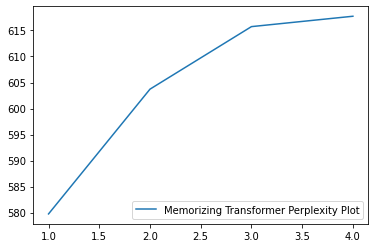

In [ ]:
plt.plot(np.arange(epochs + 1)[1:], perplexity_list, label = "Memorizing Transformer Perplexity Plot")
plt.legend()
plt.show()

# Transformer decoder training

In this section we have defined the TransformerDecoder class that allows to create decoder-only transformers. We have trained an object of this class in order to compare it to the memorizing transformer of the previous section.

In [ ]:
class TransformerDecoder(nn.Module): #decoder-only architecture of the transformer
  def __init__(
        self,
        num_tokens,
        d,
        heads = 8,
        depth = 4,
        hidden_size = 1000,
        dropout = 0.3,
        batch_size = 16,
        use_bert = True
    ):
      # asserts
      self.d = d if not use_bert else 768
      assert self.d % heads == 0
 
      super(TransformerDecoder, self).__init__()
      #self.token_emb = nn.Embedding(num_tokens, self.d)
      self.token_emb = BertModel.from_pretrained('bert-base-uncased')
      self.positional_enc = PositionalEncoding(self.d, max_len = 5000)
      self.dim_head = self.d // heads
      self.heads = heads
      self.depth = depth
      self.hidden_size = hidden_size
      self.dropout = dropout
      self.batch_size = batch_size

      self.layers = nn.ModuleList([])
      for idx in range(depth):
          self.layers.append(
              TransformerBlock(d, heads, batch_size, hidden_size, dropout)
          )

      self.to_out = nn.Linear(d, num_tokens)
    
  def create_mask(self, x):
    batch_size, seq_len = x.shape
    mask = torch.tril(torch.ones((seq_len, seq_len))).expand(
        batch_size, 1, seq_len, seq_len
    )
    return mask 
          
  def forward(self, x):
    mask = self.create_mask(x)

    x = self.token_emb(x)[0] #with bert
    #x = self.token_emb(x) without bert
    x = self.positional_enc(x)

    for idx in range(self.depth):
        x= self.layers[idx](x, mask)

    return self.to_out(x).transpose(1, 2)

In [ ]:
# constants

BATCH_SIZE = 8
SEQ_LEN = 256
SEGMENTS = 5
HEADS = 8
DIM_HEAD = SEQ_LEN // HEADS
DIM_HEAD_BERT = 768 // HEADS
LEARNING_RATE = 2e-4
MAX_GRAD_CLIP_NORM = 0.5

EVAL_EVERY = 20
CHECKPOINT = 5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tr_decoder = TransformerDecoder(
    num_tokens = vocabulary,
    d = SEQ_LEN,
    depth = 4,
    heads = HEADS,
    hidden_size = 5000,
    batch_size = BATCH_SIZE,
    use_bert = True
).to(device)

train_loader_ = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)
test_loader_ = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

In [ ]:
# optimizer
optimizer = torch.optim.Adam(tr_decoder.parameters(), lr = LEARNING_RATE)
loss = nn.CrossEntropyLoss()
epochs = 5
# training

perplexity_tr_decoder = []

for e in range(epochs):
  for i, data in enumerate(tqdm.tqdm(train_loader_, desc = 'training')):
    tr_decoder.train()

    train_loss = 0.

    num_seq = 10000 // (SEQ_LEN + 1)
    data = data.long().to(device)
    for j in range(num_seq):
      mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
      seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]

      out = tr_decoder(seq)

      loss_item = loss(out, labels)
      print(f'training loss: {loss_item}', flush = True)
      loss_item.backward() 
      torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_CLIP_NORM)
      optimizer.step()
      optimizer.zero_grad()
  data = None
    

  if e % EVAL_EVERY == 0:
    tr_decoder.eval()

    with torch.no_grad():
      metric = Perplexity().to(device)
      for i, data in enumerate(tqdm.tqdm(test_loader_, desc = 'evaluation')):
        num_seq = 10000 // (SEQ_LEN + 1)
        data = data.long().to(device)

        for j in range(num_seq):
          mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
          seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]

          out = tr_decoder(seq)

          test_loss = loss(out, labels)
          metric(out.transpose(1, 2), labels)
          print(f'test loss: {test_loss}', flush = True)

      perplexity = metric.compute()
      perplexity_tr_decoder.append(perplexity.to("cpu").item())
      print(f'perplexity: {perplexity}', flush = True)

  data = None
  if e % CHECKPOINT == 0:
    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
    }, 'model_optimizer_tr_decoder.pt')
    """
    #Lorenzo
    with open('/content/drive/MyDrive/Università/Magistrale/Secondo Anno/Neural Networks/project/perplexity_moreNN.npy', 'wb') as f:
      np.save(f, np.array(perplexity_list))
    """
    #Luigi
    with open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'wb') as pklfile:
      pkl.dump(perplexity_tr_decoder, pklfile)

In [ ]:
"""
perplexity_tr_decoder = []
with open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'rb') as pklfile:
  perplexity_tr_decoder = pkl.load(pklfile)
"""

"\nperplexity_tr_decoder = []\nwith open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'rb') as pklfile:\n  perplexity_tr_decoder = pkl.load(pklfile)\n  pklfile.close()\n"

In [ ]:
plt.plot(np.arange(epochs + 1)[1:], perplexity_tr_decoder, label = 'Perplexity transformer decoder')
plt.legend()
plt.show()

A further experiment to do could be the memory fine-tuning, where a KNNMemory object is passed to a decoder-only transformer only after some training epochs. In order to do this we would need to modify the TransformerDecoder class or to create a memorizing transformer after some changes in the KNNAttention class. The latter method would consists in modifying the forward method of KNNAttention to handle a missing KNNMemory so that until we pass to the layer a memory the layer acts like a standard multi-head attention.

In the paper memory fine-tuning is showed to be very effective since it allows a transformer to perform like a memorizing transformer after enough training steps. It would be useful because the retrieval of the nearest neighbors from the external memory clearly makes the vanilla memorizing transformer slower than a regular decoder-only transformer and we could avoid for many training steps this computation and achieve the same results.